In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

In [2]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as cds
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp
import splanl.custom_splai_scores as css

Using TensorFlow backend.


In [3]:
chr11 = '/nfs/kitzman3/lab_common/refs/human/ucsc_hg19/bychrom/chr11.fa'
chr11_seq = pp.get_refseq( chr11 )[ 0 ]

In [4]:
data_in = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [5]:
byvartbl_long = pd.read_table( data_in + 'wt1_ex9_by_var_effects_snvs-2022-0713.txt' )

In [6]:
#extra variants in 5' end of intronic region - just get rid of them right away bc they're confusing
byvartbl_long = byvartbl_long.loc[ byvartbl_long.pos >= 1227 ].copy()

In [7]:
byvartbl_long

,chrom,pos,ref,alt,varlist,sample,n_bc,n_bc_passfilt,sum_reads,sum_reads_passfilt,...,per_bad_ends,per_soft_clipped,per_other_isoform,per_usable_reads,hgvs_pos,hg19_pos,exon_num,ref_c,alt_c,rep
0,jkp815,1227,G,T,jkp815:1227:C:A,BB_RT_1_340_243_Hek1053,866,685,10295,9921,...,0.302389,0.010080,0.141115,98.467896,c.1355-40,32413650,9,C,A,1
1,jkp815,1227,G,C,jkp815:1227:C:G,BB_RT_1_340_243_Hek1053,688,554,8150,7866,...,0.254259,0.000000,0.088991,98.881261,c.1355-40,32413650,9,C,G,1
2,jkp815,1227,G,A,jkp815:1227:C:T,BB_RT_1_340_243_Hek1053,861,697,10360,10014,...,0.149790,0.000000,0.149790,99.131216,c.1355-40,32413650,9,C,T,1
3,jkp815,1228,T,G,jkp815:1228:A:C,BB_RT_1_340_243_Hek1053,626,484,6662,6371,...,0.094177,0.000000,0.094177,99.387851,c.1355-39,32413649,9,A,C,1
4,jkp815,1228,T,C,jkp815:1228:A:G,BB_RT_1_340_243_Hek1053,551,431,6413,6159,...,0.113655,0.016236,0.146128,98.928397,c.1355-39,32413649,9,A,G,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5175,jkp815,1398,A,G,jkp815:1398:T:C,BB_RT_3_ODT_243_Hek1055,104,82,397,375,...,0.000000,0.000000,0.800000,98.933333,c.1447+39,32413479,9,T,C,3
5176,jkp815,1398,A,C,jkp815:1398:T:G,BB_RT_3_ODT_243_Hek1055,63,48,250,235,...,0.425532,0.000000,0.425532,99.148936,c.1447+39,32413479,9,T,G,3
5177,jkp815,1399,A,T,jkp815:1399:T:A,BB_RT_3_ODT_243_Hek1055,47,35,188,176,...,0.000000,0.000000,0.000000,100.000000,c.1447+40,32413478,9,T,A,3
5178,jkp815,1399,A,G,jkp815:1399:T:C,BB_RT_3_ODT_243_Hek1055,39,32,169,163,...,0.000000,0.000000,0.000000,100.000000,c.1447+40,32413478,9,T,C,3


In [8]:
bybc_tbl_l = ! ls /nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/wt1_ex9_*_by_bc_effects_allvars-2022-0609.txt

In [9]:
bybc_tbl_fn = { tbl.split( '/' )[ -1 ].split( '_' )[ 2 ]: pd.read_table( tbl )
                for tbl in bybc_tbl_l }

In [10]:
for lib in bybc_tbl_fn:
    
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ ( bybc_tbl_fn[ lib ].n_variants_passing == 1 ) ].copy()

In [11]:
for lib in bybc_tbl_fn:
    
    print( lib )
    
    print( bybc_tbl_fn[ lib ] )

JKP1053
                         barcode                          sample  passes  \
3        TGAGTTATGATTGTAGCTGATGG  BB_test_Cos1053_JKLab0340_MM1B    True   
7        TGAGTTATGGTCAGGTCGGGTGG  BB_test_Cos1053_JKLab0340_MM1B    True   
11       TGAGTTAGTCGACATGAATCTGG  BB_test_Cos1053_JKLab0340_MM1B    True   
13       TGAGTTCTCTTATGCGTGTTTGG  BB_test_Cos1053_JKLab0340_MM1B    True   
23       ATTAGCATCGAGTAGCAACTTGG  BB_test_Cos1053_JKLab0340_MM1B    True   
...                          ...                             ...     ...   
1569542  ATTGTTATGATCAGCGTTGTTGG         BB_RT_1_ODT_335_Hek1053    True   
1569555  ATTGTGGTAGGTCAGTTTCCTGG         BB_RT_1_ODT_335_Hek1053    True   
1569558  ATTGTGTTCTGAAAGTCGTATGG         BB_RT_1_ODT_335_Hek1053    True   
1569561  ATTGTGTGTTTGACGTGCTCTGG         BB_RT_1_ODT_335_Hek1053    True   
1569562  ATTGTTAGGTTGATGGCGCTTGG         BB_RT_1_ODT_335_Hek1053    True   

        refname status  n_variants_passing                  variant_list  \
3  

In [12]:
for lib in bybc_tbl_fn:
    
    bybc_tbl_fn[ lib ][ 'pos' ] = bybc_tbl_fn[ lib ].variant_list.apply( lambda x: int( x.split( ':' )[ 1 ] ) )
    bybc_tbl_fn[ lib ][ 'ref' ] = bybc_tbl_fn[ lib ].variant_list.apply( lambda x: x.split( ':' )[ 2 ] )
    bybc_tbl_fn[ lib ][ 'alt' ] = bybc_tbl_fn[ lib ].variant_list.apply( lambda x: x.split( ':' )[ 3 ] )

In [13]:
#only want SNV BCs within the region of interest
for lib in bybc_tbl_fn:
    
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ bybc_tbl_fn[ lib ].pos >= 1227 ].copy()
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ bybc_tbl_fn[ lib ].ref.str.len() == 1 ].copy()
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ bybc_tbl_fn[ lib ].alt.str.len() == 1 ].copy()

In [14]:
bybc_tbl_fn[ 'JKP1053' ][ 'sample' ].unique()

array(['BB_test_Cos1053_JKLab0340_MM1B', 'BB_test_Cos1053_JKLab0340_MM2B',
       'BB_test_Cos1053_oligodT_MM1B', 'BB_test_Cos1053_oligodT_MM2B',
       'BB_RT_1_340_243_Cos1053', 'BB_RT_1_340_243_Hek1053',
       'BB_RT_1_340_335_Cos1053', 'BB_RT_1_340_335_Hek1053',
       'BB_RT_1b_340_243_Hek1053', 'BB_RT_1b_340_335_Hek1053',
       'BB_RT_1b_ODT_243_Hek1053', 'BB_RT_1b_ODT_335_Hek1053',
       'BB_RT_1_ODT_243_Cos1053', 'BB_RT_1_ODT_243_Hek1053',
       'BB_RT_1_ODT_335_Cos1053', 'BB_RT_1_ODT_335_Hek1053'], dtype=object)

In [15]:
#we did <,> 20 bp for POU1F1 but had more intronic context
#here we only have 40 bp on each side - so lets only give 10 bp on each side
bybc_int_tbl_fn = { lib: bybc_tbl_fn[ lib ].loc[ ( bybc_tbl_fn[ lib ].pos < 1257 ) | ( bybc_tbl_fn[ lib ].pos > 1369 ) ].copy()
                    for lib in bybc_tbl_fn }

In [16]:
#we did <,> 20 bp for POU1F1 but had more intronic context
#here we only have 40 bp on each side - so lets try 15 bp on each side
#this only adds 2 intermediate intronic variants so I prefer the longer context
#bybc_int_tbl_fn = { lib: bybc_tbl_fn[ lib ].loc[ ( bybc_tbl_fn[ lib ].pos < 1252 ) | ( bybc_tbl_fn[ lib ].pos > 1374 ) ].copy()
                    #for lib in bybc_tbl_fn }

In [17]:
bybc_int_tbl_fn[ 'JKP1053' ][ 'sample' ].unique()

array(['BB_test_Cos1053_JKLab0340_MM1B', 'BB_test_Cos1053_JKLab0340_MM2B',
       'BB_test_Cos1053_oligodT_MM1B', 'BB_test_Cos1053_oligodT_MM2B',
       'BB_RT_1_340_243_Cos1053', 'BB_RT_1_340_243_Hek1053',
       'BB_RT_1_340_335_Cos1053', 'BB_RT_1_340_335_Hek1053',
       'BB_RT_1b_340_243_Hek1053', 'BB_RT_1b_340_335_Hek1053',
       'BB_RT_1b_ODT_243_Hek1053', 'BB_RT_1b_ODT_335_Hek1053',
       'BB_RT_1_ODT_243_Cos1053', 'BB_RT_1_ODT_243_Hek1053',
       'BB_RT_1_ODT_335_Cos1053', 'BB_RT_1_ODT_335_Hek1053'], dtype=object)

In [18]:
read_cut_unfilt = pd.read_table( data_in + 'n_bcs_bysamp.2022-0609.txt' )

In [19]:
cut_dict = { samp: cut for samp,cut in zip( read_cut_unfilt[ 'sample' ], read_cut_unfilt[ '95_y' ] ) }

In [20]:
#these were removed so as to not influence the regression - add manually from wt1_byiso.2022-0609
cut_dict[ 'BB_test_Cos1053_JKLab0340_MM1B' ] = 38
cut_dict[ 'BB_test_Cos1053_JKLab0340_MM2B' ] = 89
cut_dict[ 'BB_test_Cos1053_oligodT_MM1B' ] = 30
cut_dict[ 'BB_test_Cos1053_oligodT_MM2B' ] = 92

In [21]:
cut_dict

{'BB_RT_1_340_243_Cos1053': 12,
 'BB_RT_1_340_243_Hek1053': 3,
 'BB_RT_1_340_335_Cos1053': 14,
 'BB_RT_1_340_335_Hek1053': 3,
 'BB_RT_1b_340_243_Hek1053': 2,
 'BB_RT_1b_340_335_Hek1053': 3,
 'BB_RT_1b_ODT_243_Hek1053': 3,
 'BB_RT_1b_ODT_335_Hek1053': 2,
 'BB_RT_1_ODT_243_Cos1053': 17,
 'BB_RT_1_ODT_243_Hek1053': 4,
 'BB_RT_1_ODT_335_Cos1053': 11,
 'BB_RT_1_ODT_335_Hek1053': 4,
 'BB_RT_2_340_243_Cos1054': 39,
 'BB_RT_2_340_243_Hek1054': 4,
 'BB_RT_2_340_335_Cos1054': 32,
 'BB_RT_2_340_335_Hek1054': 4,
 'BB_RT_2_ODT_243_Cos1054': 42,
 'BB_RT_2_ODT_243_Hek1054': 5,
 'BB_RT_2_ODT_335_Cos1054': 28,
 'BB_RT_2_ODT_335_Hek1054': 3,
 'BB_RT_3_340_243_Cos1055': 1,
 'BB_RT_3_340_243_Hek1055': 1,
 'BB_RT_3_340_335_Cos1055': 1,
 'BB_RT_3_340_335_Hek1055': 1,
 'BB_RT_3_ODT_243_Cos1055': 2,
 'BB_RT_3_ODT_243_Hek1055': 1,
 'BB_RT_3_ODT_335_cos1055': 2,
 'BB_RT_3_ODT_335_Hek1055': 1,
 'BB_test_Cos1053_JKLab0340_MM1B': 38,
 'BB_test_Cos1053_JKLab0340_MM2B': 89,
 'BB_test_Cos1053_oligodT_MM1B': 30,
 'BB_

In [22]:
#same filtering we did during processing to remove low read BCs that could be too influential
bybc_int_tbl_fn_filt_bysamp = { lib: { samp: bybc_int_tbl_fn[ lib ].loc[ ( bybc_int_tbl_fn[ lib ][ 'sample' ] == samp ) & ( bybc_int_tbl_fn[ lib ].usable_reads > cut_dict[ samp ] ) ].copy()
                                       for samp in cut_dict }
                                for lib in bybc_int_tbl_fn }

In [23]:
bybc_int_tbl_fn_filt = { lib: pd.concat( [ bybc_int_tbl_fn_filt_bysamp[ lib ][ samp ] for samp in bybc_int_tbl_fn_filt_bysamp[ lib ] ] )
                         for lib in bybc_int_tbl_fn_filt_bysamp }

In [24]:
bybc_int_tbl_fn_filt[ 'JKP1053' ]

,barcode,sample,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,...,KTS-,SKIP,OTHER,KTS+_psi,KTS-_psi,SKIP_psi,OTHER_psi,pos,ref,alt
79849,TGAGTTATGATTGTAGCTGATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1231:G:C,0.634021,-1.0,123,...,0,1,0,0.950000,0.000000,0.050000,0.000000,1231,G,C
79862,TGAGTTCTGTGTTATCGATTTGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1249:C:G,0.612040,-1.0,183,...,23,5,0,0.719101,0.258427,0.056180,0.000000,1249,C,G
79869,ATTAGGGCTGTTGTTCATGGTGGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1227:C:T,0.666667,-1.0,124,...,1,0,0,0.954545,0.045455,0.000000,0.000000,1227,C,T
79873,ATTAGATCGTGACGCCCGGATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1227:C:A,0.804348,-1.0,37,...,46,0,0,0.041667,0.958333,0.000000,0.000000,1227,C,A
79884,ATTAGAGTTTACCGAAGTTATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1392:T:A,0.614583,-1.0,118,...,29,0,0,0.033333,0.966667,0.000000,0.000000,1392,T,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79709,GATGTCAATAAGACGTTGTGTGG,BB_test_Cos1053_oligodT_MM2B,True,jkp815,pass,1,jkp815:1379:C:G,0.641026,-1.0,50,...,144,2,0,0.046980,0.966443,0.013423,0.000000,1379,C,G
79730,TTTCGACCTAGAAATCCACTTGG,BB_test_Cos1053_oligodT_MM2B,True,jkp815,pass,1,jkp815:1378:A:C,0.666667,-1.0,56,...,131,4,0,0.490566,0.494340,0.015094,0.000000,1378,A,C
79745,TCGAGGGTGTCGTGTAACATTGG,BB_test_Cos1053_oligodT_MM2B,True,jkp815,pass,1,jkp815:1375:T:A,0.711538,-1.0,74,...,4,5,2,0.943590,0.020513,0.025641,0.010256,1375,T,A
79746,TCGAGTCTTAGCTCGTGGGTTGG,BB_test_Cos1053_oligodT_MM2B,True,jkp815,pass,1,jkp815:1399:T:G,0.769231,-1.0,10,...,9,6,0,0.904459,0.057325,0.038217,0.000000,1399,T,G


In [25]:
byvartbl_long = byvartbl_long.loc[ byvartbl_long.n_bc_passfilt > 0 ] .copy()

In [26]:
bybc_int_tbl = pd.concat( [ bybc_int_tbl_fn_filt[ lib ] for lib in bybc_int_tbl_fn_filt ] )

In [27]:
bybc_int_tbl

,barcode,sample,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,...,KTS-,SKIP,OTHER,KTS+_psi,KTS-_psi,SKIP_psi,OTHER_psi,pos,ref,alt
79849,TGAGTTATGATTGTAGCTGATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1231:G:C,0.634021,-1.0,123,...,0,1,0,0.950000,0.000000,0.050000,0.0,1231,G,C
79862,TGAGTTCTGTGTTATCGATTTGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1249:C:G,0.612040,-1.0,183,...,23,5,0,0.719101,0.258427,0.056180,0.0,1249,C,G
79869,ATTAGGGCTGTTGTTCATGGTGGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1227:C:T,0.666667,-1.0,124,...,1,0,0,0.954545,0.045455,0.000000,0.0,1227,C,T
79873,ATTAGATCGTGACGCCCGGATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1227:C:A,0.804348,-1.0,37,...,46,0,0,0.041667,0.958333,0.000000,0.0,1227,C,A
79884,ATTAGAGTTTACCGAAGTTATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1392:T:A,0.614583,-1.0,118,...,29,0,0,0.033333,0.966667,0.000000,0.0,1392,T,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571893,GTGGGCTTGGCGGTTTAATATGG,BB_RT_3_ODT_335_Hek1055,True,jkp815,pass,1,jkp815:1228:A:T,0.765432,-1.0,62,...,3,0,0,0.000000,1.000000,0.000000,0.0,1228,A,T
1571905,GTGGGATATGTTTTGAGTGATGG,BB_RT_3_ODT_335_Hek1055,True,jkp815,pass,1,jkp815:1244:C:G,0.736842,-1.0,14,...,1,7,0,0.333333,0.083333,0.583333,0.0,1244,C,G
1571930,GTGGCTTTGTATATCCTGGTTGG,BB_RT_3_ODT_335_Hek1055,True,jkp815,pass,1,jkp815:1380:A:T,0.789474,-1.0,30,...,2,0,0,0.000000,1.000000,0.000000,0.0,1380,A,T
1571931,GTGGGACTATCGACTCAATGTGG,BB_RT_3_ODT_335_Hek1055,True,jkp815,pass,1,jkp815:1251:T:C,0.620690,-1.0,36,...,1,0,0,0.500000,0.500000,0.000000,0.0,1251,T,C


In [28]:
byvartbl_long[ 'wmean_KTS_+_ratio_log2' ] = np.log2( ( byvartbl_long[ 'wmean_KTS+' ] + .001 ) / ( byvartbl_long[ 'wmean_KTS-' ] + .001 ) )

In [29]:
bybc_int_tbl[ 'KTS_+_ratio_log2_psi' ] = np.log2( ( bybc_int_tbl[ 'KTS+_psi' ] + .001 ) / ( bybc_int_tbl[ 'KTS-_psi' ] + .001 ) )

In [30]:
iso_names = [ 'KTS_+_ratio_log2', 'SKIP', 'OTHER' ]

In [31]:
%%time
byvartbl_long_bs = pd.concat( [ pp.bootstrap_varsp_null_distribution( bybc_int_tbl.loc[ bybc_int_tbl[ 'sample' ] == samp ].set_index( 'barcode' ),
                                                                      byvartbl_long.loc[ ( byvartbl_long[ 'sample' ] == samp ) ],
                                                                      iso_names = iso_names )
                              for samp in byvartbl_long[ 'sample' ].unique().tolist() ],
                              ignore_index = True ).drop( columns = [ 'index' ] )

done
done
done
done
done
done
done
done
done
done
CPU times: user 5.47 s, sys: 14.3 ms, total: 5.48 s
Wall time: 5.48 s


In [32]:
byvartbl_long_bs = pp.compute_null_zscores( byvartbl_long_bs,
                                            'bs_null', 
                                             iso_names )

In [33]:
%%time
byvartbl_long_bs = pd.concat( [ pp.compute_fold_change( byvartbl_long_bs.loc[ byvartbl_long_bs[ 'sample' ] == samp ],
                                                        'wmean_bs_null_',
                                                         'wmean_') 
                                                        for samp in byvartbl_long_bs[ 'sample' ].unique().tolist() ],
                                                        ignore_index = True ).sort_values( by = 'pos' )

CPU times: user 40.3 ms, sys: 2.69 ms, total: 43 ms
Wall time: 42.5 ms


In [34]:
for iso in iso_names:
        
        byvartbl_long_bs[ 'wmean_diff_' + iso ] = byvartbl_long_bs[ 'wmean_' + iso ] - byvartbl_long_bs[ 'wmean_bs_null_' + iso ]

In [35]:
bonfer = .05 / ( 3*len( byvartbl_long_bs.pos.unique() ) )

In [36]:
bonfer

9.633911368015414e-05

In [37]:
ss.norm.ppf( 1 - bonfer )

3.7284276248331487

In [38]:
byvartbl_long_bs[ 'sdv_SKIP' ] = ( byvartbl_long_bs[ 'zwmean_bs_null_SKIP' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_long_bs[ 'wmean_diff_SKIP' ] >= .2 )

In [39]:
byvartbl_long_bs[ 'sdv_OTHER' ] = ( byvartbl_long_bs[ 'zwmean_bs_null_OTHER' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_long_bs[ 'wmean_diff_OTHER' ] >= .2 )

(array([  12.,  121.,   53.,   69.,  530., 4036.,  158.,   28.,  107.,
          66.]),
 array([-3.77564065, -3.0340014 , -2.29236214, -1.55072289, -0.80908363,
        -0.06744438,  0.67419488,  1.41583413,  2.15747339,  2.89911264,
         3.6407519 ]),
 <BarContainer object of 10 artists>)

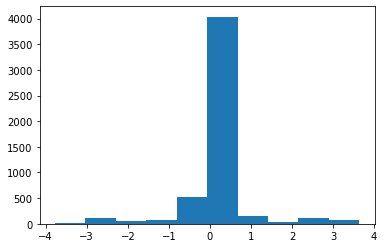

In [40]:
plt.hist( byvartbl_long_bs[ 'wmean_KTS_+_ratio_log2' ] )

In [41]:
byvartbl_long_bs[ 'sdv_KTS_+_ratio_log2' ] = ( np.abs( byvartbl_long_bs[ 'zwmean_bs_null_KTS_+_ratio_log2' ] ) >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( np.abs( byvartbl_long_bs[ 'wmean_KTS_+_ratio_log2' ] ) >= 1.5 )

In [42]:
byvartbl_long_bs[ 'sdv' ] = byvartbl_long_bs[ [ col for col in byvartbl_long_bs if 'sdv_' in col ] ].any( axis = 1 )

In [43]:
byvartbl_long_bs[ 'intmed_SKIP' ] = ( byvartbl_long_bs[ 'zwmean_bs_null_SKIP' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_long_bs[ 'wmean_diff_SKIP' ] >= .1 )

In [44]:
byvartbl_long_bs[ 'intmed_OTHER' ] = ( byvartbl_long_bs[ 'zwmean_bs_null_OTHER' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_long_bs[ 'wmean_diff_OTHER' ] >= .1 )

In [45]:
byvartbl_long_bs[ 'intmed_KTS_+_ratio_log2' ] = ( np.abs( byvartbl_long_bs[ 'zwmean_bs_null_KTS_+_ratio_log2' ] ) >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( np.abs( byvartbl_long_bs[ 'wmean_KTS_+_ratio_log2' ] ) >= 1 )

In [46]:
byvartbl_long_bs[ 'intmed' ] = byvartbl_long_bs[ [ col for col in byvartbl_long_bs if 'intmed_' in col ] ].any( axis = 1 )

In [47]:
byvartbl_wide_bs = mbcs.combine_rep_pervartbls_wide( [ byvartbl_long_bs.loc[ byvartbl_long_bs[ 'sample' ] == samp ][ [ col for col in byvartbl_long_bs if col != 'sample' and col != 'rep' ] ]
                                                    for samp in byvartbl_long_bs[ 'sample' ].unique() ],
                                                  [ samp for samp in byvartbl_long_bs[ 'sample' ].unique() ],
                                                  indexcols=[ 'chrom','pos','ref','ref_c','alt','alt_c','varlist','hg19_pos','hgvs_pos','exon_num' ], 
                                                  group_cols_by_samp = True )

In [48]:
byvartbl_wide = pd.read_table( data_in + 'wt1_ex9_by_var_effects_snvs_wide-2022-0713.txt' ) 

In [49]:
byvartbl_wide

,pos,ref,chrom,hg19_pos,alt,ref_c,alt_c,varlist,hgvs_pos,exon_num,...,maxent_wt_acc,maxent_wt_don,maxent_KTS+,maxent_KTS-,maxent_acc,maxent_alt_acc,splai_KTS+_ratio,splai_KTS+_ratio_log10,maxent_KTS+_nomiss,maxent_KTS-_nomiss
0,1227,G,11,32413650,T,C,A,jkp815:1227:C:A,c.1355-40,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.678108,8.594409
1,1227,G,11,32413650,C,C,G,jkp815:1227:C:G,c.1355-40,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.678108,8.594409
2,1227,G,11,32413650,A,C,T,jkp815:1227:C:T,c.1355-40,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.678108,8.594409
3,1228,T,11,32413649,G,A,C,jkp815:1228:A:C,c.1355-39,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.678108,8.594409
4,1228,T,11,32413649,C,A,G,jkp815:1228:A:G,c.1355-39,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.678108,8.594409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1398,A,11,32413479,G,T,C,jkp815:1398:T:C,c.1447+39,9,...,NaN,NaN,NaN,NaN,NaN,NaN,0.861154,-0.064919,6.678108,8.594409
514,1398,A,11,32413479,C,T,G,jkp815:1398:T:G,c.1447+39,9,...,NaN,NaN,NaN,NaN,NaN,NaN,0.865557,-0.062704,6.678108,8.594409
515,1399,A,11,32413478,T,T,A,jkp815:1399:T:A,c.1447+40,9,...,NaN,NaN,NaN,NaN,NaN,NaN,0.846592,-0.072326,6.678108,8.594409
516,1399,A,11,32413478,G,T,C,jkp815:1399:T:C,c.1447+40,9,...,NaN,NaN,NaN,NaN,NaN,NaN,0.857857,-0.066585,6.678108,8.594409


In [50]:
new_cols = list( byvartbl_wide_bs.columns.difference( byvartbl_wide.columns ) )

In [51]:
merge_idx = [ 'pos', 'ref', 'alt' ]

byvartbl_wide_m = byvartbl_wide.set_index( merge_idx ).merge( byvartbl_wide_bs.set_index( merge_idx )[ new_cols ],
                                                              how = 'outer',
                                                              left_index = True,
                                                              right_index = True ).reset_index()

In [52]:
byvartbl_wide_m

,pos,ref,alt,chrom,hg19_pos,ref_c,alt_c,varlist,hgvs_pos,exon_num,...,BB_RT_3_ODT_243_Hek1055_wmean_bs_null_SKIP,BB_RT_3_ODT_243_Hek1055_wmean_diff_KTS_+_ratio_log2,BB_RT_3_ODT_243_Hek1055_wmean_diff_OTHER,BB_RT_3_ODT_243_Hek1055_wmean_diff_SKIP,BB_RT_3_ODT_243_Hek1055_wstdev_bs_null_KTS_+_ratio_log2,BB_RT_3_ODT_243_Hek1055_wstdev_bs_null_OTHER,BB_RT_3_ODT_243_Hek1055_wstdev_bs_null_SKIP,BB_RT_3_ODT_243_Hek1055_zwmean_bs_null_KTS_+_ratio_log2,BB_RT_3_ODT_243_Hek1055_zwmean_bs_null_OTHER,BB_RT_3_ODT_243_Hek1055_zwmean_bs_null_SKIP
0,1227,G,A,11,32413650,C,T,jkp815:1227:C:T,c.1355-40,9,...,0.073198,-0.118450,-0.000220,-0.004184,0.154626,0.001351,0.008619,-0.766044,-0.162894,-0.485456
1,1227,G,C,11,32413650,C,G,jkp815:1227:C:G,c.1355-40,9,...,0.073302,-0.239001,-0.001005,-0.016991,0.158570,0.001492,0.008987,-1.507229,-0.673806,-1.890574
2,1227,G,T,11,32413650,C,A,jkp815:1227:C:A,c.1355-40,9,...,0.073318,-0.250117,0.001977,-0.011313,0.179911,0.001619,0.009526,-1.390222,1.221154,-1.187616
3,1228,T,A,11,32413649,A,T,jkp815:1228:A:T,c.1355-39,9,...,0.073253,-0.160851,-0.001197,0.025292,0.166044,0.001545,0.009289,-0.968728,-0.774491,2.722769
4,1228,T,C,11,32413649,A,G,jkp815:1228:A:G,c.1355-39,9,...,0.073099,-0.095405,-0.002014,-0.017468,0.216270,0.001889,0.011537,-0.441136,-1.066432,-1.514106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1398,A,G,11,32413479,T,C,jkp815:1398:T:C,c.1447+39,9,...,0.072848,-0.037305,-0.001353,-0.035112,0.432586,0.003938,0.022251,-0.086238,-0.343548,-1.577967
514,1398,A,T,11,32413479,T,A,jkp815:1398:T:A,c.1447+39,9,...,0.073014,-0.380801,0.002288,-0.015506,0.472152,0.004193,0.023735,-0.806523,0.545699,-0.653293
515,1399,A,C,11,32413478,T,G,jkp815:1399:T:G,c.1447+40,9,...,0.073037,0.204642,0.000760,-0.019639,0.606644,0.005530,0.030064,0.337335,0.137376,-0.653227
516,1399,A,G,11,32413478,T,C,jkp815:1399:T:C,c.1447+40,9,...,0.073372,0.141629,0.001963,-0.018157,0.747954,0.006246,0.035027,0.189356,0.314321,-0.518383


In [53]:
for iso in iso_names:
    
    byvartbl_wide_m[ 'fc_' + iso ] = byvartbl_wide_m[ [ col for col in byvartbl_wide_m.columns if '_fc_' + iso in col ] ].median( axis = 1 )

In [54]:
for iso in iso_names:
    
    byvartbl_wide_m[ 'wmean_bs_null_' + iso ] = byvartbl_wide_m[ [ col for col in byvartbl_wide_m.columns if '_wmean_bs_null_' + iso in col ] ].median( axis = 1 )

In [55]:
for iso in iso_names:
    
    byvartbl_wide_m[ 'wmean_diff_' + iso ] = byvartbl_wide_m[ [ col for col in byvartbl_wide_m.columns if '_wmean_diff_' + iso in col ] ].median( axis = 1 )

In [56]:
for iso in iso_names:
    
    byvartbl_wide_m[ 'wmean_' + iso ] = byvartbl_wide_m[ [ col for col in byvartbl_wide_m.columns if '_wmean_' + iso in col ] ].median( axis = 1 )

In [57]:
byvartbl_wide_m = pp.stouffers_z( byvartbl_wide_m,
                                  iso_names,
                                  zcol = 'zwmean_bs_null_')

In [58]:
byvartbl_wide_m

,pos,ref,alt,chrom,hg19_pos,ref_c,alt_c,varlist,hgvs_pos,exon_num,...,wmean_bs_null_KTS_+_ratio_log2,wmean_bs_null_SKIP,wmean_bs_null_OTHER,wmean_diff_KTS_+_ratio_log2,wmean_diff_SKIP,wmean_diff_OTHER,wmean_KTS_+_ratio_log2,zwmean_bs_null_KTS_+_ratio_log2,zwmean_bs_null_SKIP,zwmean_bs_null_OTHER
0,1227,G,A,11,32413650,C,T,jkp815:1227:C:T,c.1355-40,9,...,0.274774,0.104860,0.004030,-0.066811,0.014164,-0.000906,0.237376,-1.591722,3.443468,-2.473827
1,1227,G,C,11,32413650,C,G,jkp815:1227:C:G,c.1355-40,9,...,0.273583,0.104876,0.004040,-0.072372,-0.015989,-0.001123,0.215904,-1.741850,-4.582633,-1.453145
2,1227,G,T,11,32413650,C,A,jkp815:1227:C:A,c.1355-40,9,...,0.274808,0.104837,0.004026,-0.052539,-0.016786,-0.000503,0.212180,-1.800733,-4.847713,-0.006245
3,1228,T,A,11,32413649,A,T,jkp815:1228:A:T,c.1355-39,9,...,0.273779,0.104742,0.004031,-0.055059,0.020508,-0.000942,0.275429,-1.044438,6.439120,-1.293265
4,1228,T,C,11,32413649,A,G,jkp815:1228:A:G,c.1355-39,9,...,0.273483,0.104680,0.003975,-0.023913,-0.017290,0.000989,0.249570,-0.694362,-2.994953,1.604116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1398,A,G,11,32413479,T,C,jkp815:1398:T:C,c.1447+39,9,...,0.273075,0.102651,0.003973,-0.140067,-0.034303,-0.001673,0.116468,-0.988502,-0.978147,-0.958673
514,1398,A,T,11,32413479,T,A,jkp815:1398:T:A,c.1447+39,9,...,0.278564,0.102726,0.004016,-0.284093,-0.032500,0.000004,0.081635,-1.653917,-2.689689,0.073497
515,1399,A,C,11,32413478,T,G,jkp815:1399:T:G,c.1447+40,9,...,0.271806,0.102002,0.004020,0.079388,-0.029863,-0.002141,0.349492,0.771762,-1.797731,-1.302590
516,1399,A,G,11,32413478,T,C,jkp815:1399:T:C,c.1447+40,9,...,0.284554,0.101386,0.003934,-0.129657,-0.015505,-0.001847,0.118683,-0.745363,-0.714920,-0.409358


KTS_+_ratio_log2


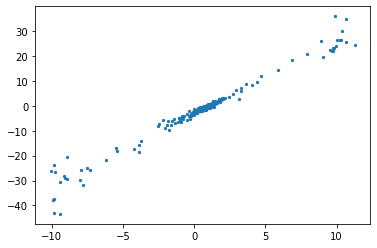

SKIP


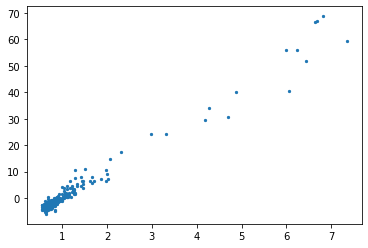

OTHER


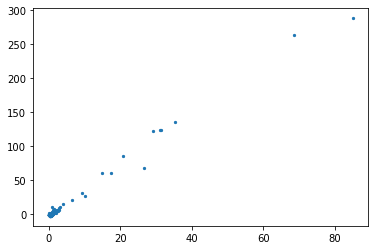

In [59]:
for iso in iso_names:
    
    print( iso )
    
    plt.scatter( byvartbl_wide_m[ 'fc_' + iso ],
                 byvartbl_wide_m[ 'zwmean_bs_null_' + iso ],
                 s = 5 )
    
    plt.ylim(  )
    
    plt.show()

KTS_+_ratio_log2


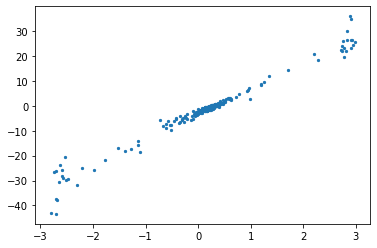

SKIP


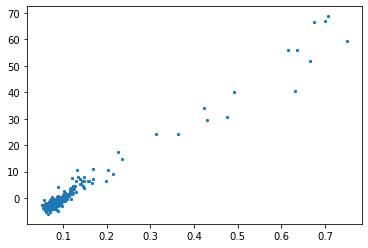

OTHER


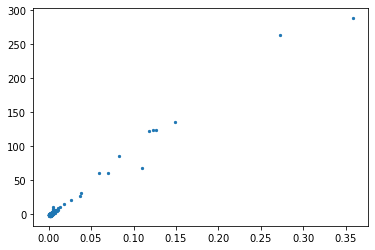

In [60]:
for iso in iso_names:
    
    print( iso )
    
    plt.scatter( byvartbl_wide_m[ 'wmean_' + iso ],
                 byvartbl_wide_m[ 'zwmean_bs_null_' + iso ],
                 s = 5 )
    
    plt.ylim(  )
    
    plt.show()

In [61]:
byvartbl_wide_m[ 'sdv_SKIP' ] = ( byvartbl_wide_m[ 'zwmean_bs_null_SKIP' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_wide_m[ 'wmean_diff_SKIP' ] >= .2 )

In [62]:
byvartbl_wide_m[ 'sdv_OTHER' ] = ( byvartbl_wide_m[ 'zwmean_bs_null_OTHER' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_wide_m[ 'wmean_diff_OTHER' ] >= .2 )

In [63]:
byvartbl_wide_m[ 'sdv_KTS_+_ratio_log2' ] = ( np.abs( byvartbl_wide_m[ 'zwmean_bs_null_KTS_+_ratio_log2' ] ) >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( np.abs( byvartbl_wide_m[ 'wmean_KTS_+_ratio_log2' ] ) >= 1.5 )

In [64]:
byvartbl_wide_m[ 'intmed_SKIP' ] = ( byvartbl_wide_m[ 'zwmean_bs_null_SKIP' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_wide_m[ 'wmean_diff_SKIP' ] >= .1 )

In [65]:
byvartbl_wide_m[ 'intmed_OTHER' ] = ( byvartbl_wide_m[ 'zwmean_bs_null_OTHER' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_wide_m[ 'wmean_diff_OTHER' ] >= .1 )

In [66]:
byvartbl_wide_m[ 'intmed_KTS_+_ratio_log2' ] = ( np.abs( byvartbl_wide_m[ 'zwmean_bs_null_KTS_+_ratio_log2' ] ) >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( np.abs( byvartbl_wide_m[ 'wmean_KTS_+_ratio_log2' ] ) >= 1 )

In [67]:
#this gave me wayyyyy to many OTHER
#for iso in iso_names:
    
    #byvartbl_wide_m[ 'sdv_' + iso ] = byvartbl_wide_m[ [ col for col in byvartbl_wide_m if '_sdv_' + iso in col ] ].any( axis = 1 )

In [68]:
#byvartbl_wide_m = pp.sdv_by_iso( byvartbl_wide_m,
                                   #iso_names,
                                   #'zwmean_bs_null_',
                                   #ss.norm.ppf( 1 - bonfer ),
                                   #'fc_',
                                   #2,
                                   #out_col_stem = 'sdv_fc2+_',
                                   #bi_directional = False
                                   #)

In [69]:
byvartbl_wide_m

,pos,ref,alt,chrom,hg19_pos,ref_c,alt_c,varlist,hgvs_pos,exon_num,...,wmean_KTS_+_ratio_log2,zwmean_bs_null_KTS_+_ratio_log2,zwmean_bs_null_SKIP,zwmean_bs_null_OTHER,sdv_SKIP,sdv_OTHER,sdv_KTS_+_ratio_log2,intmed_SKIP,intmed_OTHER,intmed_KTS_+_ratio_log2
0,1227,G,A,11,32413650,C,T,jkp815:1227:C:T,c.1355-40,9,...,0.237376,-1.591722,3.443468,-2.473827,False,False,False,False,False,False
1,1227,G,C,11,32413650,C,G,jkp815:1227:C:G,c.1355-40,9,...,0.215904,-1.741850,-4.582633,-1.453145,False,False,False,False,False,False
2,1227,G,T,11,32413650,C,A,jkp815:1227:C:A,c.1355-40,9,...,0.212180,-1.800733,-4.847713,-0.006245,False,False,False,False,False,False
3,1228,T,A,11,32413649,A,T,jkp815:1228:A:T,c.1355-39,9,...,0.275429,-1.044438,6.439120,-1.293265,False,False,False,False,False,False
4,1228,T,C,11,32413649,A,G,jkp815:1228:A:G,c.1355-39,9,...,0.249570,-0.694362,-2.994953,1.604116,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1398,A,G,11,32413479,T,C,jkp815:1398:T:C,c.1447+39,9,...,0.116468,-0.988502,-0.978147,-0.958673,False,False,False,False,False,False
514,1398,A,T,11,32413479,T,A,jkp815:1398:T:A,c.1447+39,9,...,0.081635,-1.653917,-2.689689,0.073497,False,False,False,False,False,False
515,1399,A,C,11,32413478,T,G,jkp815:1399:T:G,c.1447+40,9,...,0.349492,0.771762,-1.797731,-1.302590,False,False,False,False,False,False
516,1399,A,G,11,32413478,T,C,jkp815:1399:T:C,c.1447+40,9,...,0.118683,-0.745363,-0.714920,-0.409358,False,False,False,False,False,False


In [70]:
byvartbl_wide_m[ 'sdv' ] = byvartbl_wide_m[ [ 'sdv_' + iso for iso in iso_names ] ].any( axis = 'columns' )

In [71]:
byvartbl_wide_m[ 'intmed' ] = ( byvartbl_wide_m[ [ 'intmed_' + iso for iso in iso_names ] ].any( axis = 'columns' ) ) & ~( byvartbl_wide_m.sdv )

In [72]:
byvartbl_wide_m[ 'sdv_exon' ] = ( byvartbl_wide_m.pos >= 1267 ) & ( byvartbl_wide_m.pos <= 1359 ) & ( byvartbl_wide_m[ 'sdv' ] )
byvartbl_wide_m[ 'sdv_intron' ] = ( ( byvartbl_wide_m.pos < 1267 ) | ( byvartbl_wide_m.pos > 1359 ) ) & ( byvartbl_wide_m[ 'sdv' ] )

In [73]:
byvartbl_wide_m[ 'intmed_exon' ] = ( byvartbl_wide_m.pos >= 1267 ) & ( byvartbl_wide_m.pos <= 1359 ) & ( byvartbl_wide_m[ 'intmed' ] )
byvartbl_wide_m[ 'intmed_intron' ] = ( ( byvartbl_wide_m.pos < 1267 ) | ( byvartbl_wide_m.pos > 1359 ) ) & ( byvartbl_wide_m[ 'intmed' ] )

In [74]:
byvartbl_wide_m[ 'exon' ] = ( byvartbl_wide_m.pos >= 1267 ) & ( byvartbl_wide_m.pos <= 1359 ) 
byvartbl_wide_m[ 'intron' ] = ( ( byvartbl_wide_m.pos < 1267 ) | ( byvartbl_wide_m.pos > 1359 ) )

In [75]:
byvartbl_wide_m.loc[ byvartbl_wide_m.intmed ]

,pos,ref,alt,chrom,hg19_pos,ref_c,alt_c,varlist,hgvs_pos,exon_num,...,intmed_OTHER,intmed_KTS_+_ratio_log2,sdv,intmed,sdv_exon,sdv_intron,intmed_exon,intmed_intron,exon,intron
12,1231,C,A,11,32413646,G,T,jkp815:1231:G:T,c.1355-36,9,...,False,False,False,True,False,False,False,True,False,True
27,1236,C,A,11,32413641,G,T,jkp815:1236:G:T,c.1355-31,9,...,False,False,False,True,False,False,False,True,False,True
81,1254,A,C,11,32413623,T,G,jkp815:1254:T:G,c.1355-13,9,...,False,False,False,True,False,False,False,True,False,True
94,1258,A,T,11,32413619,T,A,jkp815:1258:T:A,c.1355-9,9,...,True,False,False,True,False,False,False,True,False,True
355,1345,T,G,11,32413532,A,C,jkp815:1345:A:C,c.1433,9,...,False,True,False,True,False,False,True,False,True,False
361,1347,T,G,11,32413530,A,C,jkp815:1347:A:C,c.1435,9,...,False,True,False,True,False,False,True,False,True,False
362,1348,G,A,11,32413529,C,T,jkp815:1348:C:T,c.1436,9,...,False,True,False,True,False,False,True,False,True,False
382,1354,T,G,11,32413523,A,C,jkp815:1354:A:C,c.1442,9,...,False,True,False,True,False,False,True,False,True,False
383,1355,T,A,11,32413522,A,T,jkp815:1355:A:T,c.1443,9,...,False,True,False,True,False,False,True,False,True,False
393,1358,T,C,11,32413519,A,G,jkp815:1358:A:G,c.1446,9,...,False,True,False,True,False,False,True,False,True,False


In [76]:
github_colors = '3182bd6baed69ecae1c6dbefe6550dfd8d3cfdae6bfdd0a231a35474c476a1d99bc7e9c0756bb19e9ac8bcbddcdadaeb636363969696bdbdbdd9d9d9'

In [77]:
light_colors = [ '#' + github_colors[i:i+6] for i in range( 0, len( github_colors ), 6 ) ]

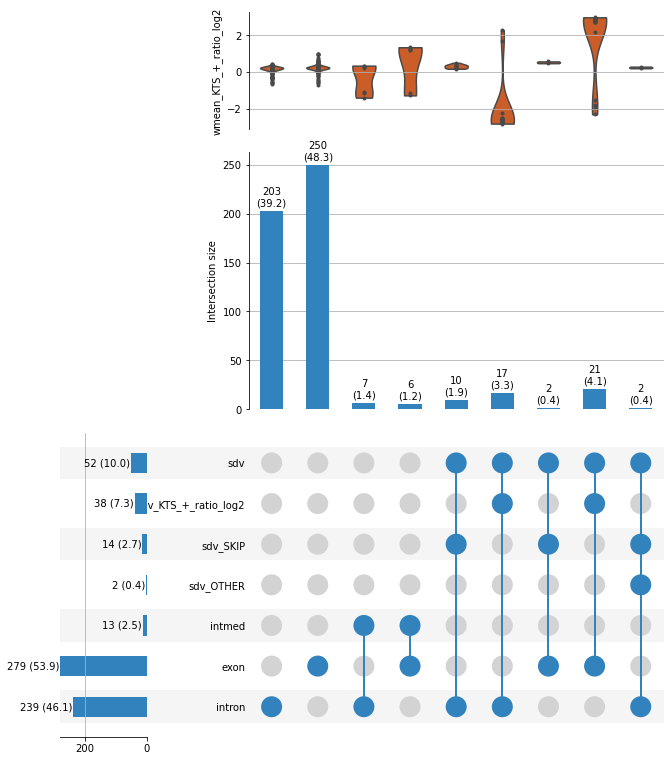

In [78]:
sp.upset_plot( byvartbl_wide_m, 
               [ 'sdv', 'sdv_KTS_+_ratio_log2', 'sdv_SKIP', 'sdv_OTHER', 'intmed', 'exon', 'intron', ][::-1],
                ( 14, 14 ),
                [ 'wmean_KTS_+_ratio_log2' ],
                [ 'violin' ],
                [ light_colors[ 4 ] ],
                show_counts = '%d',
                show_percentages = '%.1f',
                facecolor = light_colors[ 0 ],
                element_size = 60,
               sort_categories_by = None,
              )

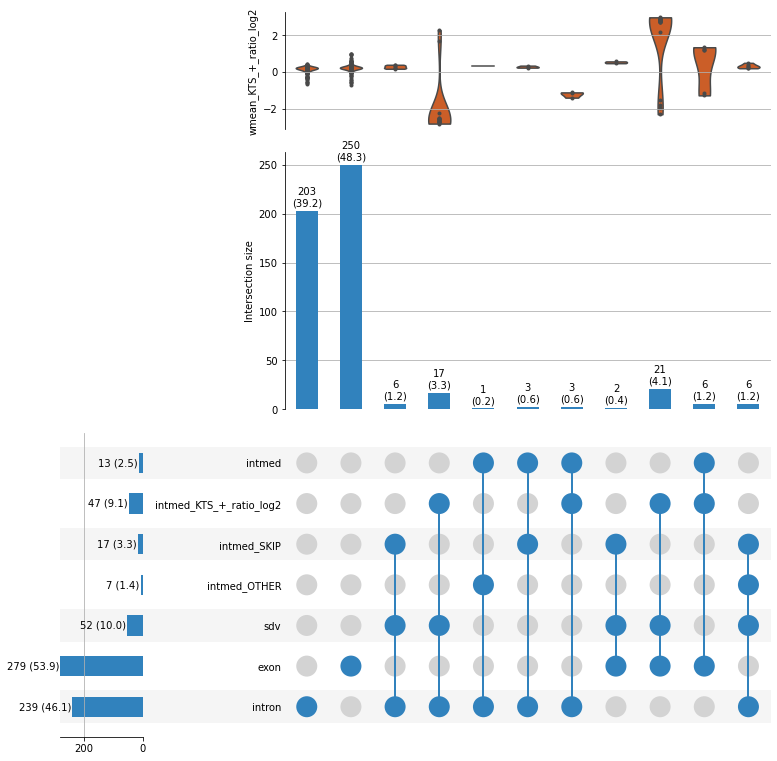

In [79]:
sp.upset_plot( byvartbl_wide_m, 
               [ 'intmed', 'intmed_KTS_+_ratio_log2', 'intmed_SKIP', 'intmed_OTHER', 'sdv', 'exon', 'intron', ][::-1],
                ( 14, 14 ),
                [ 'wmean_KTS_+_ratio_log2' ],
                [ 'violin' ],
                [ light_colors[ 4 ] ],
                show_counts = '%d',
                show_percentages = '%.1f',
                facecolor = light_colors[ 0 ],
                element_size = 60,
               sort_categories_by = None,
              )

In [80]:
byvartbl_sat = pp.saturate_variants( byvartbl_wide_m,
                                     chr11_seq,
                                     'hg19_pos',
                                      'exon_num',
                                      rev_strand = True )[ 9 ]

In [81]:
#plots get messed up without the vector position included
byvartbl_sat[ 'pos' ] = byvartbl_sat.hg19_pos - 32412079 - 2*( byvartbl_sat.hg19_pos - byvartbl_sat.hg19_pos.min() )

In [82]:
byvartbl_sat[ 'hgvs_pos' ] = cds.pos_to_hgvspos( byvartbl_sat.pos,
                                                 ( 1058, 1554 ),
                                                [ (1267, 1359) ],
                                                [ ( 1355, 1447 ), ]
                                                )

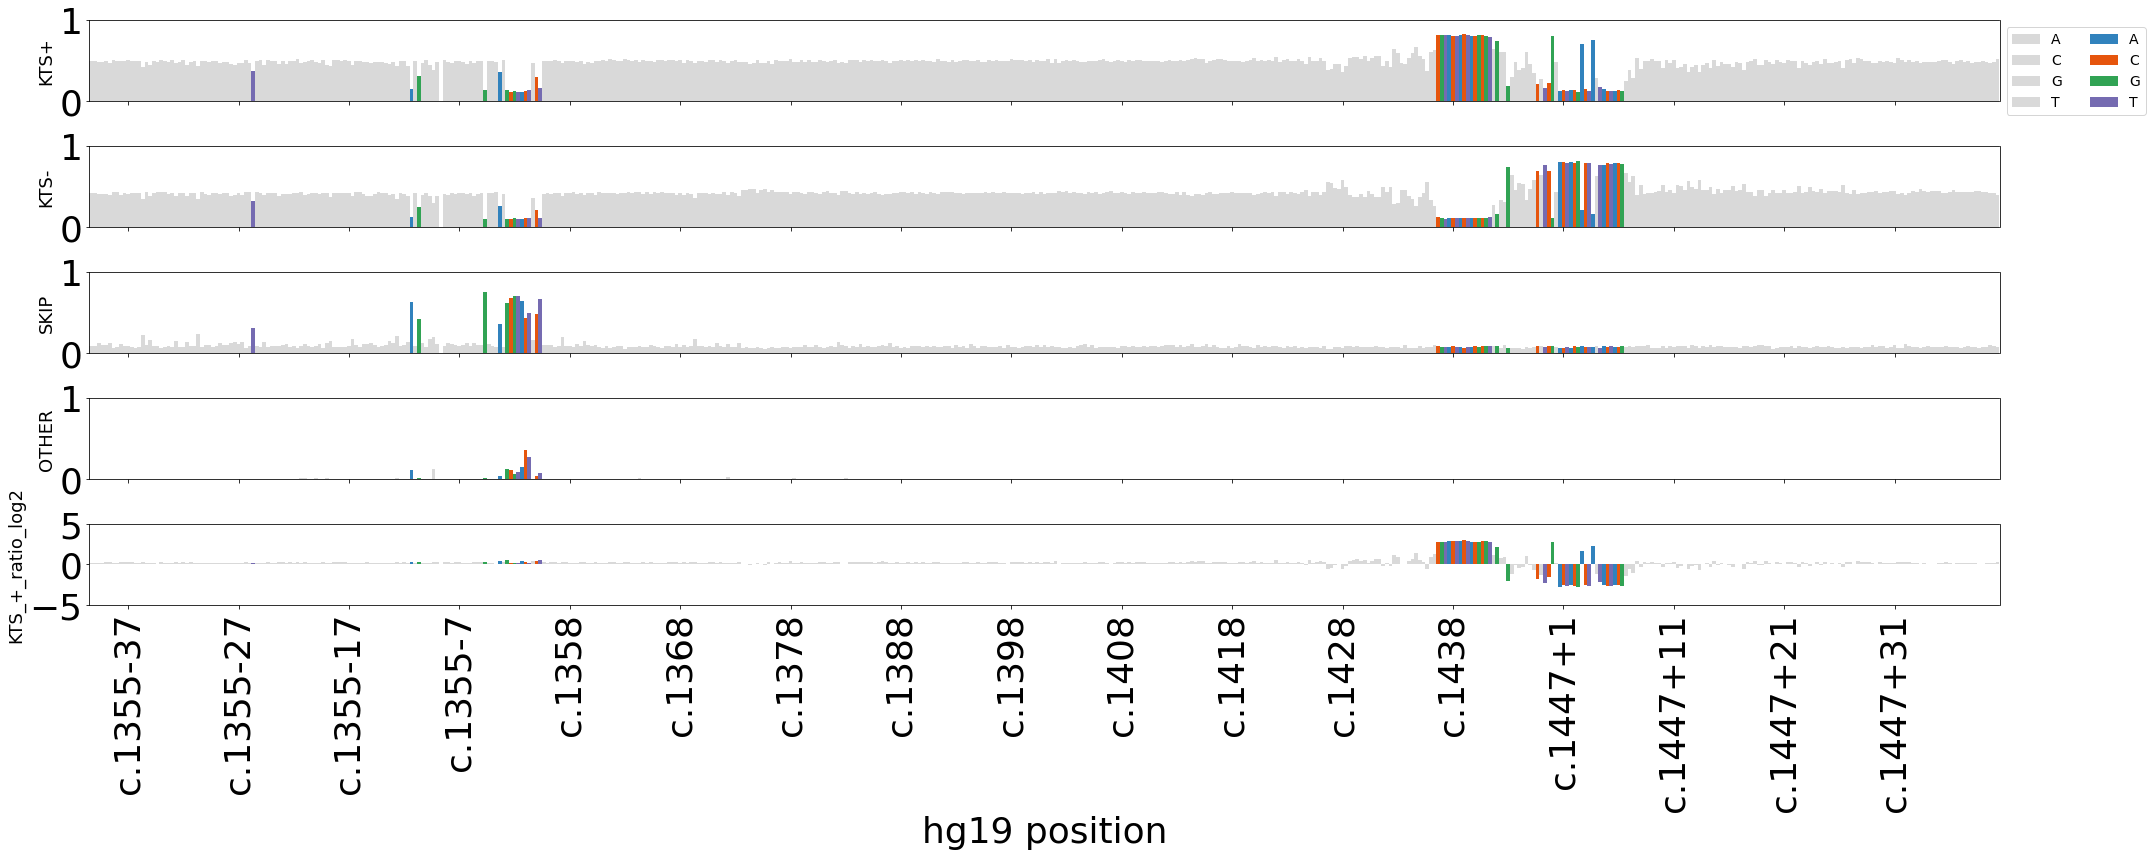

In [83]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 3 ] ) ],
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

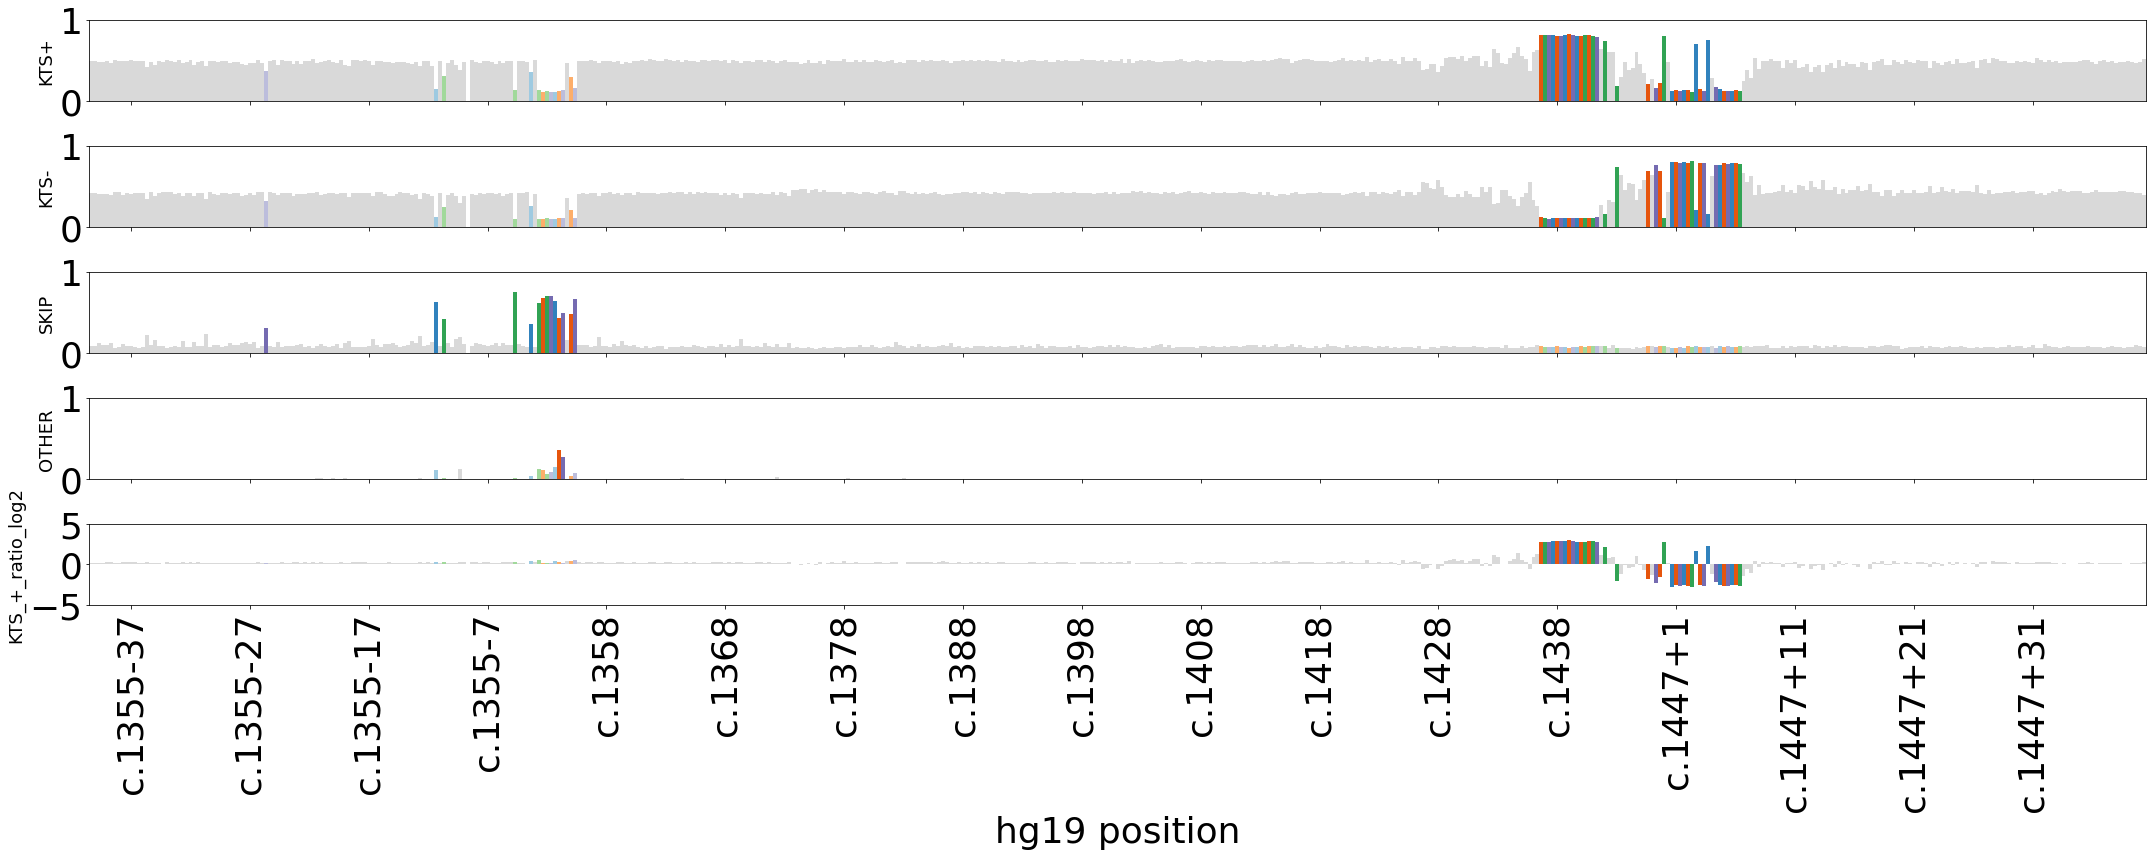

In [84]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

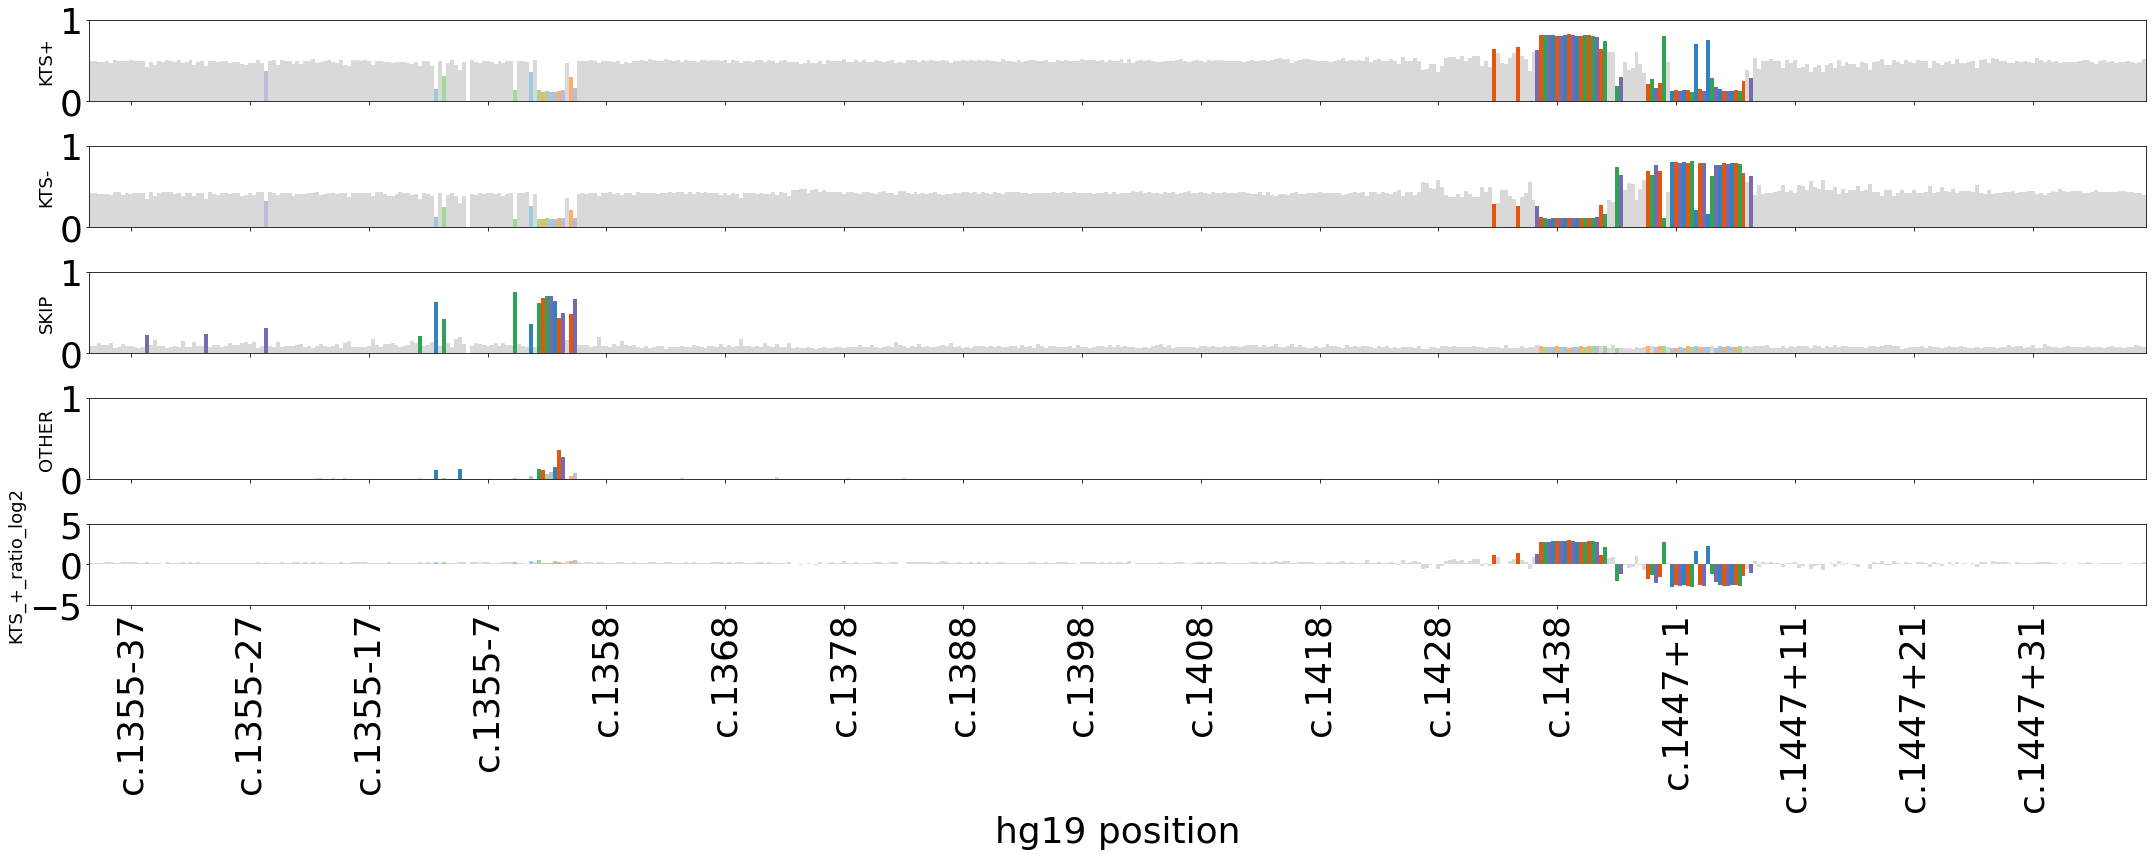

In [85]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

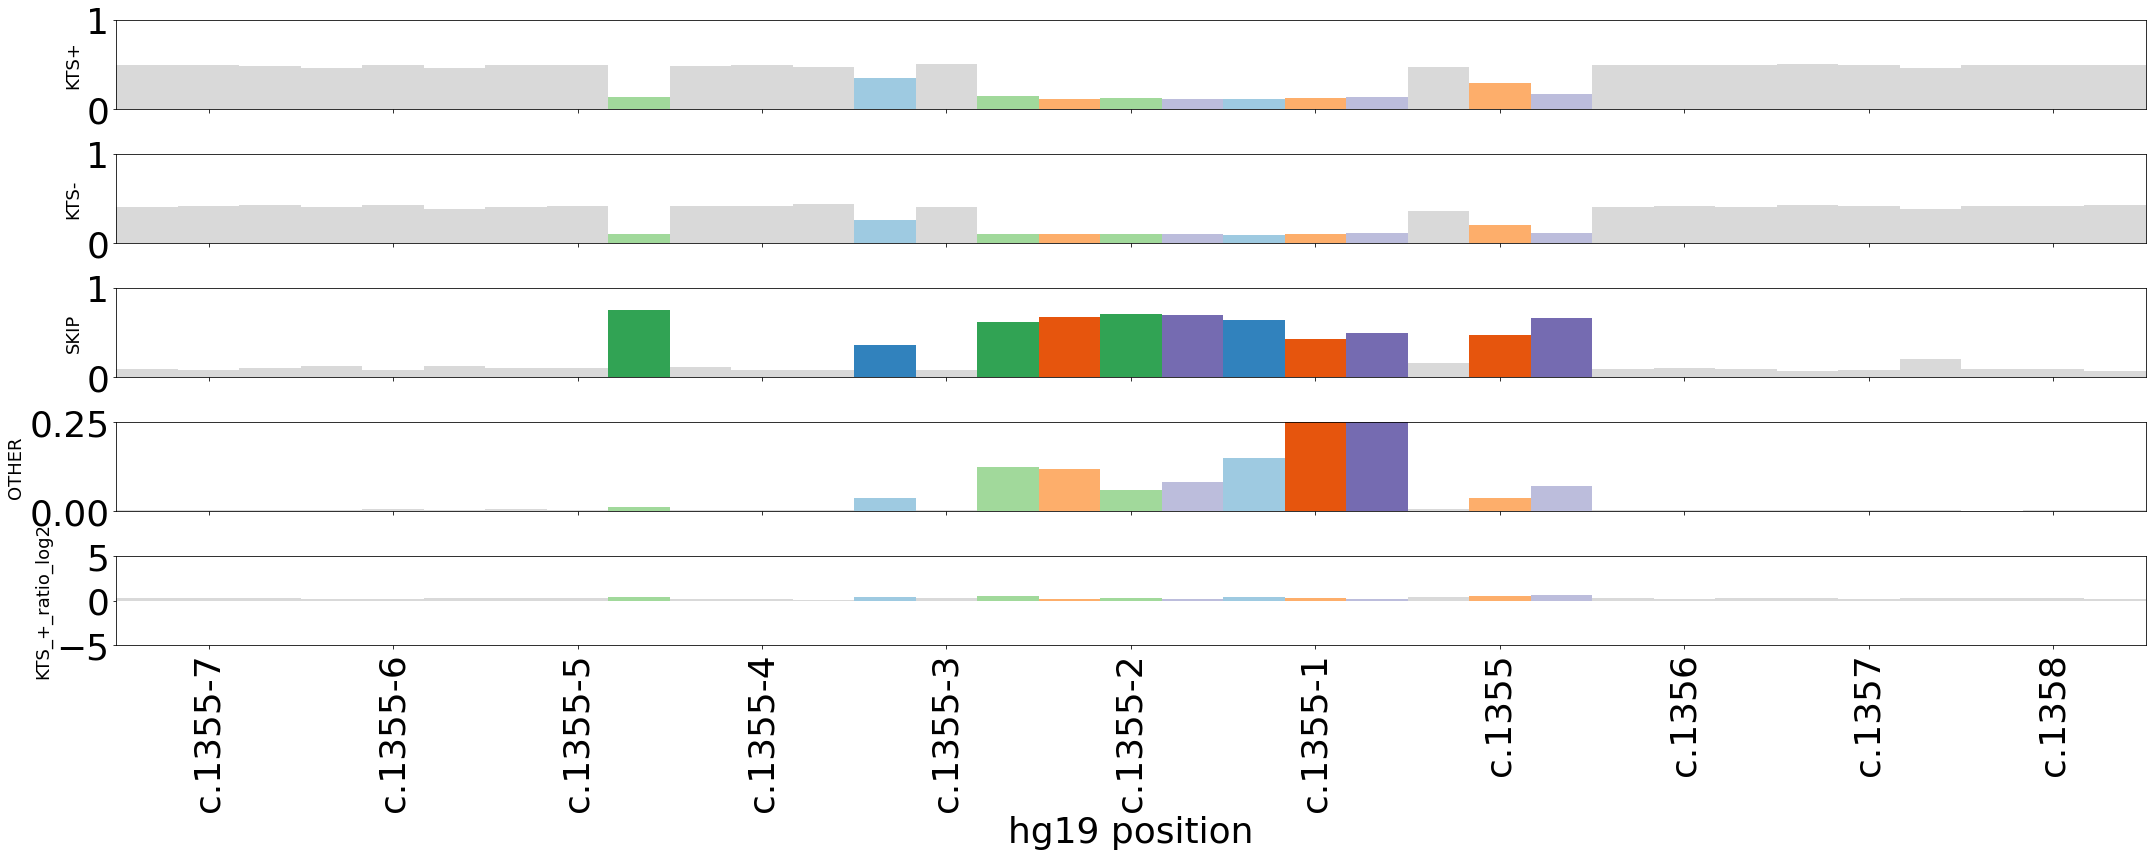

In [86]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and not 'diff'  in col  ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1260, 1270 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, .25 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and not 'diff' in col  ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

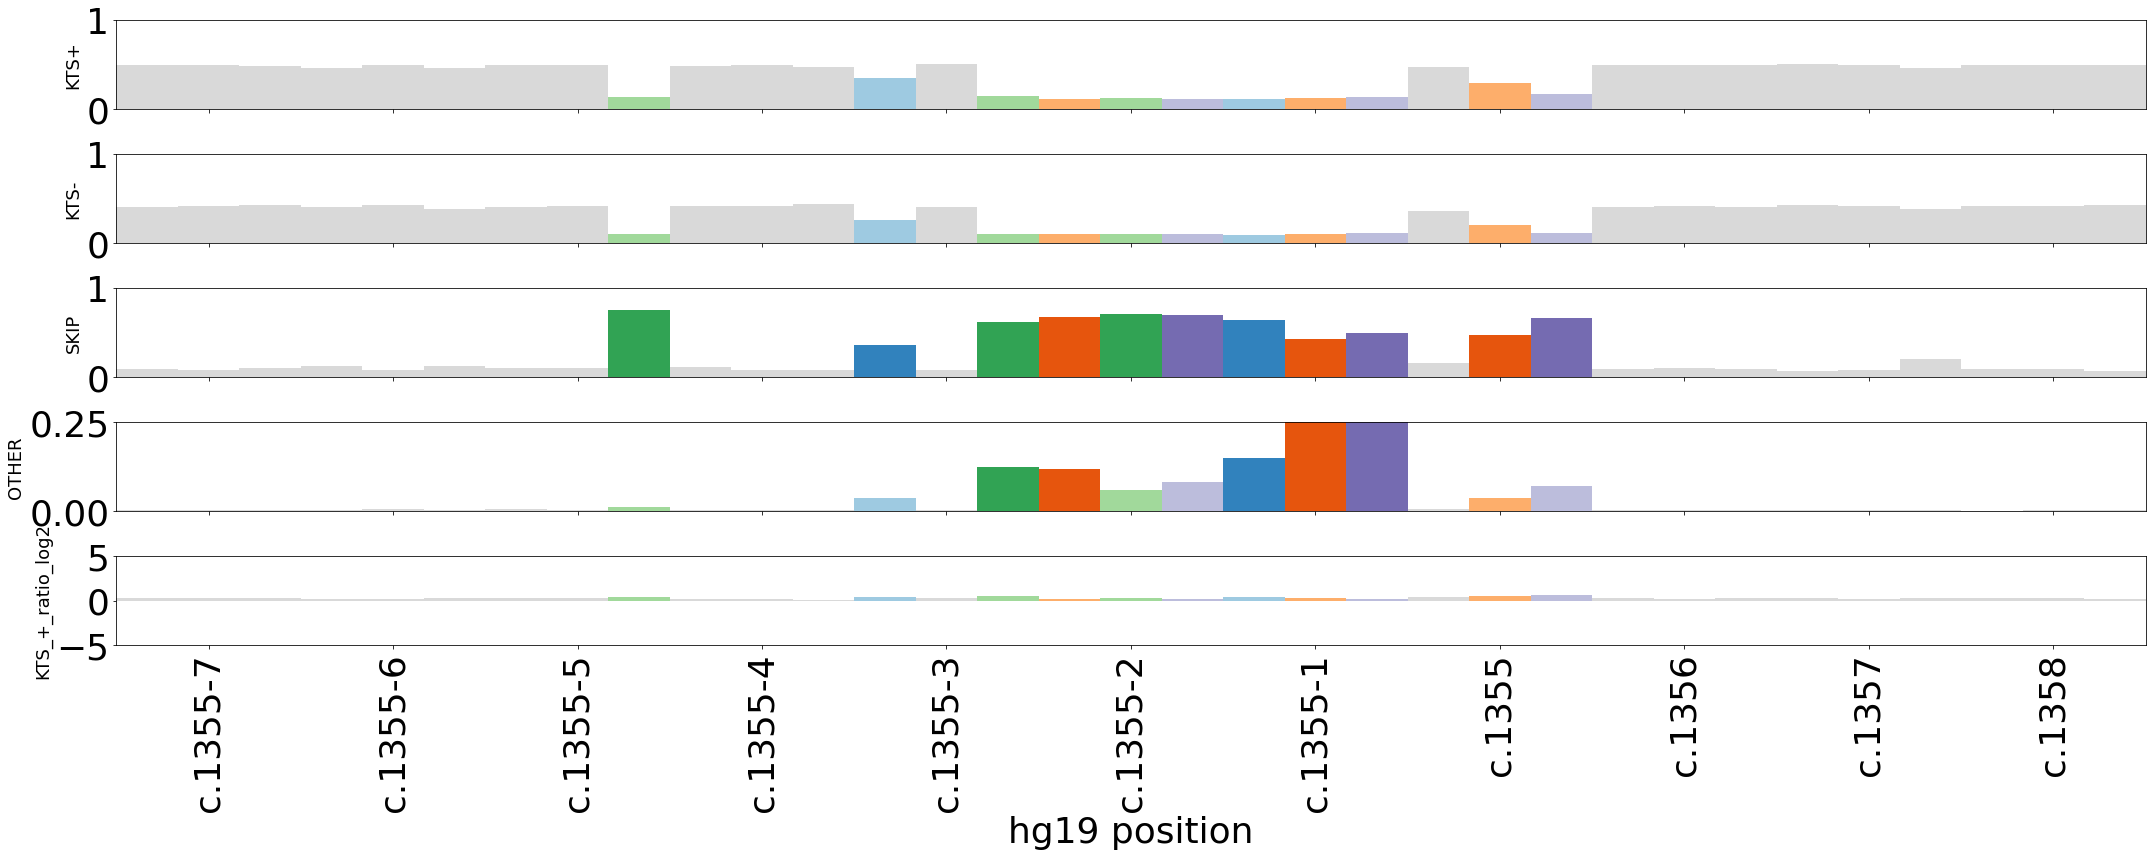

In [87]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1260, 1270 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, .25 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

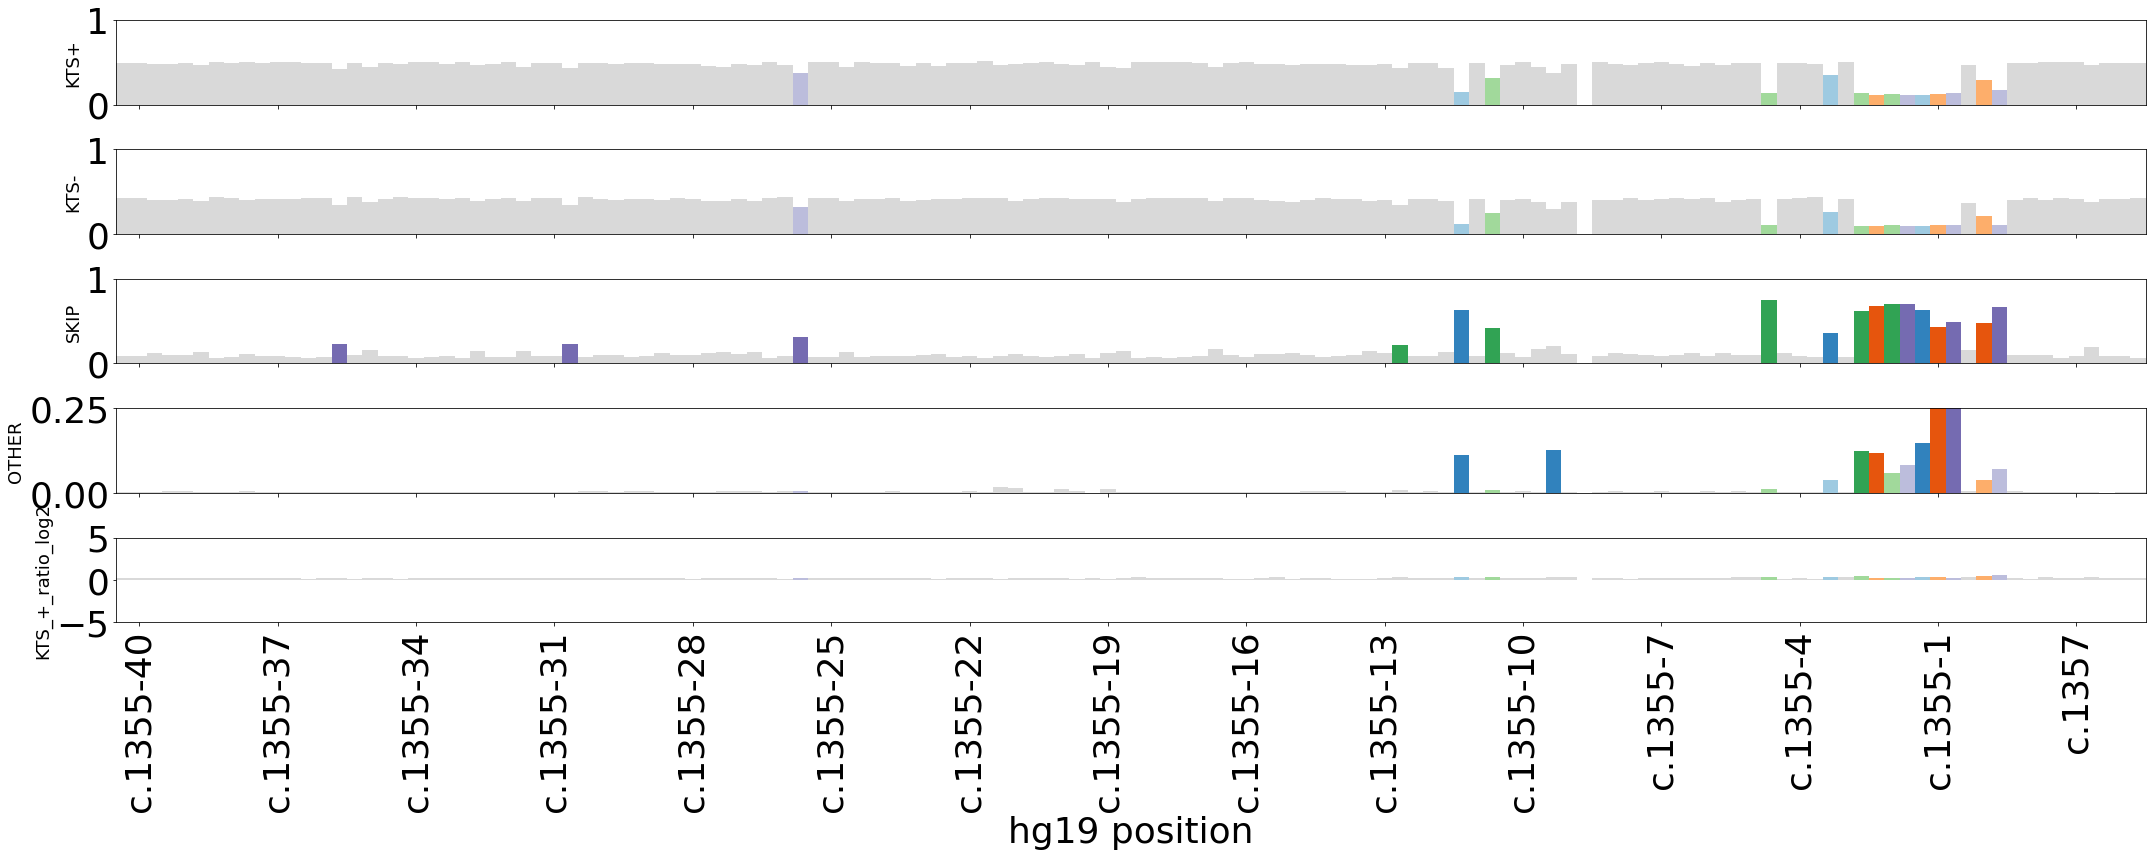

In [88]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1227, 1270 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, .25 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 3,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [89]:
byvartbl_wide_m[ 'strand' ] = '-'

In [90]:
byvartbl_wide_m[ 'chrom_chr' ] = 'chr11'

In [91]:
byvartbl_wide_m.loc[ byvartbl_wide_m.pos <= 1267 ][ [ 'varlist', 'chrom_chr', 'hg19_pos', 'strand', 'ref', 'alt' ] ].to_csv( data_in + 'branchpointer_snvs.2022-0714.txt',
                                                                                                                         sep = '\t',
                                                                                                                         index = False )

In [92]:
bench = pd.read_excel( data_in + 'leman_2020_branchpoint_benchmark.xlsx' )

In [93]:
bench = bench.loc[ bench.ID.notnull() ].copy()

In [94]:
bench

,ID,chr,strand,gene,transcript,intron,cNomen,gNomen,distSS,varType,...,MutInPBarea_LB,Delta_LB,RBPS_posA_WT,RBPS_posA_MUT,RBPS_score_WT,RBPS_score_MUT,PosPB_RBPS,ProbPBarea_RBPS,MutInPBarea_RBPS,Delta_RBPS
0,ABCC8_c.1672-20A>G,chr11,-,ABCC8,NM_000352,intron 11,c.1672-20,17452526.0,-20.0,substitution,...,Yes,-0.668440,-20.0,-20.0,94.54,40.55,c.1672-20,c.1672-22_c.1672-19,Yes,-0.571081
1,ALPL_c.793-33_793-14del,chr1,+,ALPL,NM_000478,intron 7,c.793-33_793-14,21896765.0,-19.0,del,...,Yes,-0.591928,-19.0,-26.0,94.12,58.28,c.793-19,c.793-21_c.793-18,Yes,-0.380790
2,APC_c.221-29G>C,chr5,+,APC,NM_000038,intron 3,c.221-29,112102857.0,-29.0,substitution,...,Yes,0.116212,-27.0,-25.0,74.88,75.87,c.221-27,c.221-29_c.221-26,Yes,0.013221
3,APC_c.730-29A>T,chr5,+,APC,NM_000038,intron 7,c.730-29,112136947.0,-29.0,substitution,...,No,-0.034927,-21.0,-21.0,88.97,88.04,c.730-21,c.730-23_c.730-20,No,-0.010453
4,APC_c.835-24A>T,chr5,+,APC,NM_000038,intron 8,c.835-24,112151168.0,-24.0,substitution,...,No,0.278591,-24.0,-33.0,47.96,49.77,c.835-24,c.835-26_c.835-23,Yes,0.037740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,TH_c.1198-24T>A,chr11,-,TH,NM_199292,intron 11,c.1198-24,2187017.0,-24.0,substitution,...,Yes,-0.106806,-22.0,-15.0,89.93,42.37,c.1198-22,c.1198-24_c.1198-21,Yes,-0.528856
116,TSC2_c.4760-18A>G,chr16,+,TSC2,NM_001318827,intron 36,c.4760-18,2138031.0,-18.0,substitution,...,Yes,-0.784238,-18.0,-15.0,90.38,22.39,c.4760-18,c.4760-20_c.4760-17,Yes,-0.752268
117,UROS_c.661-31T>G,chr10,-,UROS,NM_000375,intron 9,c.661-31,127477605.0,-31.0,substitution,...,No,-0.463618,-29.0,-29.0,84.09,50.63,c.661-29,c.661-31_c.661-28,Yes,-0.397907
118,VWF_c.6599-20A>T,chr12,-,VWF,NM_000552,intron 37,c.6599-20,6101204.0,-20.0,substitution,...,Yes,-0.079624,-20.0,-25.0,84.47,64.56,c.6599-20,c.6599-22_c.6599-19,Yes,-0.235705


In [95]:
bench_snvs = bench.loc[ bench.varType == 'substitution' ].copy()

In [96]:
bench_snvs[ 'ref' ] = bench_snvs.ID.apply( lambda x: x.split( '>' )[ 0 ][ -1 ] )

In [97]:
bench_snvs[ 'alt' ] = bench_snvs.ID.apply( lambda x: x.split( '>' )[ 1 ] )

In [98]:
bench_snvs.loc[ bench_snvs.strand == '-', 'ref' ] = [ css.rev_complement( r ) for r in bench_snvs.loc[ bench_snvs.strand == '-', 'ref' ] ]

In [99]:
bench_snvs.loc[ bench_snvs.strand == '-', 'alt' ] = [ css.rev_complement( a ) for a in bench_snvs.loc[ bench_snvs.strand == '-', 'alt' ] ]

In [100]:
bench_snvs[ 'gNomen' ] = [ int( g ) for g in bench_snvs.gNomen ]

In [101]:
bench_snvs[ [ 'ID', 'chr', 'gNomen', 'strand', 'ref', 'alt' ] ].to_csv( data_in + 'branchpointer_bench_snvs.2022-0721.txt',
                                                                        sep = '\t',
                                                                        index = False )

In [102]:
bench_pred = pd.read_table( data_in + 'branchpoint_bench_pred_snvs.2022-0721.txt' )

In [103]:
bench_pred[ 'ID' ] = bench_pred.id.apply( lambda x: x[ : -4 ] )

In [104]:
bench_pred[ 'gNomen' ] = bench_pred.start

In [105]:
bp_snvs = pd.read_table( data_in + 'branchpoint_pred_snvs.2022-0714.txt' )

In [106]:
#now in score_motifs!
def branchpointer_ds_scores( branchpointer_df ):
    
    bp = branchpointer_df.copy()
    
    bp_ref = bp.loc[ bp.status == 'REF' ].copy()
    
    bp_alt = bp.loc[ bp.status == 'ALT' ].copy()
    
    #to3primepoint is the key column to compare the probabilities
    idx_cols = [ 'seqnames', 'start', 'end', 'width', 'strand', 'id', 'ref_allele', 'alt_allele', 'to_3prime', 
                 'to_5prime', 'same_gene', 'exon_3prime', 'exon_5prime', 'to_3prime_point', 'to_5prime_point', 
                  'test_site', ]
    bp_m = bp_ref.set_index( idx_cols ).merge( bp_alt.set_index( idx_cols ),
                                               how = 'outer',
                                               left_index = True,
                                               right_index = True,
                                               suffixes = ( '_ref', '_alt' ) ).reset_index()
    
   
    bp_m[ 'DBP' ] = bp_m.branchpoint_prob_alt - bp_m.branchpoint_prob_ref
    
    return bp_m

In [107]:
bp_scored = branchpointer_ds_scores( bp_snvs )

In [108]:
bench_scored = branchpointer_ds_scores( bench_pred )

In [109]:
bench_scored

,seqnames,start,end,width,strand,id,ref_allele,alt_allele,to_3prime,to_5prime,...,canon_hit3_alt,canon_hit4_alt,canon_hit5_alt,ppt_start_alt,ppt_run_length_alt,branchpoint_prob_alt,U2_binding_energy_alt,ID_alt,gNomen_alt,DBP
0,chr5,112102857,112102857,1,+,APC_c.221-29G>C_pos,G,C,29,750,...,44,54,58,25,18,0.009361,1.8,APC_c.221-29G>C,112102857,0.000000
1,chr5,112136947,112136947,1,+,APC_c.730-29A>T_pos,A,T,29,8721,...,54,60,87,9,11,0.014190,3.9,APC_c.730-29A>T,112136947,0.000141
2,chr5,112151168,112151168,1,+,APC_c.835-24A>T_pos,A,T,24,14088,...,73,77,86,8,9,0.010439,2.4,APC_c.835-24A>T,112151168,0.000414
3,chr13,32890533,32890533,1,+,BRCA2_c.-39-26G>A_pos,G,A,26,729,...,64,75,100,30,13,0.008670,0.8,BRCA2_c.-39-26G>A,32890533,0.003374
4,chr13,32890523,32890523,1,+,BRCA2_c.-39-36C>G_pos,C,G,36,719,...,56,64,75,30,13,0.005296,0.8,BRCA2_c.-39-36C>G,32890523,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,chr16,23637754,23637754,1,-,PALB2_c.2587-36A>G_neg,T,C,36,2771,...,41,48,66,10,7,0.008980,0.1,PALB2_c.2587-36A>G,23637754,0.000000
2858,chr11,2187017,2187017,1,-,TH_c.1198-24T>A_neg,A,T,24,215,...,52,55,64,5,7,0.028531,4.3,TH_c.1198-24T>A,2187017,0.000000
2859,chr10,127477605,127477605,1,-,UROS_c.661-31T>G_neg,A,C,31,5844,...,61,75,86,1,16,0.012147,0.5,UROS_c.661-31T>G,127477605,0.000000
2860,chr12,6101204,6101204,1,-,VWF_c.6599-20A>T_neg,T,A,20,1824,...,92,118,136,1,16,0.017679,0.5,VWF_c.6599-20A>T,6101204,0.004258


In [110]:
alt_max = bench_scored.groupby( 'id' ).branchpoint_prob_alt.max().reset_index()

In [111]:
ref_max = bench_scored.groupby( 'id' ).branchpoint_prob_ref.max().reset_index()

In [112]:
max_branchpointer = alt_max.set_index( 'id' ).merge( ref_max.set_index( 'id' ),
                                                     left_index = True,
                                                     right_index = True,
                                                     how = 'outer' ).reset_index()

In [113]:
max_branchpointer[ 'ID' ] = max_branchpointer.id.apply( lambda x: x[ : -4 ] )

In [114]:
#now in score_motifs!
def branchpointer_ds_max( branchpointer_ds_df ):
    
    bp = branchpointer_ds_df.copy()
    
    bp[ 'DBP_abs' ] = bp.DBP.abs()
    
    ds_max = bp.groupby( [ 'id', 'start', 'ref_allele', 'alt_allele' ] ).DBP_abs.max().reset_index().copy()
    
    ds_sign = bp.loc[ bp.groupby( [ 'id', 'start', 'ref_allele', 'alt_allele' ] ).DBP.apply( lambda x: x.abs().idxmax() ) ][ [ 'id', 'start', 'ref_allele', 'alt_allele', 'DBP' ] ].copy()
    
    ds_sign = ds_sign.rename( columns = { 'DBP': 'DBP_max_signed' } )
    ds_sign[ 'DBP_event' ] = [ 'GAIN' if dbp > 0 else 'LOSS' for dbp in ds_sign.DBP_max_signed ]
    
    pos_max = bp.loc[ bp.groupby( [ 'id', 'start', 'ref_allele', 'alt_allele' ] ).DBP.apply( lambda x: x.abs().idxmax() ) ][ [ 'id', 'start', 'ref_allele', 'alt_allele', 'test_site' ] ].copy()
    
    pos_max[ 'DBP_POS_max' ] = pos_max.test_site - pos_max.start
    
    idx_cols = [ 'id', 'start', 'ref_allele', 'alt_allele' ]
    outdf = ds_max.set_index( idx_cols )[ [ 'DBP_abs' ] ].merge( ds_sign.set_index( idx_cols )[ [ 'DBP_event' ] ],
                                                                 how = 'outer',
                                                                 left_index = True,
                                                                 right_index = True )
    outdf = outdf.merge( pos_max.set_index( idx_cols )[ [ 'DBP_POS_max' ] ],
                         how = 'outer',
                         left_index = True,
                         right_index = True ).reset_index()
    
    outdf = outdf.rename( columns = { 'start': 'hg19_pos',
                                      'ref_allele': 'ref',
                                      'alt_allele': 'alt',
                                      'DBP_abs': 'DBP_max' } )
    
    return outdf

In [115]:
bp_max = branchpointer_ds_max( bp_scored )

In [116]:
bp_max

,id,hg19_pos,ref,alt,DBP_max,DBP_event,DBP_POS_max
0,jkp815:1227:C:A_neg,32413650,G,T,0.003859,GAIN,0
1,jkp815:1227:C:G_neg,32413650,G,C,0.002872,LOSS,1
2,jkp815:1227:C:T_neg,32413650,G,A,0.001522,LOSS,3
3,jkp815:1228:A:C_neg,32413649,T,G,0.005835,LOSS,0
4,jkp815:1228:A:G_neg,32413649,T,C,0.005875,LOSS,0
...,...,...,...,...,...,...,...
114,jkp815:1265:A:G_neg,32413612,T,C,0.222711,GAIN,17
115,jkp815:1265:A:T_neg,32413612,T,A,0.224818,GAIN,17
116,jkp815:1266:G:A_neg,32413611,C,T,0.070108,GAIN,20
117,jkp815:1266:G:C_neg,32413611,C,G,0.232713,GAIN,18


In [117]:
bench_max = branchpointer_ds_max( bench_scored )

In [118]:
#now in score_motifs!
def merge_branchpointer( tbl_by_var,
                         branchpointer_max_df,
                         idx_cols = [ 'hg19_pos', 'ref', 'alt' ] ):
    
    tbv = tbl_by_var.copy()
    bp = branchpointer_max_df.copy()
    
    outdf = tbv.set_index( idx_cols ).merge( bp.set_index( idx_cols )[ [ 'DBP_max', 'DBP_event', 'DBP_POS_max' ] ],
                                             how = 'outer',
                                             left_index = True,
                                             right_index = True ).reset_index()
    
    return outdf

In [119]:
byvartbl_wide_m = merge_branchpointer( byvartbl_wide_m,
                                       bp_max )

In [120]:
byvartbl_wide_m.loc[ byvartbl_wide_m.pos == 1227 ]

,hg19_pos,ref,alt,pos,chrom,ref_c,alt_c,varlist,hgvs_pos,exon_num,...,sdv_intron,intmed_exon,intmed_intron,exon,intron,strand,chrom_chr,DBP_max,DBP_event,DBP_POS_max
515,32413650,G,A,1227,11,C,T,jkp815:1227:C:T,c.1355-40,9,...,False,False,False,False,True,-,chr11,0.001522,LOSS,3.0
516,32413650,G,C,1227,11,C,G,jkp815:1227:C:G,c.1355-40,9,...,False,False,False,False,True,-,chr11,0.002872,LOSS,1.0
517,32413650,G,T,1227,11,C,A,jkp815:1227:C:A,c.1355-40,9,...,False,False,False,False,True,-,chr11,0.003859,GAIN,0.0


In [121]:
byvartbl_wide_m.loc[ byvartbl_wide_m.pos == 1267 ]

,hg19_pos,ref,alt,pos,chrom,ref_c,alt_c,varlist,hgvs_pos,exon_num,...,sdv_intron,intmed_exon,intmed_intron,exon,intron,strand,chrom_chr,DBP_max,DBP_event,DBP_POS_max
396,32413610,C,A,1267,11,G,T,jkp815:1267:G:T,c.1355,9,...,False,False,False,True,False,-,chr11,NaN,NaN,NaN
397,32413610,C,G,1267,11,G,C,jkp815:1267:G:C,c.1355,9,...,False,False,False,True,False,-,chr11,NaN,NaN,NaN
398,32413610,C,T,1267,11,G,A,jkp815:1267:G:A,c.1355,9,...,False,False,False,True,False,-,chr11,NaN,NaN,NaN


In [122]:
bench_max

,id,hg19_pos,ref,alt,DBP_max,DBP_event,DBP_POS_max
0,ABCC8_c.1672-20A>G_neg,17452526,T,C,0.829641,LOSS,0
1,APC_c.221-29G>C_pos,112102857,G,C,0.146758,LOSS,5
2,APC_c.730-29A>T_pos,112136947,A,T,0.427680,LOSS,0
3,APC_c.835-24A>T_pos,112151168,A,T,0.405232,LOSS,0
4,BRCA1_c.135-18T>G_neg,41258568,A,C,0.004009,GAIN,1
...,...,...,...,...,...,...,...
101,TH_c.1198-24T>A_neg,2187017,A,T,0.533280,LOSS,-2
102,TSC2_c.4760-18A>G_pos,2138031,A,G,0.777217,LOSS,0
103,UROS_c.661-31T>G_neg,127477605,A,C,0.498095,LOSS,-2
104,VWF_c.6599-20A>T_neg,6101204,T,A,0.711662,LOSS,0


In [123]:
bench_max[ 'ID' ] = bench_max.id.apply( lambda x: x[ :-4 ] )

In [124]:
bench_max = bench_max.rename( columns = { 'hg19_pos': 'gNomen' } )

In [125]:
idx_cols = [ 'ID', 'gNomen', 'ref', 'alt' ]

bench_snvs = bench_snvs.set_index( idx_cols ).merge( bench_max.set_index( idx_cols ),
                                                     left_index = True,
                                                     right_index = True,
                                                     how = 'outer' ).reset_index()

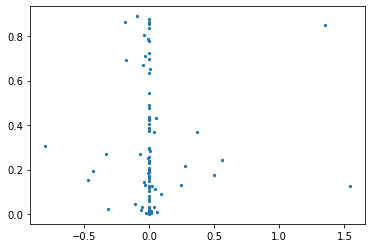

In [126]:
plt.scatter( bench_snvs.Delta_prob,
             bench_snvs.DBP_max,
             s = 5 )

In [127]:
bench_snvs = bench_snvs.set_index( 'ID' ).merge( max_branchpointer.set_index( 'ID' ),
                                                left_index = True,
                                                right_index = True,
                                                how = 'outer' ).reset_index()

In [128]:
bench_snvs

,ID,gNomen,ref,alt,chr,strand,gene,transcript,intron,cNomen,...,ProbPBarea_RBPS,MutInPBarea_RBPS,Delta_RBPS,id_x,DBP_max,DBP_event,DBP_POS_max,id_y,branchpoint_prob_alt,branchpoint_prob_ref
0,ABCC8_c.1672-20A>G,17452526,T,C,chr11,-,ABCC8,NM_000352,intron 11,c.1672-20,...,c.1672-22_c.1672-19,Yes,-0.571081,ABCC8_c.1672-20A>G_neg,0.829641,LOSS,0.0,ABCC8_c.1672-20A>G_neg,0.452051,0.859136
1,APC_c.221-29G>C,112102857,G,C,chr5,+,APC,NM_000038,intron 3,c.221-29,...,c.221-29_c.221-26,Yes,0.013221,APC_c.221-29G>C_pos,0.146758,LOSS,5.0,APC_c.221-29G>C_pos,0.726619,0.706212
2,APC_c.730-29A>T,112136947,A,T,chr5,+,APC,NM_000038,intron 7,c.730-29,...,c.730-23_c.730-20,No,-0.010453,APC_c.730-29A>T_pos,0.427680,LOSS,0.0,APC_c.730-29A>T_pos,0.718765,0.718765
3,APC_c.835-24A>T,112151168,A,T,chr5,+,APC,NM_000038,intron 8,c.835-24,...,c.835-26_c.835-23,Yes,0.037740,APC_c.835-24A>T_pos,0.405232,LOSS,0.0,APC_c.835-24A>T_pos,0.394840,0.416515
4,BRCA1_c.135-18T>G,41258568,A,C,chr17,-,BRCA1,NM_007294,intron 3,c.135-18,...,c.135-32_c.135-29,No,-0.005212,BRCA1_c.135-18T>G_neg,0.004009,GAIN,1.0,BRCA1_c.135-18T>G_neg,0.444084,0.444084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,TH_c.1198-24T>A,2187017,A,T,chr11,-,TH,NM_199292,intron 11,c.1198-24,...,c.1198-24_c.1198-21,Yes,-0.528856,TH_c.1198-24T>A_neg,0.533280,LOSS,-2.0,TH_c.1198-24T>A_neg,0.456971,0.940241
103,TSC2_c.4760-18A>G,2138031,A,G,chr16,+,TSC2,NM_001318827,intron 36,c.4760-18,...,c.4760-20_c.4760-17,Yes,-0.752268,TSC2_c.4760-18A>G_pos,0.777217,LOSS,0.0,TSC2_c.4760-18A>G_pos,0.055320,0.832537
104,UROS_c.661-31T>G,127477605,A,C,chr10,-,UROS,NM_000375,intron 9,c.661-31,...,c.661-31_c.661-28,Yes,-0.397907,UROS_c.661-31T>G_neg,0.498095,LOSS,-2.0,UROS_c.661-31T>G_neg,0.307869,0.805965
105,VWF_c.6599-20A>T,6101204,T,A,chr12,-,VWF,NM_000552,intron 37,c.6599-20,...,c.6599-22_c.6599-19,Yes,-0.235705,VWF_c.6599-20A>T_neg,0.711662,LOSS,0.0,VWF_c.6599-20A>T_neg,0.705426,0.727436


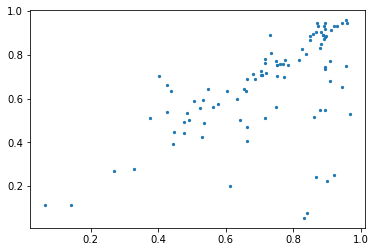

In [129]:
plt.scatter( bench_snvs.max_prob_ALT,
             bench_snvs.branchpoint_prob_alt,
             s = 5 )

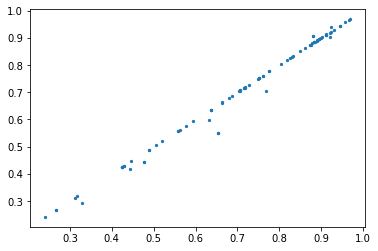

In [130]:
plt.scatter( bench_snvs.max_prob_REF,
             bench_snvs.branchpoint_prob_ref,
             s = 5 )

In [131]:
bp_wt = pd.read_table( data_in + 'branchpoint_pred_intron.2022-0714.txt' )

In [132]:
bp_wt

,seqnames,start,end,width,strand,id,to_3prime,to_5prime,same_gene,exon_3prime,...,seq_neg5,canon_hit1,canon_hit2,canon_hit3,canon_hit4,canon_hit5,ppt_start,ppt_run_length,branchpoint_prob,U2_binding_energy
1,chr11,32413628,32413654,27,-,WT1_INT89,18,584,True,ENSE00003601038.1_1,...,C,11,18,23,42,59,27,16,0.006344,1.5
2,chr11,32413628,32413654,27,-,WT1_INT89,18,584,True,ENSE00003601038.1_1,...,T,10,17,22,41,58,26,16,0.007536,1.1
3,chr11,32413628,32413654,27,-,WT1_INT89,18,584,True,ENSE00003601038.1_1,...,G,9,16,21,40,57,25,16,0.006132,2.3
4,chr11,32413628,32413654,27,-,WT1_INT89,18,584,True,ENSE00003601038.1_1,...,T,8,15,20,39,56,24,16,0.011405,0.9
5,chr11,32413628,32413654,27,-,WT1_INT89,18,584,True,ENSE00003601038.1_1,...,G,7,14,19,38,55,23,16,0.005020,0.2
6,chr11,32413628,32413654,27,-,WT1_INT89,18,584,True,ENSE00003601038.1_1,...,C,6,13,18,37,54,22,16,0.010825,1.6
7,chr11,32413628,32413654,27,-,WT1_INT89,18,584,True,ENSE00003601038.1_1,...,C,5,12,17,36,53,21,16,0.004779,2.1
8,chr11,32413628,32413654,27,-,WT1_INT89,18,584,True,ENSE00003601038.1_1,...,C,4,11,16,35,52,20,16,0.005463,2.5
9,chr11,32413628,32413654,27,-,WT1_INT89,18,584,True,ENSE00003601038.1_1,...,A,3,10,15,34,51,19,16,0.006380,2.0
10,chr11,32413628,32413654,27,-,WT1_INT89,18,584,True,ENSE00003601038.1_1,...,C,2,9,14,33,50,18,16,0.007408,0.7


In [133]:
#now in score motifs!
def merge_wt_branchpointer( tbl_by_var,
                            bp_wt,
                            tbl_by_var_merge_cols = [ 'hg19_pos' ] ):
    
    tbv = tbl_by_var.copy()
    
    bp = bp_wt.copy()
    
    bp = bp.rename( columns = { 'test_site': 'hg19_pos',
                                'branchpoint_prob': 'bp_wt_prob' } )
    
    tbv = tbv.set_index( tbl_by_var_merge_cols ).merge( bp.set_index( tbl_by_var_merge_cols )[ [ 'bp_wt_prob' ] ],
                                                        left_index = True,
                                                        right_index = True,
                                                        how = 'left' ).reset_index()
    
    return tbv

In [134]:
byvartbl_wide_m = merge_wt_branchpointer( byvartbl_wide_m,
                                          bp_wt )

In [135]:
us_int_fa = open( data_in + 'bpp_fa/wt1_ex9_us_intron.fa', 'w' )

us_int_fa.writelines( '>wt1 exon 9 US intron\n' )
us_int_fa.write( css.rev_complement( chr11_seq[ 32413610: 32414211 ].upper() ) )

us_int_fa.close()

In [136]:
for pos,r_a in zip( byvartbl_wide_m.hg19_pos, zip( byvartbl_wide_m.ref_c, byvartbl_wide_m.alt ) ):
    
    if pos <= 32413610:
        continue
        
    ref,alt = r_a
        
    assert css.rev_complement( chr11_seq[ pos - 1 ] ) == ref, 'Your reference does not match at position %i' % pos
    
    p_fa = open( data_in + 'bpp_fa/wt1_ex9_us_intron_%i:%s:%s.fa' % ( pos, ref, css.rev_complement( alt ) ), 'w' )

    p_fa.write( '>%i:%s>%s\n' % ( pos, ref, css.rev_complement( alt ) )  )
    p_fa.write( css.rev_complement( chr11_seq[ 32413610: pos - 1 ].upper() + alt + chr11_seq[ pos: 32414211 ].upper() ) )

    p_fa.close()

In [137]:
chr2 = '/nfs/kitzman3/lab_common/refs/human/ucsc_hg19/bychrom/chr2.fa'
chr2_seq = pp.get_refseq( chr2 )[ 0 ]

In [138]:
msh2_wt_fa = open( data_in + 'bpp_fa/msh2_intron_10.fa', 'w' )

msh2_wt_fa.writelines( '>msh2 exon 11 US intron\n' )
msh2_wt_fa.write( chr2_seq[ 47693947: 47698103 ].upper() )

msh2_wt_fa.close()

In [139]:
msh2_var_fa = open( data_in + 'bpp_fa/msh2_intron_10_47698061:C:T.fa', 'w' )

msh2_var_fa.writelines( '>47698061:C>T\n' )
msh2_var_fa.write( chr2_seq[ 47693947: 47698060 ].upper() + 'T' + chr2_seq[ 47698061: 47698103 ].upper() )

msh2_var_fa.close()

In [140]:
mlh1_df = bench_snvs.loc[ bench_snvs.gene == 'MLH1' ].copy()

In [141]:
mlh1_df

,ID,gNomen,ref,alt,chr,strand,gene,transcript,intron,cNomen,...,ProbPBarea_RBPS,MutInPBarea_RBPS,Delta_RBPS,id_x,DBP_max,DBP_event,DBP_POS_max,id_y,branchpoint_prob_alt,branchpoint_prob_ref
79,MLH1_c.1559-36C>T,37081641,C,T,chr3,+,MLH1,NM_000249,intron 13,c.1559-36,...,c.1559-35_c.1559-32,No,-0.009974,MLH1_c.1559-36C>T_pos,0.190171,LOSS,3.0,MLH1_c.1559-36C>T_pos,0.471834,0.662006
80,MLH1_c.1668-19A>G,37083740,A,G,chr3,+,MLH1,NM_000249,intron 14,c.1668-19,...,c.1668-27_c.1668-24,No,0.035037,MLH1_c.1668-19A>G_pos,0.477092,LOSS,0.0,MLH1_c.1668-19A>G_pos,0.890204,0.890204
81,MLH1_c.1732-19T>A,37088991,T,A,chr3,+,MLH1,NM_000249,intron 15,c.1732-19,...,c.1732-36_c.1732-33,No,0.873144,MLH1_c.1732-19T>A_pos,0.380829,LOSS,-15.0,MLH1_c.1732-19T>A_pos,0.539240,0.425314
82,MLH1_c.1732-19T>C,37088991,T,C,chr3,+,MLH1,NM_000249,intron 15,c.1732-19,...,c.1732-36_c.1732-33,No,0.230349,MLH1_c.1732-19T>C_pos,0.238197,GAIN,-1.0,MLH1_c.1732-19T>C_pos,0.663511,0.425314
83,MLH1_c.1732-22T>C,37088988,T,C,chr3,+,MLH1,NM_000249,intron 15,c.1732-22,...,c.1732-36_c.1732-33,No,0.241485,MLH1_c.1732-22T>C_pos,0.241567,LOSS,2.0,MLH1_c.1732-22T>C_pos,0.406904,0.425314
84,MLH1_c.1732-38G>A,37088972,G,A,chr3,+,MLH1,NM_000249,intron 15,c.1732-38,...,c.1732-36_c.1732-33,No,0.134061,MLH1_c.1732-38G>A_pos,0.128870,GAIN,0.0,MLH1_c.1732-38G>A_pos,0.425314,0.425314
85,MLH1_c.1897-34T>C,37089974,T,C,chr3,+,MLH1,NM_000249,intron 16,c.1897-34,...,c.1897-40_c.1897-37,No,-0.098398,MLH1_c.1897-34T>C_pos,0.081612,GAIN,-1.0,MLH1_c.1897-34T>C_pos,0.587297,0.505685
86,MLH1_c.307-19A>G,37045873,A,G,chr3,+,MLH1,NM_000249,intron 3,c.307-19,...,c.307-26_c.307-23,No,0.041536,MLH1_c.307-19A>G_pos,0.101426,LOSS,0.0,MLH1_c.307-19A>G_pos,0.781699,0.716684
87,MLH1_c.307-29C>A,37045863,C,A,chr3,+,MLH1,NM_000249,intron 3,c.307-29,...,c.307-26_c.307-23,No,-0.016359,MLH1_c.307-29C>A_pos,0.636059,GAIN,0.0,MLH1_c.307-29C>A_pos,0.760478,0.716684
88,MLH1_c.381-43C>G,37048439,C,G,chr3,+,MLH1,NM_000249,intron 4,c.381-43,...,c.381-24_c.381-21,No,0.002017,MLH1_c.381-43C>G_pos,0.002879,LOSS,2.0,MLH1_c.381-43C>G_pos,0.703695,0.703695


In [142]:
chr3 = '/nfs/kitzman3/lab_common/refs/human/ucsc_hg19/bychrom/chr3.fa'
chr3_seq = pp.get_refseq( chr3 )[ 0 ]

In [143]:
mlh1_wt_fa = open( data_in + 'bpp_fa/mlh1_intron_15.fa', 'w' )

mlh1_wt_fa.writelines( '>mlh1 exon 12 US intron\n' )
mlh1_wt_fa.write( chr3_seq[ 37083822: 37089009 ].upper() ) 

mlh1_wt_fa.close()

In [144]:
mlh1_df[ 'ref' ] = mlh1_df.ID.apply( lambda x: x.split( '>' )[ 0 ][ -1 ] )

In [145]:
#indel giving me bugs
mlh1_df = mlh1_df.loc[ mlh1_df.intron != 'intron 1' ].copy()

In [146]:
mlh1_df[ 'alt' ] = mlh1_df.ID.apply( lambda x: x.split( '>' )[ 1 ] )

In [147]:
mlh1_df[ 'hg19_pos' ] = [ int( g ) for g in mlh1_df.gNomen ]

In [148]:
for pos,r_a in zip( mlh1_df.hg19_pos, zip( mlh1_df.ref, mlh1_df.alt ) ):
    
    if pos <= 37083822 or pos > 37089009:
        continue
        
    ref,alt = r_a
        
    assert chr3_seq[ pos - 1 ].upper() == ref, 'Your reference does not match at position %i' % pos
    
    p_fa = open( data_in + 'bpp_fa/mlh1_ex12_us_intron_%i:%s:%s.fa' % ( pos, ref, alt ), 'w' )

    p_fa.write( '>%i:%s>%s\n' % ( pos, ref, alt )  )
    p_fa.write( chr3_seq[ 37083822: pos - 1 ].upper() + alt + chr3_seq[ pos: 37089009 ].upper() )

    p_fa.close()

In [149]:
#since this needed python 2 - even though it said it didn't - ran this in command line
#r 0 means to report all the sites available instead of top hit

#check out /nfs/kitzman2/smithcat/proj/msh2_2022/scripts/bpp_allvar-2022-0718.txt to run this command in a loop

! python {bpp_dir}BP_PPT.py -b {bpp_dir}demo/pwmBP_human.txt \
                            -p {bpp_dir}demo/scPPT_human.txt \
                            -i {data_in}wt1_ex9_us_intron.fa \
                            -r 0 > {data_in}bpp_pred.txt

python: can't open file '{bpp_dir}BP_PPT.py': [Errno 2] No such file or directory


In [150]:
#don't want wt1 WT or msh2 in here
bpp_files = ! ls {data_in}bpp_pred/*_wt1_*:*.txt

In [151]:
bpp_in_fn = { file.split( '/' )[ -1 ].split( '_' )[ -1 ].split( '.' )[ 0 ]: pd.read_table( file )
               for file in bpp_files }

In [152]:
bpp_wt = pd.read_table( data_in + 'bpp_pred/bpp_pred_wt1_ex9_us_intron.txt' )

In [153]:
bpp_wt

,#id,bps,bp_pos,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc
0,>wt1 exon 9 US intron,GGCCGAG,26,1.150747e-03,0.010405,1.197331e-05,4.027388,1.166687,4.683750
1,>wt1 exon 9 US intron,AGGCTAG,21,6.148784e-05,0.010378,6.381347e-07,-0.076325,1.161075,0.036819
2,>wt1 exon 9 US intron,ACCTTCT,14,8.120149e-10,0.000057,4.644607e-14,-0.307974,-1.017178,-0.224789
3,>wt1 exon 9 US intron,GCTAGAC,19,3.254599e-15,0.006529,2.125078e-17,-0.307977,0.348793,-0.224789
4,>wt1 exon 9 US intron,AGACCTT,16,1.130863e-16,0.002113,2.390039e-19,-0.307977,-0.583203,-0.224789
5,>wt1 exon 9 US intron,GACCTTC,15,4.669835e-16,0.000352,1.641604e-19,-0.307977,-0.955059,-0.224789
6,>wt1 exon 9 US intron,GGCTAGA,20,3.897944e-20,0.010049,3.917068e-22,-0.307977,1.091604,-0.224789
7,>wt1 exon 9 US intron,CGAGGCT,23,4.976492e-22,0.010405,5.177800e-24,-0.307977,1.166623,-0.224789
8,>wt1 exon 9 US intron,CTAGACC,18,6.631742e-22,0.005672,3.761527e-24,-0.307977,0.167827,-0.224789
9,>wt1 exon 9 US intron,GGGCCGA,27,6.373542e-23,0.010405,6.631583e-25,-0.307977,1.166696,-0.224789


In [154]:
bpp_in_fn[ '32413650:C:T' ]

,#id,bps,bp_pos,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc
0,>32413650:C>T,GGCCGAG,26,1.150747e-03,0.010405,1.197331e-05,4.027388,1.166687,4.683750
1,>32413650:C>T,AGGCTAG,21,6.148784e-05,0.010378,6.381347e-07,-0.076325,1.161075,0.036819
2,>32413650:C>T,ACCTTCT,14,8.120149e-10,0.000057,4.644607e-14,-0.307974,-1.017178,-0.224789
3,>32413650:C>T,GCTAGAC,19,3.254599e-15,0.006529,2.125078e-17,-0.307977,0.348793,-0.224789
4,>32413650:C>T,AGACCTT,16,1.130863e-16,0.002113,2.390039e-19,-0.307977,-0.583203,-0.224789
5,>32413650:C>T,GACCTTC,15,4.669835e-16,0.000352,1.641604e-19,-0.307977,-0.955059,-0.224789
6,>32413650:C>T,GGCTAGA,20,3.897944e-20,0.010049,3.917068e-22,-0.307977,1.091604,-0.224789
7,>32413650:C>T,CGAGGCT,23,4.976492e-22,0.010405,5.177800e-24,-0.307977,1.166623,-0.224789
8,>32413650:C>T,CTAGACC,18,6.631742e-22,0.005672,3.761527e-24,-0.307977,0.167827,-0.224789
9,>32413650:C>T,GGGCCGA,27,6.373542e-23,0.010405,6.631583e-25,-0.307977,1.166696,-0.224789


In [155]:
bpp_msh2_wt = pd.read_table( data_in + 'bpp_pred/bpp_pred_msh2_intron_10.txt' )

In [156]:
bpp_msh2_var = pd.read_table( data_in + 'bpp_pred/bpp_pred_msh2_intron_10_47698061:C:T.txt' )

In [157]:
bpp_mlh1_wt = pd.read_table( data_in + 'bpp_pred/bpp_pred_mlh1_intron_15.txt' )

In [158]:
#don't want wt1 WT or msh2 in here
bpp_mlh1_files = ! ls {data_in}bpp_pred/*_mlh1_*:*.txt

In [159]:
bpp_in_mlh1_fn = { file.split( '/' )[ -1 ].split( '_' )[ -1 ].split( '.' )[ 0 ]: pd.read_table( file )
                   for file in bpp_mlh1_files }

In [160]:
#now in score_motifs!
def comb_bpp_scores( bpp_fn,
                     bpp_wt,
                     rev_strand = False ):
    
    merged_files = []
    
    idx_cols = [ 'bp_pos' ]
    
    for bpp_df in bpp_fn.values():
        
        bpp_df[ 'hg19_pos' ] = bpp_df[ '#id' ].apply( lambda x: int( x[ 1: ].split( ':' )[ 0 ] ) )
        bpp_df[ 'ref' + rev_strand*'_c' ] = bpp_df[ '#id' ].apply( lambda x: x.split( ':' )[ 1 ].split( '>' )[ 0 ] )
        bpp_df[ 'alt' + rev_strand*'_c' ] = bpp_df[ '#id' ].apply( lambda x: x.split( ':' )[ 1 ].split( '>' )[ 1 ] )
        
        merged_files.append( bpp_df.set_index( idx_cols ).merge( bpp_wt.set_index( idx_cols )[ [ 'sc_bps', 'sc_ppt', 'sc', 'zsc_bps', 'zsc_ppt', 'zsc' ] ],
                                                                 left_index = True,
                                                                 right_index = True,
                                                                 how = 'outer',
                                                                 suffixes = ( '', '_wt' ) ).reset_index() )
        
    allvar_bpp = pd.concat( merged_files,
                             ignore_index = True )
    
    for col in [ 'zsc_bps', 'zsc_ppt', 'zsc' ]:
        
        allvar_bpp[ 'DS_' + col ] = allvar_bpp[ col ] - allvar_bpp[ col + '_wt' ]
        
    return allvar_bpp

In [161]:
allvar_bpp = comb_bpp_scores( bpp_in_fn,
                              bpp_wt,
                              rev_strand = True )

In [162]:
allvar_bpp

,bp_pos,#id,bps,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc,hg19_pos,...,alt_c,sc_bps_wt,sc_ppt_wt,sc_wt,zsc_bps_wt,zsc_ppt_wt,zsc_wt,DS_zsc_bps,DS_zsc_ppt,DS_zsc
0,26,>32413611:G>A,GGCCGAG,1.150747e-03,0.010405,1.197331e-05,4.027388,1.166687,4.683750,32413611.0,...,A,1.150747e-03,0.010405,1.197331e-05,4.027388,1.166687,4.683750,0.0,0.0,0.0
1,21,>32413611:G>A,AGGCTAG,6.148784e-05,0.010378,6.381347e-07,-0.076325,1.161075,0.036819,32413611.0,...,A,6.148784e-05,0.010378,6.381347e-07,-0.076325,1.161075,0.036819,0.0,0.0,0.0
2,14,>32413611:G>A,ACCTTCT,8.120149e-10,0.000057,4.644607e-14,-0.307974,-1.017178,-0.224789,32413611.0,...,A,8.120149e-10,0.000057,4.644607e-14,-0.307974,-1.017178,-0.224789,0.0,0.0,0.0
3,19,>32413611:G>A,GCTAGAC,3.254599e-15,0.006529,2.125078e-17,-0.307977,0.348793,-0.224789,32413611.0,...,A,3.254599e-15,0.006529,2.125078e-17,-0.307977,0.348793,-0.224789,0.0,0.0,0.0
4,16,>32413611:G>A,AGACCTT,1.130863e-16,0.002113,2.390039e-19,-0.307977,-0.583203,-0.224789,32413611.0,...,A,1.130863e-16,0.002113,2.390039e-19,-0.307977,-0.583203,-0.224789,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2762,10,>32413650:C>T,TCTCTGT,6.322211e-23,0.000000,0.000000e+00,-0.307977,-1.029250,-0.224789,32413650.0,...,T,6.322211e-23,0.000000,0.000000e+00,-0.307977,-1.029250,-0.224789,0.0,0.0,0.0
2763,9,>32413650:C>T,CTCTGTC,6.236400e-14,0.000000,0.000000e+00,-0.307977,-1.029250,-0.224789,32413650.0,...,T,6.236400e-14,0.000000,0.000000e+00,-0.307977,-1.029250,-0.224789,0.0,0.0,0.0
2764,8,>32413650:C>T,TCTGTCC,1.046059e-22,0.000000,0.000000e+00,-0.307977,-1.029250,-0.224789,32413650.0,...,T,1.046059e-22,0.000000,0.000000e+00,-0.307977,-1.029250,-0.224789,0.0,0.0,0.0
2765,7,>32413650:C>T,CTGTCCA,1.586298e-10,0.000000,0.000000e+00,-0.307976,-1.029250,-0.224789,32413650.0,...,T,1.586298e-10,0.000000,0.000000e+00,-0.307976,-1.029250,-0.224789,0.0,0.0,0.0


In [163]:
msh2_bpp = comb_bpp_scores( { 'msh2_var': bpp_msh2_var },
                              bpp_msh2_wt, )

In [164]:
msh2_bpp

,bp_pos,#id,bps,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc,hg19_pos,...,alt,sc_bps_wt,sc_ppt_wt,sc_wt,zsc_bps_wt,zsc_ppt_wt,zsc_wt,DS_zsc_bps,DS_zsc_ppt,DS_zsc
0,6,>47698061:C>T,TCGATTT,4.276194e-29,0.000000,0.000000e+00,-0.275084,-1.187714,-0.235030,47698061,...,T,4.276194e-29,0.000000,0.000000e+00,-0.275084,-1.190635,-0.235027,1.201000e-09,0.002920,-0.000003
1,7,>47698061:C>T,TTCGATT,7.918545e-27,0.000000,0.000000e+00,-0.275084,-1.187714,-0.235030,47698061,...,T,7.918545e-27,0.000000,0.000000e+00,-0.275084,-1.190635,-0.235027,1.201000e-09,0.002920,-0.000003
2,8,>47698061:C>T,TTTCGAT,1.286314e-03,0.000000,0.000000e+00,-0.202193,-1.187714,-0.235030,47698061,...,T,1.286314e-03,0.000000,0.000000e+00,-0.202193,-1.190635,-0.235027,1.179000e-09,0.002920,-0.000003
3,9,>47698061:C>T,ATTTCGA,1.861500e-21,0.000000,0.000000e+00,-0.275084,-1.187714,-0.235030,47698061,...,T,1.861500e-21,0.000000,0.000000e+00,-0.275084,-1.190635,-0.235027,1.201000e-09,0.002920,-0.000003
4,10,>47698061:C>T,TATTTCG,9.433587e-11,0.000000,0.000000e+00,-0.275083,-1.187714,-0.235030,47698061,...,T,9.433587e-11,0.000000,0.000000e+00,-0.275083,-1.190635,-0.235027,1.201000e-09,0.002920,-0.000003
5,11,>47698061:C>T,TTATTTC,2.805586e-15,0.000000,0.000000e+00,-0.275084,-1.187714,-0.235030,47698061,...,T,2.805586e-15,0.000000,0.000000e+00,-0.275084,-1.190635,-0.235027,1.201000e-09,0.002920,-0.000003
6,12,>47698061:C>T,GTTATTT,3.818653e-29,0.000000,0.000000e+00,-0.275084,-1.187714,-0.235030,47698061,...,T,3.818653e-29,0.000000,0.000000e+00,-0.275084,-1.190635,-0.235027,1.201000e-09,0.002920,-0.000003
7,13,>47698061:C>T,TGTTATT,2.540949e-14,0.000000,0.000000e+00,-0.275084,-1.187714,-0.235030,47698061,...,T,2.540949e-14,0.000000,0.000000e+00,-0.275084,-1.190635,-0.235027,1.201000e-09,0.002920,-0.000003
8,14,>47698061:C>T,CTGTTAT,9.630213e-03,0.000016,1.553082e-07,0.270621,-1.180428,-0.231666,47698061,...,T,9.630213e-03,0.000016,1.553082e-07,0.270621,-1.183236,-0.231663,1.033000e-09,0.002808,-0.000003
9,15,>47698061:C>T,ACTGTTA,1.669733e-28,0.000031,5.221056e-33,-0.275084,-1.173587,-0.235030,47698061,...,T,1.669733e-28,0.000031,5.221056e-33,-0.275084,-1.176290,-0.235027,1.201000e-09,0.002703,-0.000003


In [165]:
mlh1_bpp = comb_bpp_scores(   bpp_in_mlh1_fn,
                              bpp_mlh1_wt, )

In [166]:
#now in score_motifs!
def bpp_ds_max( bpp_ds_df,
                first_ex_bp,
                zcols = [ 'DS_zsc_bps', 'DS_zsc_ppt', 'DS_zsc' ],
                rev_strand = False ):
    
    bpp = bpp_ds_df.copy()
    
    idx_cols = [ '#id', 'ref' + rev_strand*'_c', 'alt' + rev_strand*'_c' ]
    
    for col in zcols:
        
        bpp[ col + '_abs' ] = bpp[ col ].abs()
    
    ds_max = bpp.groupby( idx_cols + [ 'hg19_pos' ] )[ [ col + '_abs' for col in zcols ] ].max().reset_index().copy()
    
    ds_sign = bpp.groupby( idx_cols )[ zcols ].apply( lambda x: x.abs().idxmax() ).reset_index().copy()

    for col in zcols:
        
        ds_sign[ col + '_max' ] = bpp.loc[ ds_sign[ col ], col ].tolist()
    
    pos_max = bpp.groupby( idx_cols )[ zcols ].apply( lambda x: x.abs().idxmax() ).reset_index().copy()
    
    for col in zcols:
        
        pos_max[ col + 'bp_pos' ] = bpp.loc[ pos_max[ col ] ].bp_pos.tolist()
        pos_max[ col + 'hg19_pos' ] = bpp.loc[ pos_max[ col ] ].hg19_pos.tolist()
        
        pos_max[ col + '_POS_max' ] = ( first_ex_bp - ( 1 + -2*rev_strand )*pos_max[ col + 'bp_pos' ] ) - pos_max[ col + 'hg19_pos' ]                                                                                                                                         
    

    outdf = ds_max.set_index( idx_cols )[ [ 'hg19_pos' ] ].merge( ds_sign.set_index( idx_cols )[ [ col + '_max' for col in zcols ] ],
                                                                  how = 'outer',
                                                                  left_index = True,
                                                                  right_index = True )
    
    outdf = outdf.merge( pos_max.set_index( idx_cols )[ [ col + '_POS_max' for col in zcols ] ],
                         how = 'outer',
                         left_index = True,
                         right_index = True ).reset_index()

    return outdf

In [167]:
bpp_max = bpp_ds_max( allvar_bpp,
                      32413610,
                      rev_strand = True )

In [168]:
bpp_max

,#id,ref_c,alt_c,hg19_pos,DS_zsc_bps_max,DS_zsc_ppt_max,DS_zsc_max,DS_zsc_bps_POS_max,DS_zsc_ppt_POS_max,DS_zsc_POS_max
0,>32413611:G>A,G,A,32413611.0,0.0,0.0,0.0,25.0,25.0,25.0
1,>32413611:G>C,G,C,32413611.0,0.0,0.0,0.0,25.0,25.0,25.0
2,>32413611:G>T,G,T,32413611.0,0.0,0.0,0.0,25.0,25.0,25.0
3,>32413612:A>C,A,C,32413612.0,0.0,0.0,0.0,24.0,24.0,24.0
4,>32413612:A>G,A,G,32413612.0,0.0,0.0,0.0,24.0,24.0,24.0
...,...,...,...,...,...,...,...,...,...,...
114,>32413649:A>G,A,G,32413649.0,0.0,0.0,0.0,-13.0,-13.0,-13.0
115,>32413649:A>T,A,T,32413649.0,0.0,0.0,0.0,-13.0,-13.0,-13.0
116,>32413650:C>A,C,A,32413650.0,0.0,0.0,0.0,-14.0,-14.0,-14.0
117,>32413650:C>G,C,G,32413650.0,0.0,0.0,0.0,-14.0,-14.0,-14.0


In [169]:
bpp_msh2_max = bpp_ds_max( msh2_bpp,
                           47698104, )

In [170]:
msh2_bpp

,bp_pos,#id,bps,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc,hg19_pos,...,alt,sc_bps_wt,sc_ppt_wt,sc_wt,zsc_bps_wt,zsc_ppt_wt,zsc_wt,DS_zsc_bps,DS_zsc_ppt,DS_zsc
0,6,>47698061:C>T,TCGATTT,4.276194e-29,0.000000,0.000000e+00,-0.275084,-1.187714,-0.235030,47698061,...,T,4.276194e-29,0.000000,0.000000e+00,-0.275084,-1.190635,-0.235027,1.201000e-09,0.002920,-0.000003
1,7,>47698061:C>T,TTCGATT,7.918545e-27,0.000000,0.000000e+00,-0.275084,-1.187714,-0.235030,47698061,...,T,7.918545e-27,0.000000,0.000000e+00,-0.275084,-1.190635,-0.235027,1.201000e-09,0.002920,-0.000003
2,8,>47698061:C>T,TTTCGAT,1.286314e-03,0.000000,0.000000e+00,-0.202193,-1.187714,-0.235030,47698061,...,T,1.286314e-03,0.000000,0.000000e+00,-0.202193,-1.190635,-0.235027,1.179000e-09,0.002920,-0.000003
3,9,>47698061:C>T,ATTTCGA,1.861500e-21,0.000000,0.000000e+00,-0.275084,-1.187714,-0.235030,47698061,...,T,1.861500e-21,0.000000,0.000000e+00,-0.275084,-1.190635,-0.235027,1.201000e-09,0.002920,-0.000003
4,10,>47698061:C>T,TATTTCG,9.433587e-11,0.000000,0.000000e+00,-0.275083,-1.187714,-0.235030,47698061,...,T,9.433587e-11,0.000000,0.000000e+00,-0.275083,-1.190635,-0.235027,1.201000e-09,0.002920,-0.000003
5,11,>47698061:C>T,TTATTTC,2.805586e-15,0.000000,0.000000e+00,-0.275084,-1.187714,-0.235030,47698061,...,T,2.805586e-15,0.000000,0.000000e+00,-0.275084,-1.190635,-0.235027,1.201000e-09,0.002920,-0.000003
6,12,>47698061:C>T,GTTATTT,3.818653e-29,0.000000,0.000000e+00,-0.275084,-1.187714,-0.235030,47698061,...,T,3.818653e-29,0.000000,0.000000e+00,-0.275084,-1.190635,-0.235027,1.201000e-09,0.002920,-0.000003
7,13,>47698061:C>T,TGTTATT,2.540949e-14,0.000000,0.000000e+00,-0.275084,-1.187714,-0.235030,47698061,...,T,2.540949e-14,0.000000,0.000000e+00,-0.275084,-1.190635,-0.235027,1.201000e-09,0.002920,-0.000003
8,14,>47698061:C>T,CTGTTAT,9.630213e-03,0.000016,1.553082e-07,0.270621,-1.180428,-0.231666,47698061,...,T,9.630213e-03,0.000016,1.553082e-07,0.270621,-1.183236,-0.231663,1.033000e-09,0.002808,-0.000003
9,15,>47698061:C>T,ACTGTTA,1.669733e-28,0.000031,5.221056e-33,-0.275084,-1.173587,-0.235030,47698061,...,T,1.669733e-28,0.000031,5.221056e-33,-0.275084,-1.176290,-0.235027,1.201000e-09,0.002703,-0.000003


In [171]:
bpp_mlh1_max = bpp_ds_max( mlh1_bpp,
                           37089010, )

In [172]:
bench_snvs[ 'Delta_BPP_cs' ] = bench_snvs.zsc_MUT - bench_snvs.zsc_WT

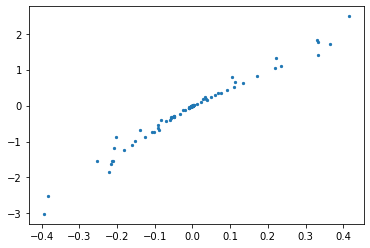

In [173]:
plt.scatter( bench_snvs.Delta_BPP,
             bench_snvs.Delta_BPP_cs,
             s = 5 )

In [174]:
bench_snvs[ 'Delta_BPP_cs_div10' ] = ( bench_snvs.zsc_MUT - bench_snvs.zsc_WT ) / 10

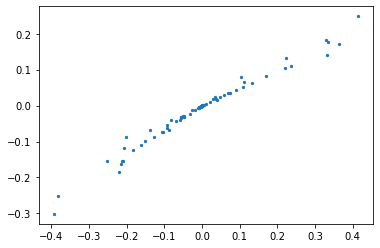

In [175]:
plt.scatter( bench_snvs.Delta_BPP,
             bench_snvs.Delta_BPP_cs_div10,
             s = 5 )

In [176]:
bpp_msh2_wt.loc[ bpp_msh2_wt.bps == 'TTTTAAT' ]

,#id,bps,bp_pos,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc
0,>msh2 exon 11 US intron,TTTTAAT,34,0.07897,0.003714,0.000293,4.199813,0.512994,6.117665
1,>msh2 exon 11 US intron,TTTTAAT,25,0.07897,0.001546,0.000122,4.199813,-0.481305,2.410006


In [177]:
msh2_bpp.loc[ msh2_bpp.bps == 'TTTTAAT' ]

,bp_pos,#id,bps,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc,hg19_pos,...,alt,sc_bps_wt,sc_ppt_wt,sc_wt,zsc_bps_wt,zsc_ppt_wt,zsc_wt,DS_zsc_bps,DS_zsc_ppt,DS_zsc
19,25,>47698061:C>T,TTTTAAT,0.07897,0.001546,0.000122,4.199813,-0.489159,2.410004,47698061,...,T,0.07897,0.001546,0.000122,4.199813,-0.481305,2.410006,-1.700000e-10,-0.007854,-0.000001
28,34,>47698061:C>T,TTTTAAT,0.07897,0.003714,0.000293,4.199813,0.490038,6.117666,47698061,...,T,0.07897,0.003714,0.000293,4.199813,0.512994,6.117665,-1.700000e-10,-0.022956,0.000001


In [178]:
bpp_msh2_wt

,#id,bps,bp_pos,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc
0,>msh2 exon 11 US intron,TTTTAAT,34,7.896989e-02,0.003714,2.932604e-04,4.199813,0.512994,6.117665
1,>msh2 exon 11 US intron,TTTTAAT,25,7.896989e-02,0.001546,1.221031e-04,4.199813,-0.481305,2.410006
2,>msh2 exon 11 US intron,TAATAAA,22,6.182386e-02,0.001535,9.488362e-05,3.228218,-0.486561,1.820370
3,>msh2 exon 11 US intron,ATTTTAA,35,3.701865e-03,0.004242,1.570214e-05,-0.065314,0.755268,0.105117
4,>msh2 exon 11 US intron,TTTTTAA,26,3.451470e-03,0.001546,5.337687e-06,-0.079503,-0.481168,-0.119401
5,>msh2 exon 11 US intron,CTTCTAG,47,3.624181e-05,0.005186,1.879522e-07,-0.273030,1.188509,-0.230956
6,>msh2 exon 11 US intron,CTGTTAT,14,9.630213e-03,0.000016,1.553082e-07,0.270621,-1.183236,-0.231663
7,>msh2 exon 11 US intron,CATTGCT,52,3.850268e-09,0.004917,1.893089e-11,-0.275083,1.064970,-0.235027
8,>msh2 exon 11 US intron,TAGTACA,43,1.576125e-09,0.005092,8.025685e-12,-0.275083,1.145373,-0.235027
9,>msh2 exon 11 US intron,TGCTTCT,49,1.092221e-09,0.005175,5.652093e-12,-0.275083,1.183370,-0.235027


In [179]:
bpp_msh2_max

,#id,ref,alt,hg19_pos,DS_zsc_bps_max,DS_zsc_ppt_max,DS_zsc_max,DS_zsc_bps_POS_max,DS_zsc_ppt_POS_max,DS_zsc_POS_max
0,>47698061:C>T,C,T,47698061,-8.811100e-08,0.056441,0.000126,0,-11,-4


In [180]:
bpp_mlh1_wt

,#id,bps,bp_pos,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc
0,>mlh1 exon 12 US intron,CGTTAAA,34,5.520881e-02,0.006235,3.442270e-04,5.322384,1.260381,5.604402
1,>mlh1 exon 12 US intron,CCTTCAT,20,2.408102e-02,0.003993,9.614966e-05,2.185750,0.265760,1.404370
2,>mlh1 exon 12 US intron,CCGTTAA,35,4.351920e-03,0.004967,2.161430e-05,0.197719,0.697746,0.142461
3,>mlh1 exon 12 US intron,TGCTCCT,24,2.095977e-09,0.004963,1.040280e-11,-0.240808,0.696243,-0.223476
4,>mlh1 exon 12 US intron,GCTTGCT,27,1.906451e-09,0.005199,9.911656e-12,-0.240808,0.800833,-0.223476
5,>mlh1 exon 12 US intron,TCCTTCA,21,2.764024e-10,0.004602,1.272022e-12,-0.240808,0.536039,-0.223476
6,>mlh1 exon 12 US intron,TGCTCCG,39,3.634178e-10,0.002901,1.054360e-12,-0.240808,-0.218420,-0.223476
7,>mlh1 exon 12 US intron,ATGTTCT,15,2.264605e-10,0.001837,4.161103e-13,-0.240808,-0.690295,-0.223476
8,>mlh1 exon 12 US intron,TTGCTCC,25,8.184264e-12,0.005127,4.195673e-14,-0.240808,0.768675,-0.223476
9,>mlh1 exon 12 US intron,ATGCTCC,40,8.778010e-12,0.002812,2.468170e-14,-0.240808,-0.258107,-0.223476


In [181]:
bpp_mlh1_wt.loc[ bpp_mlh1_wt.bps == 'CGTTAAA' ]

,#id,bps,bp_pos,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc
0,>mlh1 exon 12 US intron,CGTTAAA,34,0.055209,0.006235,0.000344,5.322384,1.260381,5.604402


In [182]:
mlh1_bpp.loc[ mlh1_bpp.bps == 'CCTTCAA']

,bp_pos,#id,bps,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc,hg19_pos,...,alt,sc_bps_wt,sc_ppt_wt,sc_wt,zsc_bps_wt,zsc_ppt_wt,zsc_wt,DS_zsc_bps,DS_zsc_ppt,DS_zsc
84,20,>37088991:T>A,CCTTCAA,0.008792,0.003993,0.000035,4.469484,1.072778,4.469602,37088991.0,...,A,0.024081,0.003993,0.000096,2.18575,0.26576,1.40437,2.283734,0.807017,3.065233


In [183]:
mlh1_bpp.loc[ mlh1_bpp.bps == 'CCTTCAC']

,bp_pos,#id,bps,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc,hg19_pos,...,alt,sc_bps_wt,sc_ppt_wt,sc_wt,zsc_bps_wt,zsc_ppt_wt,zsc_wt,DS_zsc_bps,DS_zsc_ppt,DS_zsc
119,20,>37088991:T>C,CCTTCAC,0.045273,0.003993,0.000181,3.609162,0.680852,3.093414,37088991.0,...,C,0.024081,0.003993,0.000096,2.18575,0.26576,1.40437,1.423412,0.415092,1.689045


In [184]:
mlh1_bpp.loc[ mlh1_bpp.bps == 'CATTAAA']

,bp_pos,#id,bps,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc,hg19_pos,...,alt,sc_bps_wt,sc_ppt_wt,sc_wt,zsc_bps_wt,zsc_ppt_wt,zsc_wt,DS_zsc_bps,DS_zsc_ppt,DS_zsc
28,34,>37088972:G>A,CATTAAA,0.075677,0.006235,0.000472,5.546555,1.260381,5.708549,37088972.0,...,A,0.055209,0.006235,0.000344,5.322384,1.260381,5.604402,0.224171,1.160800e-07,0.104147


In [185]:
mlh1_bpp.loc[ mlh1_bpp.bps == 'CGTTAAA']

,bp_pos,#id,bps,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc,hg19_pos,...,alt,sc_bps_wt,sc_ppt_wt,sc_wt,zsc_bps_wt,zsc_ppt_wt,zsc_wt,DS_zsc_bps,DS_zsc_ppt,DS_zsc
63,34,>37088988:T>C,CGTTAAA,0.055209,0.005909,0.000326,5.812733,1.193985,5.819735,37088988.0,...,C,0.055209,0.006235,0.000344,5.322384,1.260381,5.604402,0.490349,-0.066396,0.215333
133,34,>37088991:T>C,CGTTAAA,0.055209,0.004986,0.000275,4.457389,1.223514,4.841096,37088991.0,...,C,0.055209,0.006235,0.000344,5.322384,1.260381,5.604402,-0.864995,-0.036867,-0.763306


In [186]:
bpp_mlh1_max

,#id,ref,alt,hg19_pos,DS_zsc_bps_max,DS_zsc_ppt_max,DS_zsc_max,DS_zsc_bps_POS_max,DS_zsc_ppt_POS_max,DS_zsc_POS_max
0,>37088972:G>A,G,A,37088972.0,-0.575738,-0.000006,-0.409393,18.0,-2.0,18.0
1,>37088988:T>C,T,C,37088988.0,-2.318257,-0.109704,-1.551063,2.0,-18.0,2.0
2,>37088991:T>A,T,A,37088991.0,2.283734,0.807017,3.065233,-1.0,-1.0,-1.0
3,>37088991:T>C,T,C,37088991.0,1.423412,0.415092,1.689045,-1.0,-1.0,-1.0


In [187]:
bpp_test_max = pd.concat( [ bpp_msh2_max, bpp_mlh1_max ],
                          ignore_index = True )

In [188]:
bench_snvs[ 'hg19_pos' ] = bench_snvs.gNomen

In [189]:
idx_cols = [ 'hg19_pos', 'ref', 'alt' ]

bench_snvs = bench_snvs.set_index( idx_cols ).merge( bpp_test_max.set_index( idx_cols ),
                                                     left_index = True,
                                                     right_index = True,
                                                     how = 'outer' ).reset_index()

In [190]:
bench_snvs

,hg19_pos,ref,alt,ID,gNomen,chr,strand,gene,transcript,intron,...,branchpoint_prob_ref,Delta_BPP_cs,Delta_BPP_cs_div10,#id,DS_zsc_bps_max,DS_zsc_ppt_max,DS_zsc_max,DS_zsc_bps_POS_max,DS_zsc_ppt_POS_max,DS_zsc_POS_max
0,2138031,A,G,TSC2_c.4760-18A>G,2138031,chr16,+,TSC2,NM_001318827,intron 36,...,0.832537,-8.836445e-01,-8.836445e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2187017,A,T,TH_c.1198-24T>A,2187017,chr11,-,TH,NM_199292,intron 11,...,0.940241,-1.239502e+00,-1.239502e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6101204,T,A,VWF_c.6599-20A>T,6101204,chr12,-,VWF,NM_000552,intron 37,...,0.727436,2.756195e-06,2.756195e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11224181,C,T,LDLR_c.1359-30C>T,11224181,chr19,+,LDLR,NM_000527,intron 9,...,0.919145,-2.771361e-04,-2.771361e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14209904,T,C,XPC_c.413-24A>G,14209904,chr3,-,XPC,NM_004628,intron 3,...,0.855455,-3.013579e+00,-3.013579e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,130578354,A,G,ENG_c.1742-22T>C,130578354,chr9,-,ENG,NM_001114753,intron 13,...,0.902268,-3.510081e-12,-3.510081e-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,137686903,T,G,COL5A1_c.2701-25T>G,137686903,chr9,+,COL5A1,NM_000093,intron 32,...,0.966161,2.959930e-01,2.959930e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,150646165,T,C,KCNH2_c.2399-28A>G,150646165,chr7,-,KCNH2,NM_000238,intron 9,...,0.901111,2.484967e+00,2.484967e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,153131293,T,G,L1CAM_c.2432-19A>C,153131293,chrX,-,L1CAM,NM_000425,intron 18,...,0.858164,3.567844e-01,3.567844e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


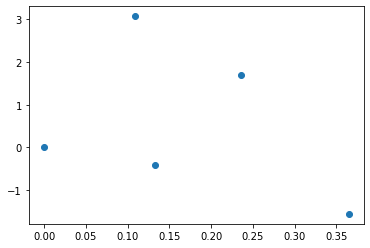

In [191]:
plt.scatter( bench_snvs.Delta_BPP,
             bench_snvs.DS_zsc_max, )

In [192]:
#now in score_motifs!
def merge_bpp( tbl_by_var,
               bpp_max_df,
               rev_strand = False,
               idx_cols = [ 'hg19_pos' ] ):
    
    tbv = tbl_by_var.copy()
    bpp = bpp_max_df.copy()
    
    idx_cols = [ col for col in idx_cols ] + [ 'ref' + rev_strand*'_c', 'alt' + rev_strand*'_c' ]
    
    outdf = tbv.set_index( idx_cols ).merge( bpp.set_index( idx_cols )[ [ col for col in bpp if col.startswith( 'DS_' ) ] ],
                                             how = 'outer',
                                             left_index = True,
                                             right_index = True ).reset_index()
    
    return outdf

In [193]:
byvartbl_wide_m = merge_bpp( byvartbl_wide_m,
                             bpp_max,
                             rev_strand = True, )

In [194]:
byvartbl_wide_m.loc[ byvartbl_wide_m.hgvs_pos == 'c.1355-31' ]

,hg19_pos,ref_c,alt_c,ref,alt,pos,chrom,varlist,hgvs_pos,exon_num,...,DBP_max,DBP_event,DBP_POS_max,bp_wt_prob,DS_zsc_bps_max,DS_zsc_ppt_max,DS_zsc_max,DS_zsc_bps_POS_max,DS_zsc_ppt_POS_max,DS_zsc_POS_max
488,32413641,G,A,C,T,1236,11,jkp815:1236:G:A,c.1355-31,9,...,0.069641,GAIN,0.0,0.012306,-0.039499,0.0,-0.005259,-25.0,-5.0,-10.0
489,32413641,G,C,C,G,1236,11,jkp815:1236:G:C,c.1355-31,9,...,0.084699,LOSS,-5.0,0.012306,-0.039166,0.0,-0.005215,-25.0,-25.0,-10.0
490,32413641,G,T,C,A,1236,11,jkp815:1236:G:T,c.1355-31,9,...,0.054039,LOSS,-5.0,0.012306,0.091573,0.0,0.012512,-25.0,-5.0,-10.0


In [195]:
bpp_wt

,#id,bps,bp_pos,sc_bps,sc_ppt,sc,zsc_bps,zsc_ppt,zsc
0,>wt1 exon 9 US intron,GGCCGAG,26,1.150747e-03,0.010405,1.197331e-05,4.027388,1.166687,4.683750
1,>wt1 exon 9 US intron,AGGCTAG,21,6.148784e-05,0.010378,6.381347e-07,-0.076325,1.161075,0.036819
2,>wt1 exon 9 US intron,ACCTTCT,14,8.120149e-10,0.000057,4.644607e-14,-0.307974,-1.017178,-0.224789
3,>wt1 exon 9 US intron,GCTAGAC,19,3.254599e-15,0.006529,2.125078e-17,-0.307977,0.348793,-0.224789
4,>wt1 exon 9 US intron,AGACCTT,16,1.130863e-16,0.002113,2.390039e-19,-0.307977,-0.583203,-0.224789
5,>wt1 exon 9 US intron,GACCTTC,15,4.669835e-16,0.000352,1.641604e-19,-0.307977,-0.955059,-0.224789
6,>wt1 exon 9 US intron,GGCTAGA,20,3.897944e-20,0.010049,3.917068e-22,-0.307977,1.091604,-0.224789
7,>wt1 exon 9 US intron,CGAGGCT,23,4.976492e-22,0.010405,5.177800e-24,-0.307977,1.166623,-0.224789
8,>wt1 exon 9 US intron,CTAGACC,18,6.631742e-22,0.005672,3.761527e-24,-0.307977,0.167827,-0.224789
9,>wt1 exon 9 US intron,GGGCCGA,27,6.373542e-23,0.010405,6.631583e-25,-0.307977,1.166696,-0.224789


In [196]:
#now in score motifs!
def merge_bpp_wt( tbl_by_var,
                  bpp_wt,
                  first_ex_bp,
                  merge_pos_col = 'hg19_pos',
                  rev_strand = False ):
    
    tbv = tbl_by_var.copy()
    
    bpp = bpp_wt.copy()
    
    bpp[ merge_pos_col ] = first_ex_bp - ( 1 + -2*rev_strand )*bpp.bp_pos
    
    bpp = bpp.rename( columns = { 'zsc_bps': 'zbpp_wt_bps',
                                  'zsc_ppt': 'zbpp_wt_ppt',
                                  'zsc': 'zbpp_wt' } )
    
    tbv = tbv.set_index( merge_pos_col ).merge( bpp.set_index( merge_pos_col )[ [ 'zbpp_wt_bps','zbpp_wt_ppt','zbpp_wt' ] ],
                                                left_index = True,
                                                right_index = True,
                                                how = 'outer' ).reset_index()
    
    return tbv

In [197]:
byvartbl_wide_m.loc[ byvartbl_wide_m.pos == 1267 ]

,hg19_pos,ref_c,alt_c,ref,alt,pos,chrom,varlist,hgvs_pos,exon_num,...,DBP_max,DBP_event,DBP_POS_max,bp_wt_prob,DS_zsc_bps_max,DS_zsc_ppt_max,DS_zsc_max,DS_zsc_bps_POS_max,DS_zsc_ppt_POS_max,DS_zsc_POS_max
396,32413610,G,A,C,T,1267,11,jkp815:1267:G:A,c.1355,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
397,32413610,G,C,C,G,1267,11,jkp815:1267:G:C,c.1355,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
398,32413610,G,T,C,A,1267,11,jkp815:1267:G:T,c.1355,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
byvartbl_wide_m = merge_bpp_wt( byvartbl_wide_m,
                                bpp_wt,
                                32413610,
                                rev_strand = True )

In [199]:
byvartbl_sat = pp.saturate_variants( byvartbl_wide_m,
                                     chr11_seq,
                                     'hg19_pos',
                                      'exon_num',
                                      rev_strand = True )[ 9 ]

In [200]:
#plots get messed up without the vector position included
byvartbl_sat[ 'pos' ] = byvartbl_sat.hg19_pos - 32412079 - 2*( byvartbl_sat.hg19_pos - byvartbl_sat.hg19_pos.min() )

In [201]:
byvartbl_sat[ 'hgvs_pos' ] = cds.pos_to_hgvspos( byvartbl_sat.pos,
                                                 ( 1058, 1554 ),
                                                [ (1267, 1359) ],
                                                [ ( 1355, 1447 ), ]
                                                )

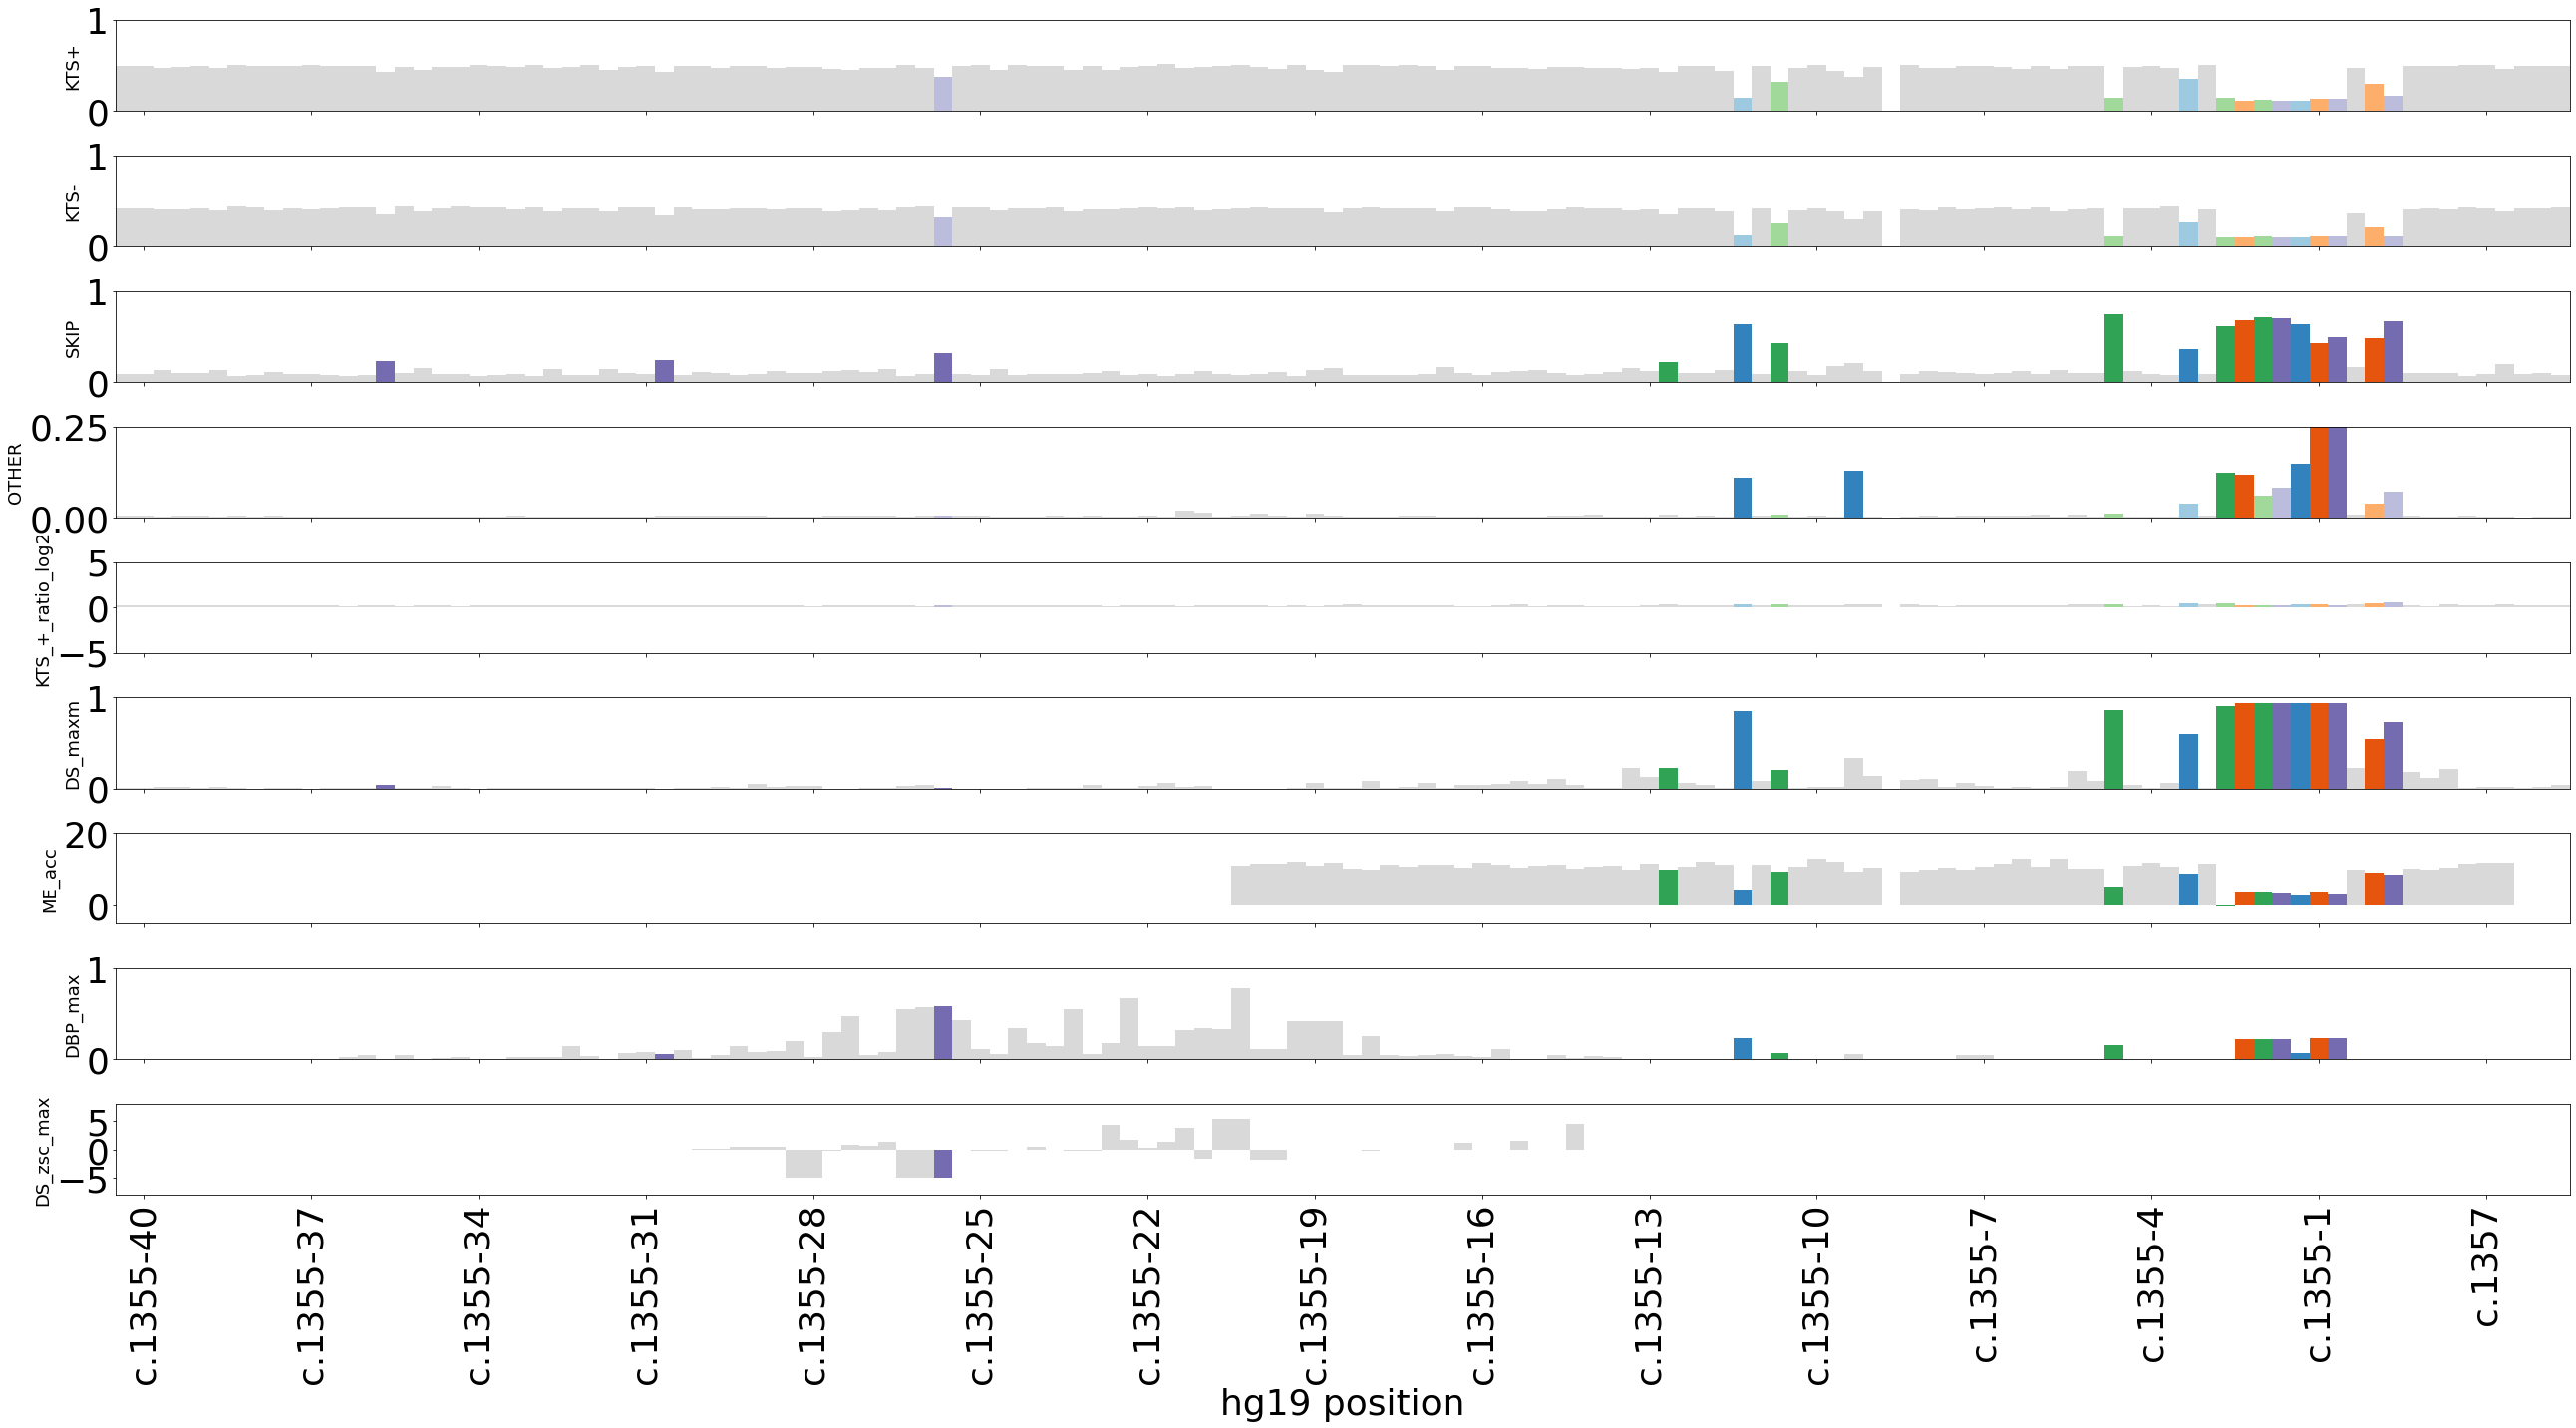

In [202]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ] + [ 'DS_maxm', 'maxent_acc', 'DBP_max', 'DS_zsc_max' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 36, 20 ),
                          zoom = ( 1227, 1270 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, .25 ), ( -5, 5 ), ( 0, 1 ), ( -5, 20 ), ( 0, 1 ), ( -8, 8 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ] + [ 'DS_maxm', 'ME_acc', 'DBP_max', 'DS_zsc_max' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 3,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

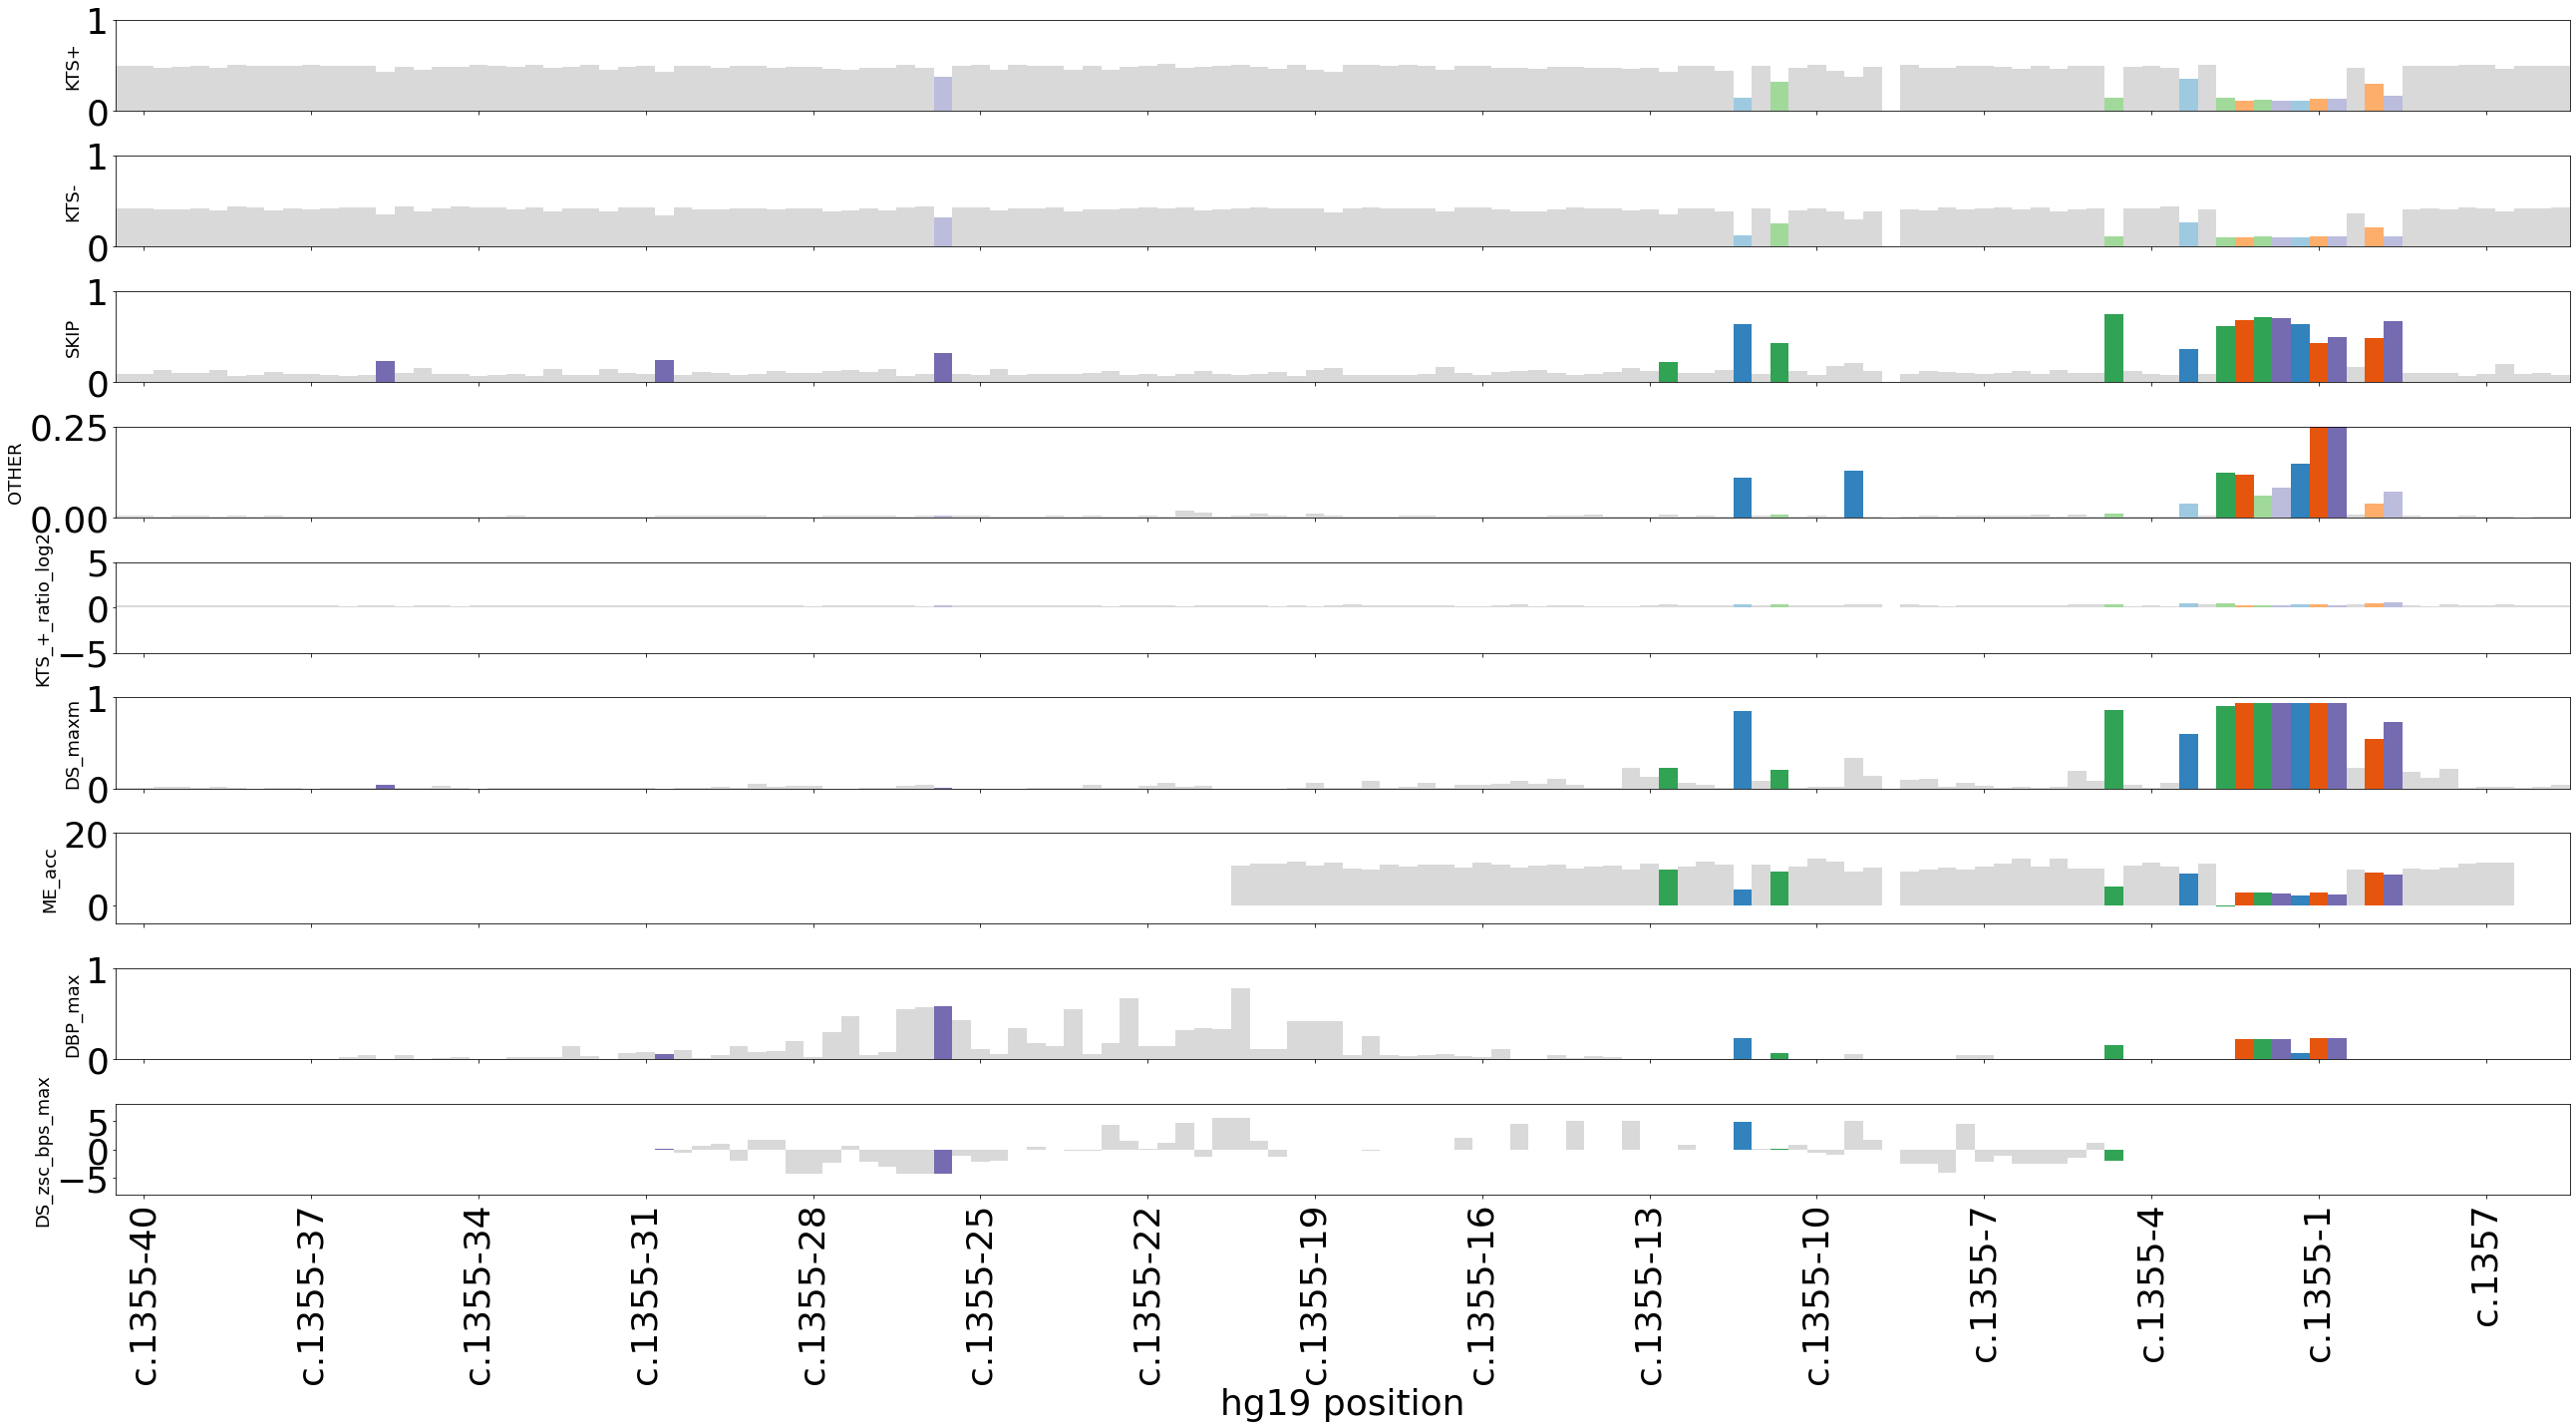

In [203]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ] + [ 'DS_maxm', 'maxent_acc', 'DBP_max', 'DS_zsc_bps_max' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 36, 20 ),
                          zoom = ( 1227, 1270 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, .25 ), ( -5, 5 ), ( 0, 1 ), ( -5, 20 ), ( 0, 1 ), ( -8, 8 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ] + [ 'DS_maxm', 'ME_acc', 'DBP_max', 'DS_zsc_bps_max' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 3,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

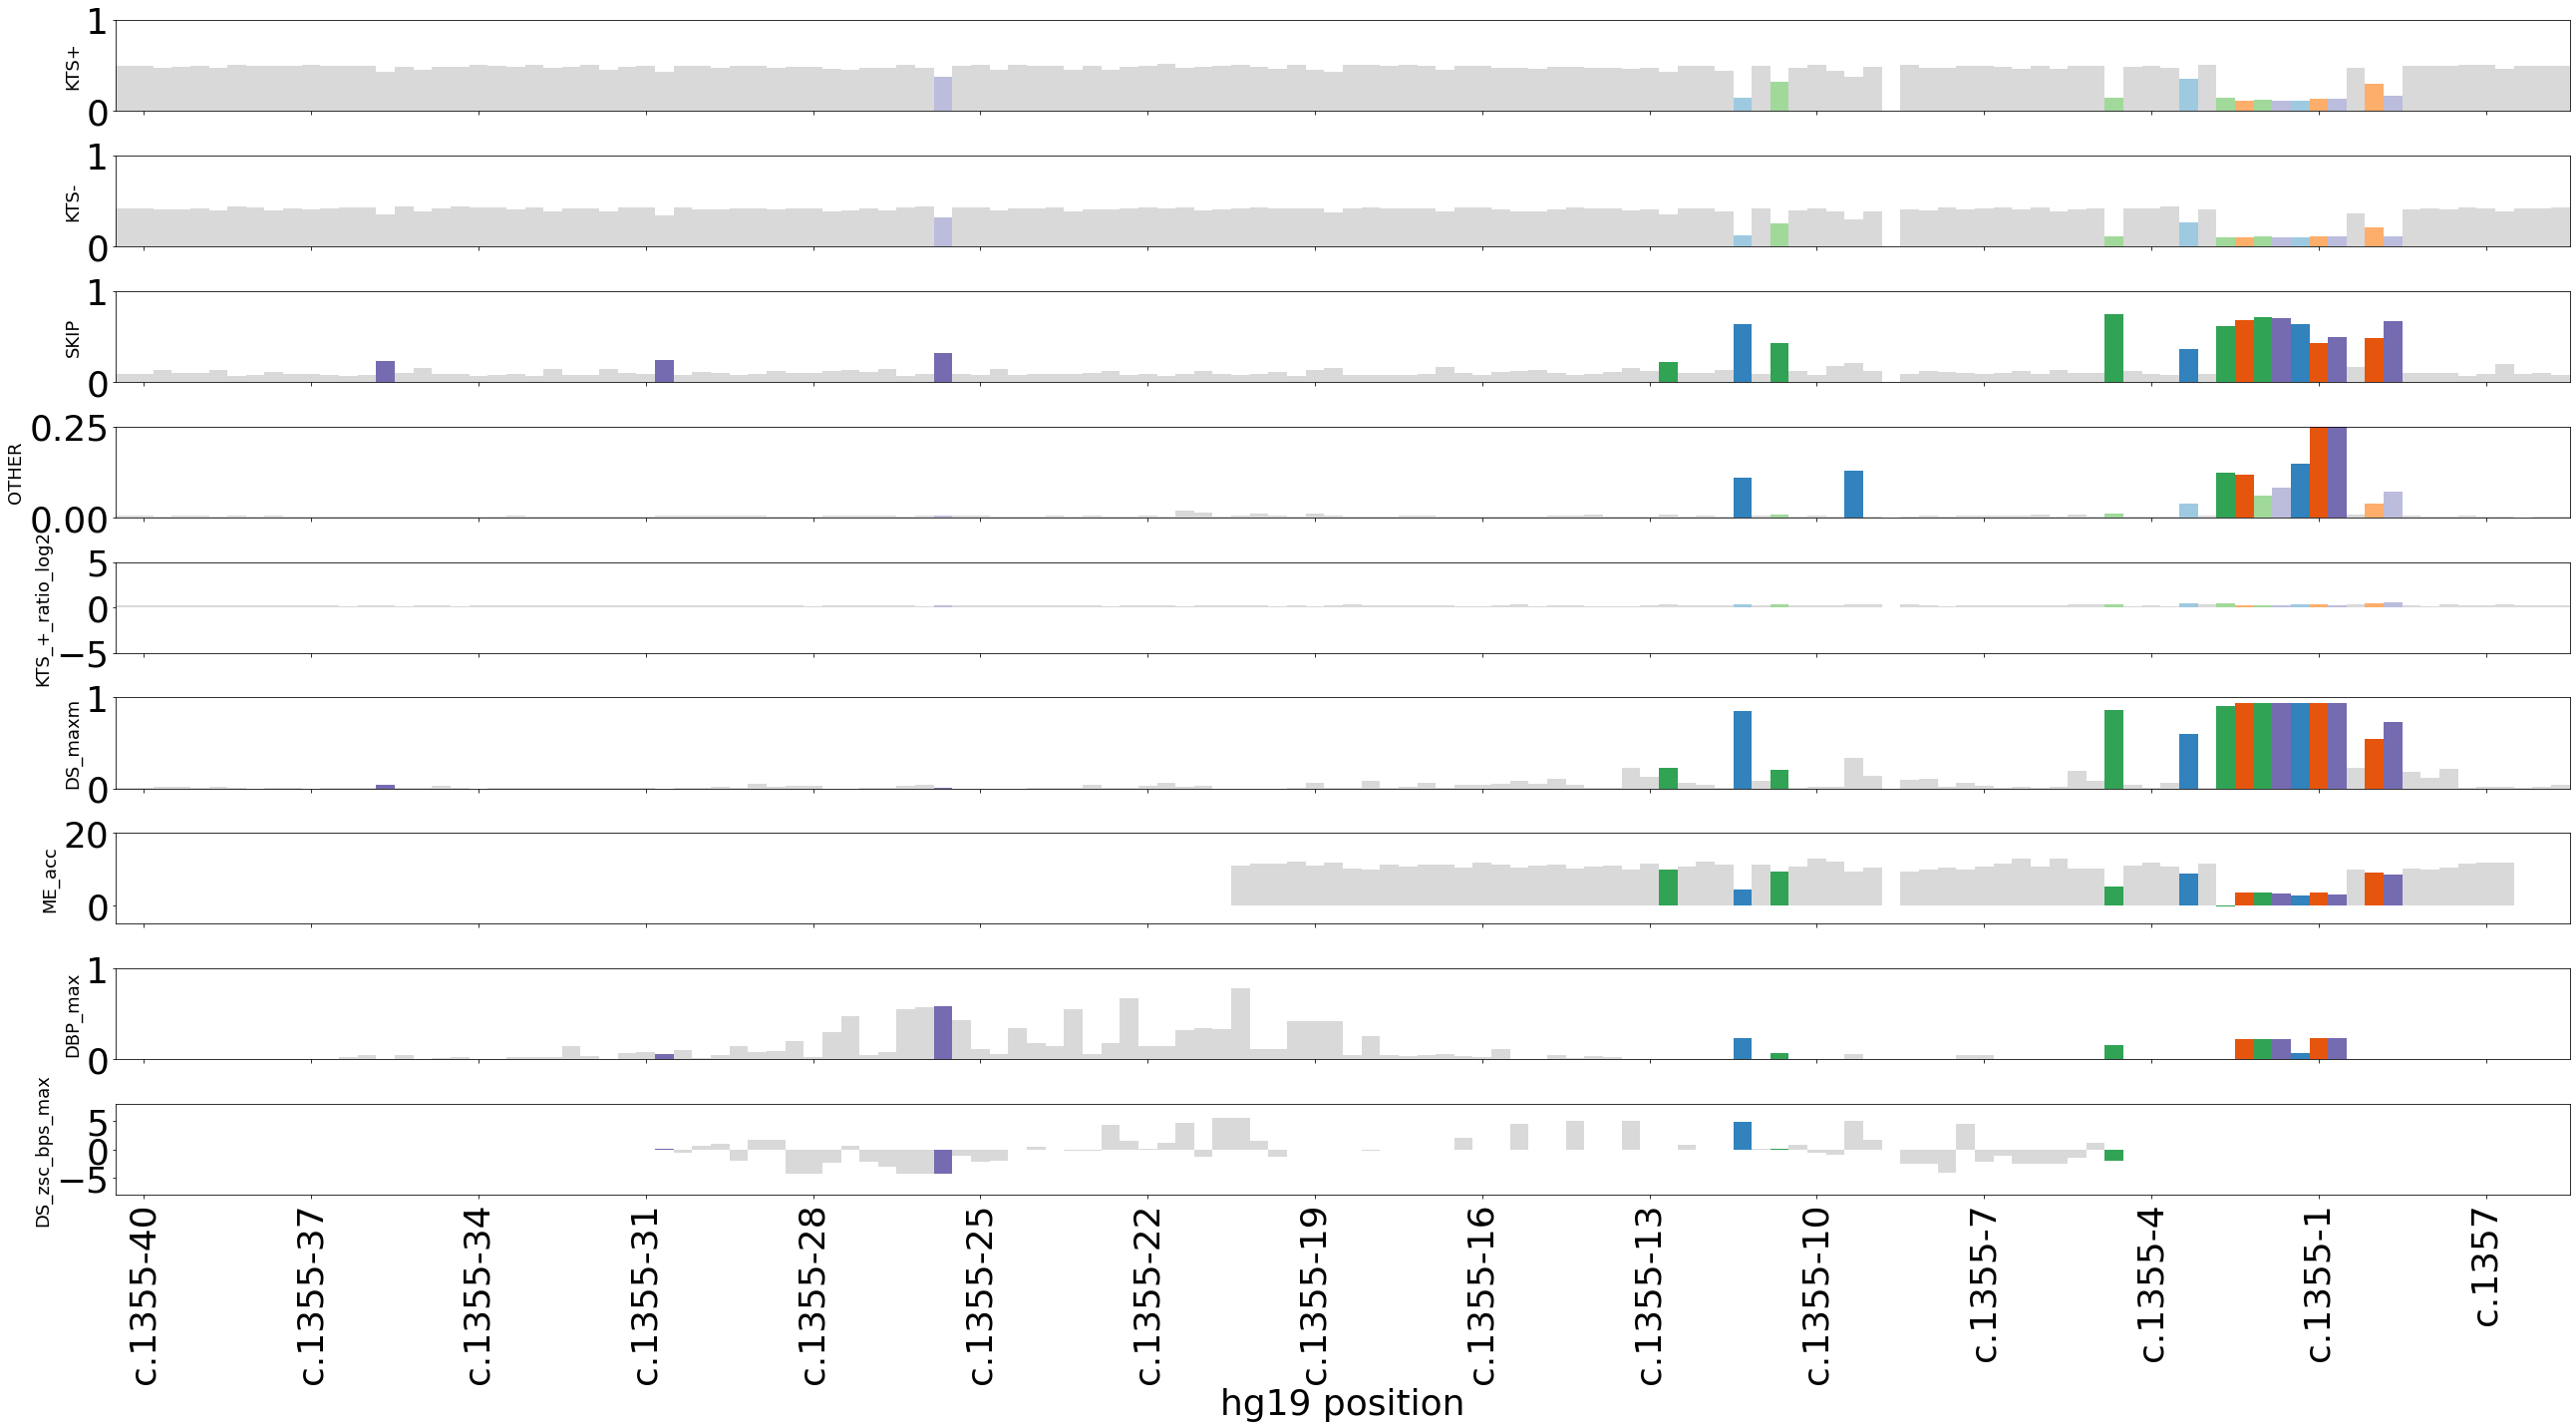

In [204]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ] + [ 'DS_maxm', 'maxent_acc', 'DBP_max', 'DS_zsc_bps_max' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 36, 20 ),
                          zoom = ( 1227, 1270 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ), ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, .25 ), ( -5, 5 ), ( 0, 1 ), ( -5, 20 ), ( 0, 1 ), ( -8, 8 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ] + [ 'DS_maxm', 'ME_acc', 'DBP_max', 'DS_zsc_bps_max' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 3,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

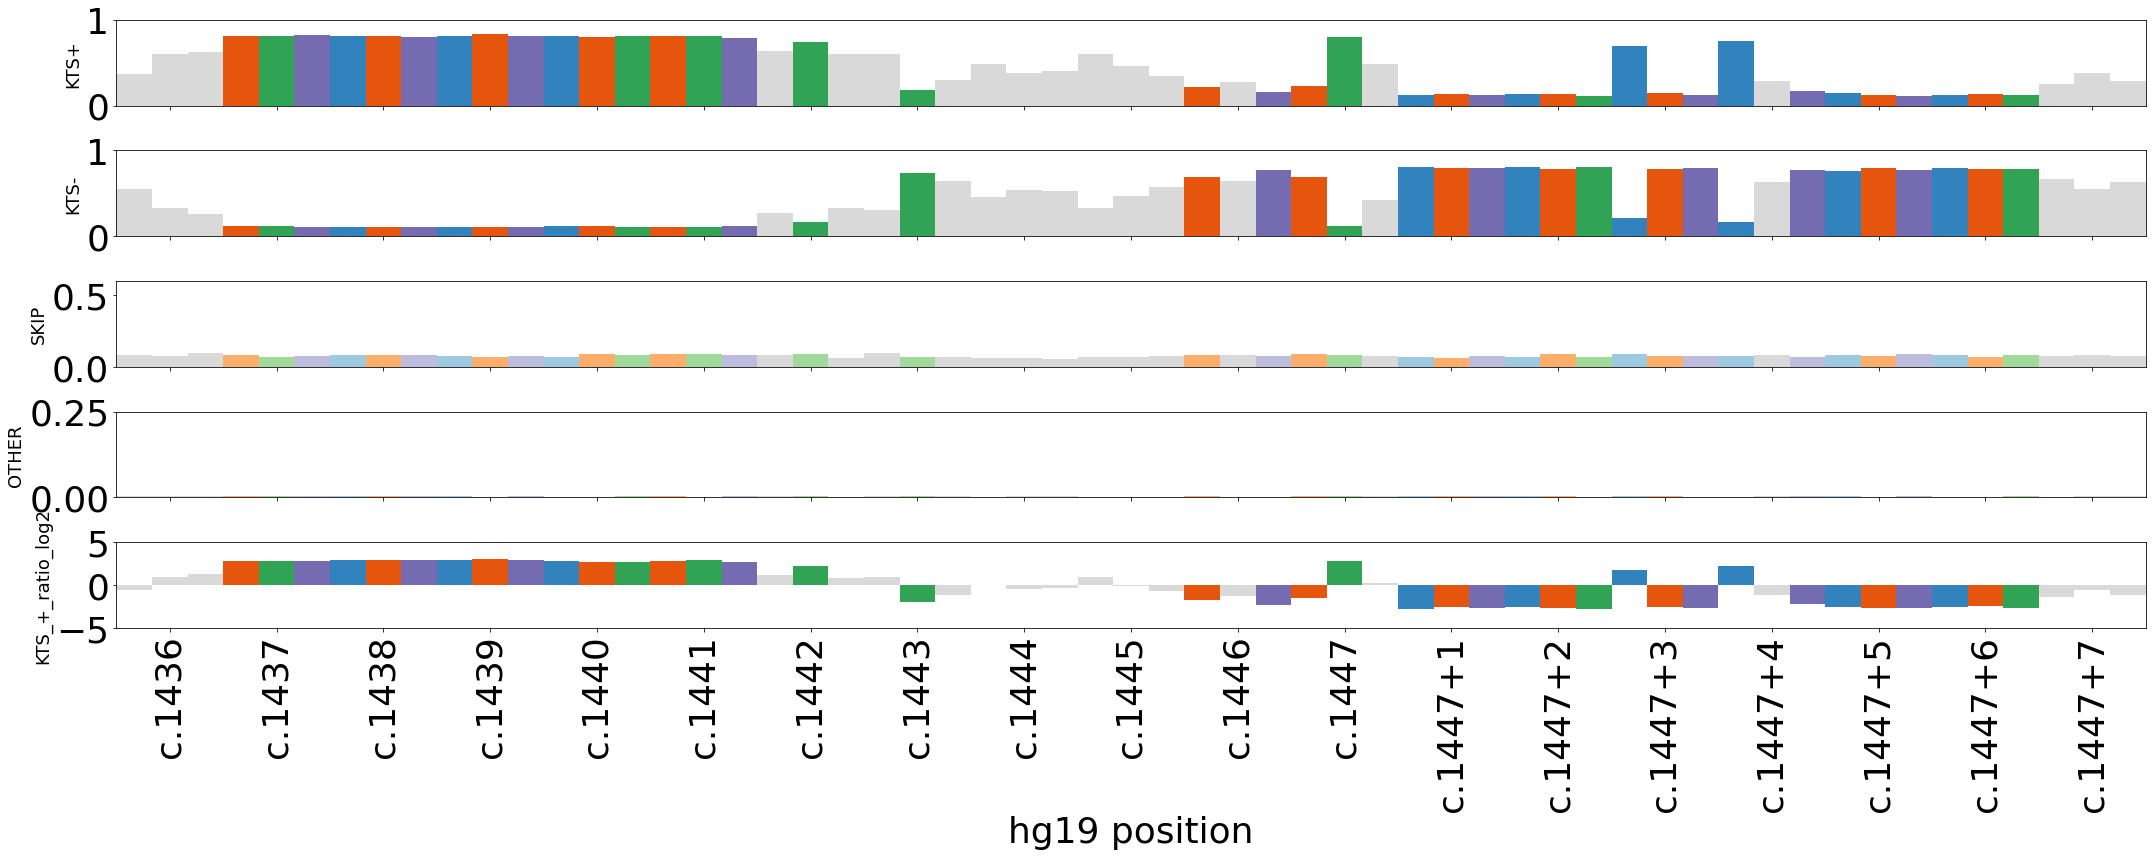

In [205]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1348, 1366 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, .6 ), ( 0, .25 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

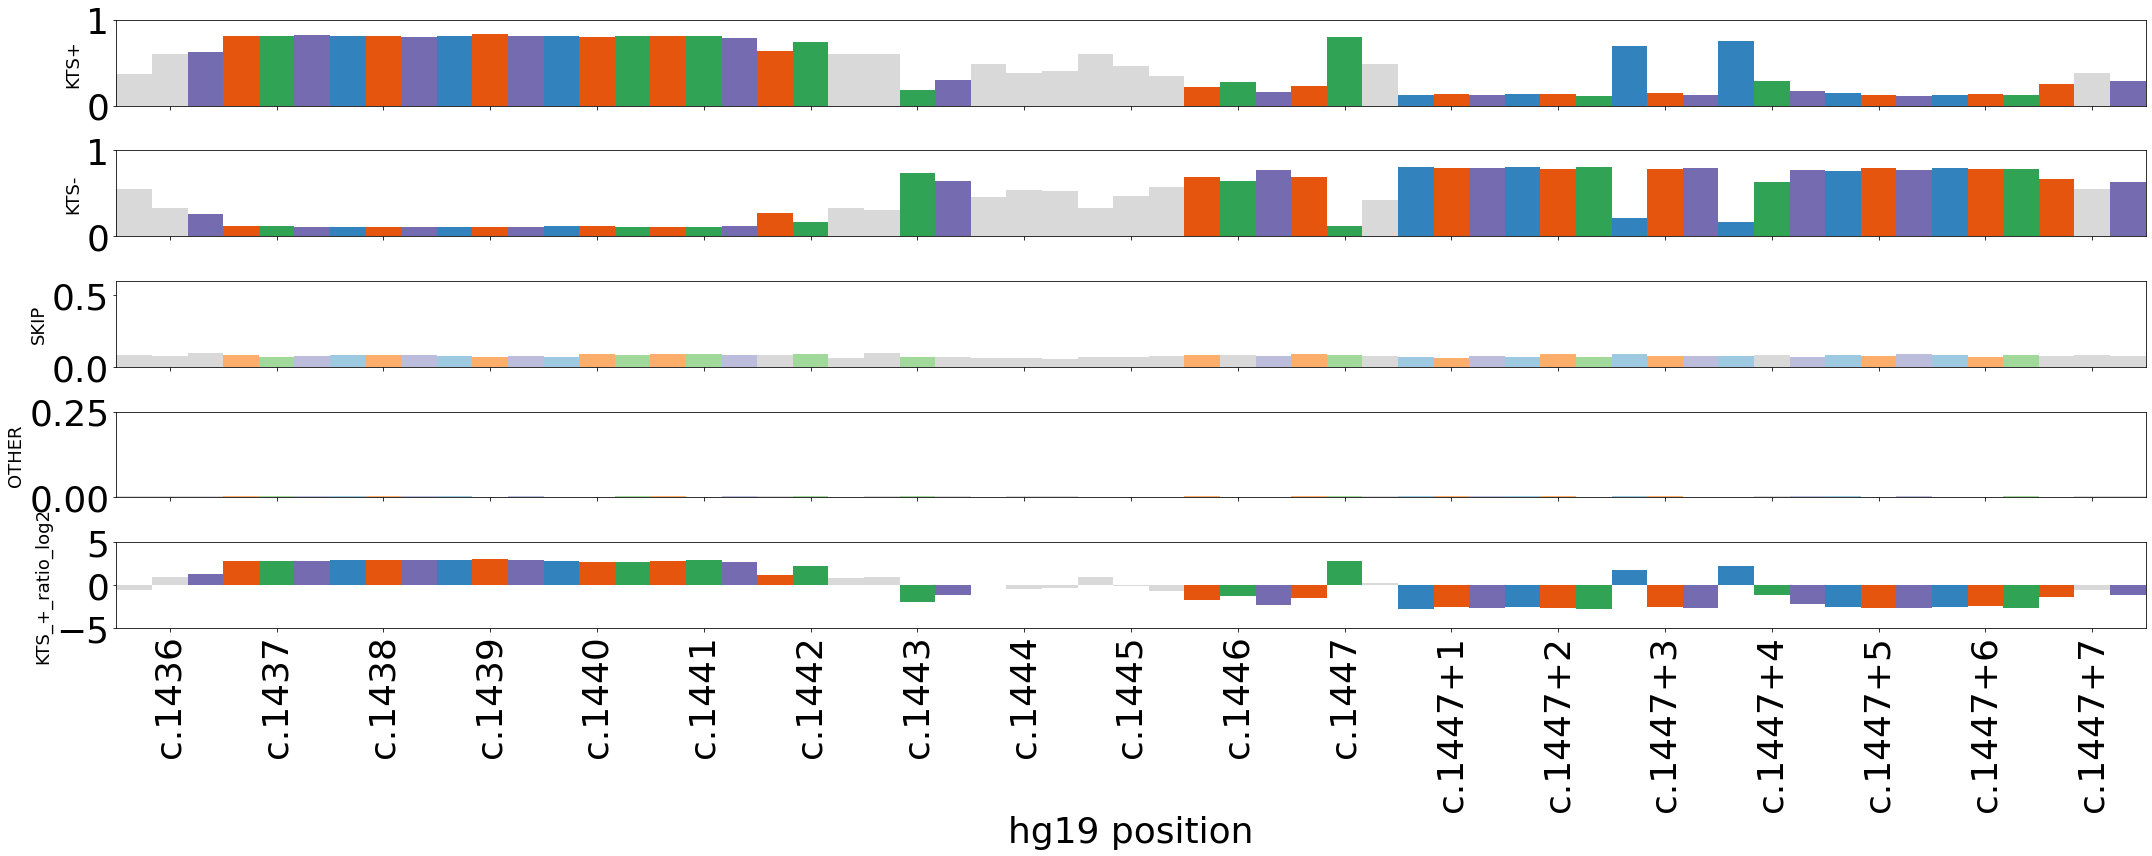

In [206]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1348, 1366 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'intmed_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, .6 ), ( 0, .25 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [207]:
view_cols = [ 'pos', 'ref_c', 'alt_c', 'hgvs_pos', 'wmean_KTS+', 'wmean_KTS-', 'wmean_KTS_+_ratio_log2', 'wmean_bs_null_KTS_+_ratio_log2', 'zwmean_bs_null_KTS_+_ratio_log2', 'fc_KTS_+_ratio_log2', ]

byvartbl_wide_m.loc[ ( byvartbl_wide_m.pos >= 1359 ) & ( byvartbl_wide_m.pos <= 1363 ) ][ view_cols ]

,pos,ref_c,alt_c,hgvs_pos,wmean_KTS+,wmean_KTS-,wmean_KTS_+_ratio_log2,wmean_bs_null_KTS_+_ratio_log2,zwmean_bs_null_KTS_+_ratio_log2,fc_KTS_+_ratio_log2
108,1363,C,A,c.1447+4,0.748652,0.166996,2.278248,0.272756,18.217225,6.893340
109,1363,C,G,c.1447+4,0.284854,0.634871,-1.143872,0.271657,-14.105054,-3.728863
110,1363,C,T,c.1447+4,0.167588,0.768101,-2.209921,0.275998,-25.044323,-7.516073
111,1362,G,A,c.1447+3,0.698575,0.214585,1.717439,0.270451,14.577891,5.867870
112,1362,G,C,c.1447+3,0.142844,0.784621,-2.532874,0.271999,-20.576258,-8.952559
113,1362,G,T,c.1447+3,0.129256,0.795219,-2.707384,0.273791,-43.414947,-9.395249
114,1361,T,A,c.1447+2,0.134881,0.801456,-2.580837,0.275750,-25.850610,-7.968785
115,1361,T,C,c.1447+2,0.136681,0.784506,-2.635233,0.285379,-23.755422,-9.872513
116,1361,T,G,c.1447+2,0.115991,0.811394,-2.745785,0.273146,-26.473720,-9.795263
117,1360,G,A,c.1447+1,0.119668,0.806982,-2.806788,0.273200,-43.119385,-9.813183


In [208]:
byvartbl_wide_m[ 'sdv_sum' ] = byvartbl_wide_m[ [ samp + '_sdv' for samp in byvartbl_long[ 'sample' ].unique() ] ].sum( axis = 1 )

In [209]:
byvartbl_wide_m[ 'intmed_sum' ] = byvartbl_wide_m[ [ samp + '_intmed' for samp in byvartbl_long[ 'sample' ].unique() ] ].sum( axis = 1 )

In [210]:
byvartbl_wide_m[ 'var_seen_sum' ] = sum( [ ( byvartbl_wide_m[ samp + '_n_bc_passfilt' ] > 0 ) & ( byvartbl_wide_m[ samp + '_n_bc_passfilt' ].notnull() ) for samp in byvartbl_long[ 'sample' ].unique() ] )

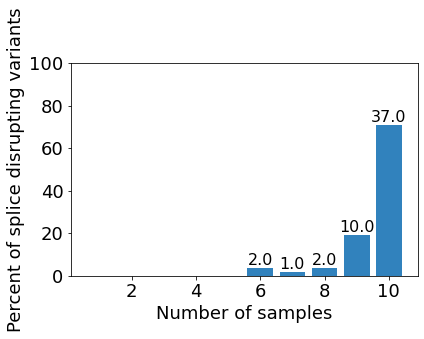

In [211]:
sp.barplot_per_repeat( byvartbl_wide_m.loc[ byvartbl_wide_m[ 'sdv' ] ],
                    'sdv_sum',
                    10,
                    ylim = ( 0, 100 ),
                    ylabel = 'Percent of splice disrupting variants',
                    xlabel = 'Number of samples',
                    #savefig = plot_out + 'sdv_by_samp.pdf',
                    color = light_colors[ 0 ]
                  )

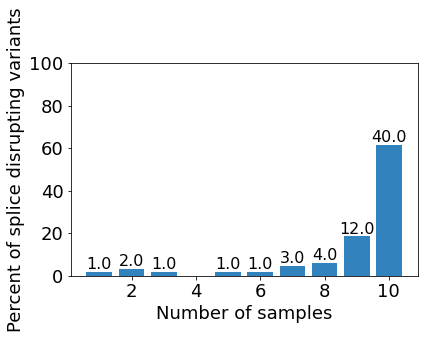

In [212]:
sp.barplot_per_repeat( byvartbl_wide_m.loc[ ( byvartbl_wide_m.intmed ) | ( byvartbl_wide_m.sdv ) ],
                    'intmed_sum',
                    10,
                    ylim = ( 0, 100 ),
                    ylabel = 'Percent of splice disrupting variants',
                    xlabel = 'Number of samples',
                    #savefig = plot_out + 'sdv_by_samp.pdf',
                    color = light_colors[ 0 ]
                  )

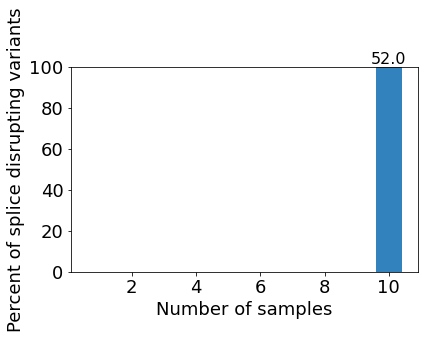

In [213]:
sp.barplot_per_repeat( byvartbl_wide_m.loc[ byvartbl_wide_m[ 'sdv' ] ],
                    'var_seen_sum',
                    10,
                    ylim = ( 0, 100 ),
                    ylabel = 'Percent of splice disrupting variants',
                    xlabel = 'Number of samples',
                    #savefig = plot_out + 'sdv_by_samp.pdf',
                    color = light_colors[ 0 ]
                  )

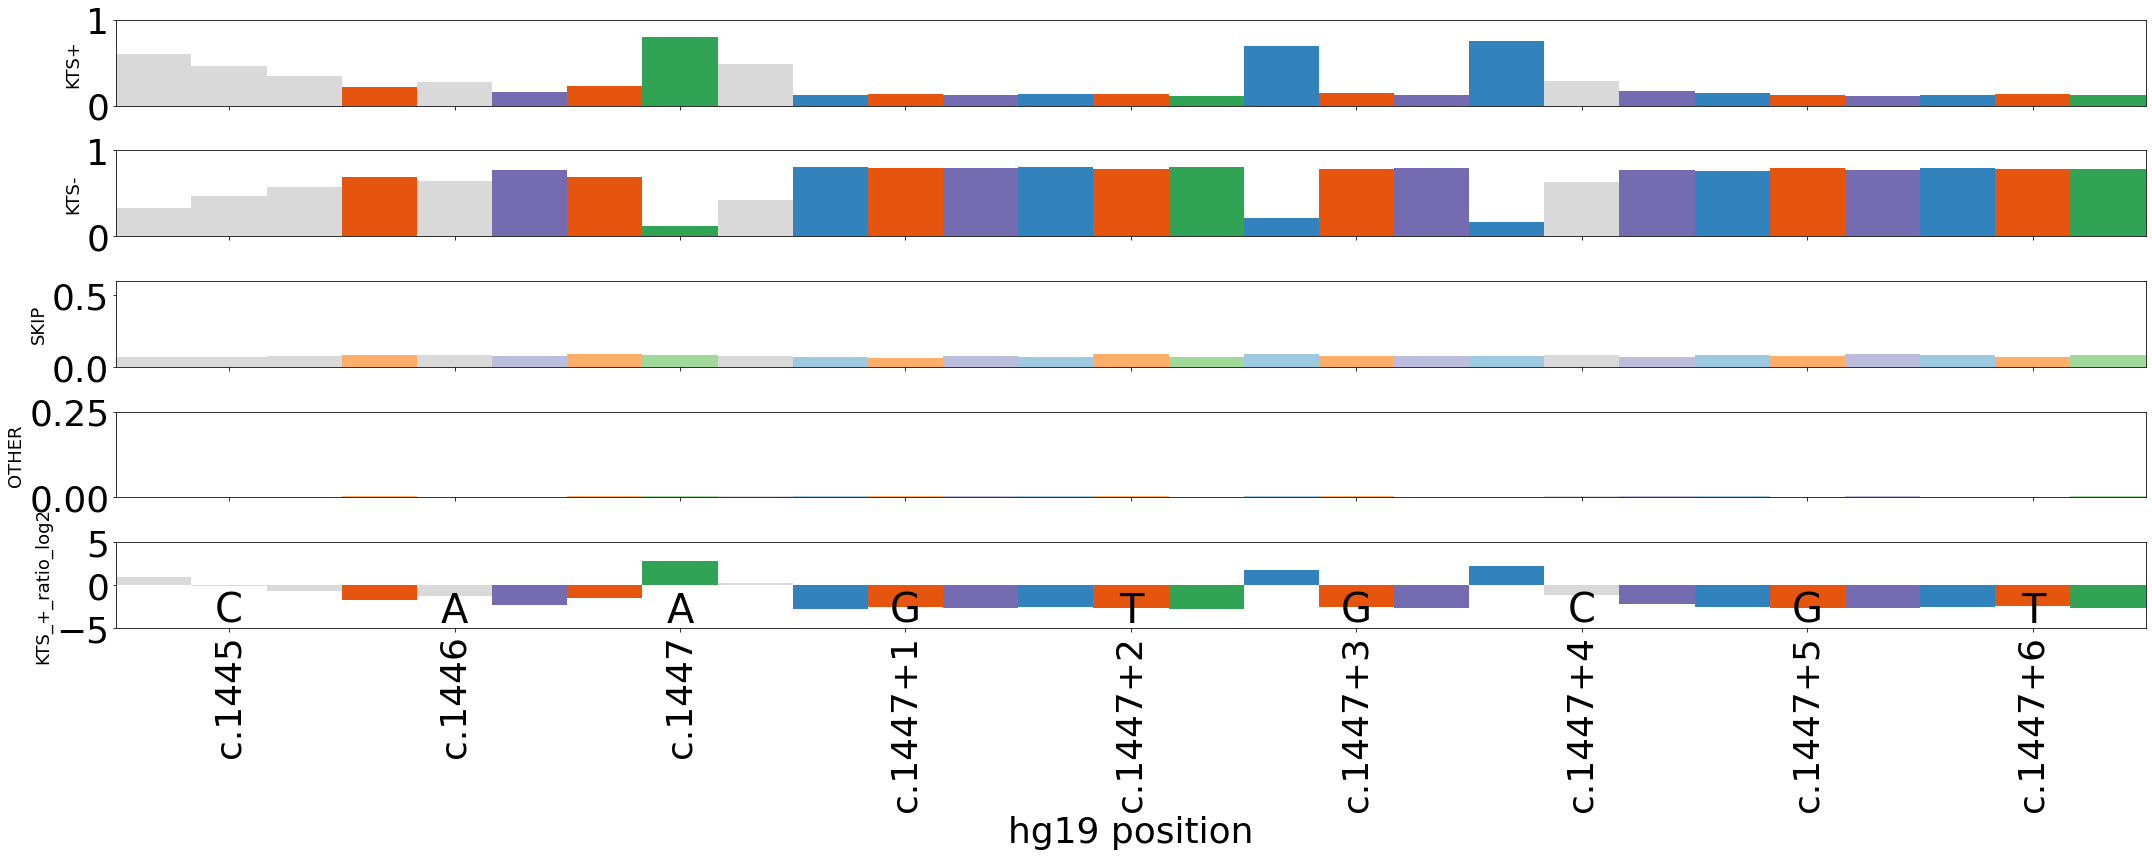

In [214]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1357, 1365 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_KTS_+_ratio_log2' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, .6 ), ( 0, .25 ), ( -5, 5 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col and 'diff' not in col ], 
                          x_ax_title = 'hg19 position',
                          ref_labels = True,
                          tick_spacing = 1,
                          
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [215]:
byvartbl_long_bs.to_csv( data_in + 'wt1_ex9_by_var_effects_snvs-2022-0721.txt',
                         sep = '\t',
                         index = False )

In [216]:
byvartbl_wide_m.to_csv( data_in + 'wt1_ex9_by_var_effects_snvs_wide-2022-0727.txt',
                        sep = '\t',
                        index = False )